# The job of this notebook is to execute the chained fit in Jinchen's order
### (2-point, Feynman-Hellman, 3-point)

In [292]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [293]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [294]:
import pickle

In [295]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [296]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [297]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")


In [298]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and Feynman-Hellman samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']

<ipython-input-298-0e8facdff2e1>:17: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
<ipython-input-298-0e8facdff2e1>:18: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
<ipython-input-298-0e8facdff2e1>:19: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))
<ipython-input-298-0e8facdff2e1>:21: RuntimeWarning: invalid value encountered in sqrt
  gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])


In [299]:
# Create functions to extract the necessary fit-parameters for each function, and to insert priors specific to a function into a more complete parameter list
# Create methods for forming a parameter subset for each of the 3 functions: 2-point, 3-point, Feynman-Hellman
def param_2pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    return sub_p
      
def param_3pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    return sub_p

def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

#def param_FHdata(p):
    #sub_p = gv.BufferDict()
    #sub_p['E0'] = p['E0']
    #sub_p['Z0'] = p['Z0']
    #sub_p['Ztilde0'] = p['Ztilde0']
    
    #for k in range(1, num_states_FHdata - 1):
        #sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        #sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        #sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    #sub_p['Z{}'.format(num_states_FHdata - 1)] = p['Z_FHdatamax']
    #sub_p['Ztilde{}'.format(num_states_FHdata - 1)] = p['Ztilde_FHdatamax']
    #sub_p['log(dE{})'.format(num_states_FHdata - 1)] = p['log(FHdata_dEmax)']
    
    #for n in range(num_states_FHdata-1):
        #for m in range(num_states_FHdata-1):
                
            #sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            #sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    #for n in range(num_states_FHdata-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FHdata-1)] = p['gA3_{}FHdatamax'.format(n)]
        #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, n)] = p['gA3_FHdatamax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FHdata-1)] = p['gV4_{}FHdatamax'.format(n)]
        #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, n)] = p['gV4_FHdatamax{}'.format(n)]
        
    #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gA3_FHdatamaxFHdatamax']
    #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gV4_FHdatamaxFHdatamax']
    
    #for n in range(num_states_FHdata):
        #sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        #sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        #sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        #sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    #return sub_p

In [300]:
# Now, create some methods for setting the full posterior, both used and unused variables 
def posterior_2pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = partial_post['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = partial_post['Ztilde{}'.format(k)]
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
        
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post          
              
def posterior_3pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post
              
def posterior_FH(partial_post, full_prior):
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = full_prior['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = full_prior['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)] 
        
    for k in range(1, num_states_FH - 1):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):    
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
                        
    full_post['Z_FHmax'] = partial_post['Z{}'.format(num_states_FH - 1)]
    full_post['log(FH_dEmax)'] = partial_post['log(dE{})'.format(num_states_FH - 1)]
              
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gA3_{}FHmax'.format(n)] = partial_post['gA3_{0}{1}'.format(n, num_states_FH-1)]
        full_post['gV4_FHmax{}'.format(n)] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gV4_{}FHmax'.format(n)] = partial_post['gV4_{0}{1}'.format(n, num_states_FH-1)]
        
    full_post['gA3_FHmaxFHmax'] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
    full_post['gV4_FHmaxFHmax'] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
      
    return full_post
    

In [301]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [302]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [303]:
num_states_FH = 1 # The number of states that the Feynman-Hellman sum needs

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    if(num_zs == num_states_FH):
        return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    if(num_zs == num_states_FH):
        return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))




def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [304]:
#num_states_FHdata = 1
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

#def C_FHdata_A3_ss(t, p):
    #return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_A3_ps(t, p):
    #return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))


#def C_FHdata_V4_ss(t, p):  
    #return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_V4_ps(t, p):
    #return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))

def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))



def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #, axes=[2,0,1]

In [305]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d
    

In [423]:
num_zs = 6
num_states_FH = 3 

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

#prior_2ptstep

1


In [424]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.86 [22]    Q = 0.66    logGBF = 483.59

Parameters:
             E0       0.659109 +- 0.00497708             [     0.67 +- 0.02 ]  
             Z0   0.000747066 +- 2.34176e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281508 +- 0.000103288             [   0.003 +- 0.003 ]  
       log(dE1)         -1.06542 +- 0.444697             [  -0.97551 +- 0.7 ]  
             Z1   0.000529446 +- 0.000189051             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00321742 +- 0.00167507             [        0 +- 0.01 ]  
       log(dE2)        -0.734767 +- 0.452652             [  -0.97551 +- 0.7 ]  
             Z2   0.000757611 +- 0.000292612             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00654625 +- 0.00263519             [        0 +- 0.01 ]  
       log(dE3)         -0.81456 +- 0.614238             [  -0.97551 +- 0.7 ]  
             Z3     0.000731681 +- 0.0004258             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.002735

In [425]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [426]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [427]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 46.104

Parameters:
             E0       0.659361 +- 0.00459209             [     0.659109 +- 0.00497708 ]  
             Z0   0.000748322 +- 2.13082e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00282034 +- 9.37097e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.04731 +- 0.392259             [       -1.06542 +- 0.444697 ]  
             Z1   0.000531999 +- 0.000171624             [ 0.000529446 +- 0.000189051 ]  
        Ztilde1     0.00327215 +- 0.00148356             [   0.00321742 +- 0.00167507 ]  
       log(dE2)        -0.731776 +- 0.440911             [      -0.734767 +- 0.452652 ]  
             Z2   0.000762328 +- 0.000289832             [ 0.000757611 +- 0.000292612 ]  
        Ztilde2     0.00656072 +- 0.00262121             [   0.00654625 +- 0.00263519 ]  
       log(dE3)        -0.822442 +- 0.613113             [       -0.81456 +- 0.614238 ]  
            

In [428]:
#current_posterior = open('2pt_FH_3pt_stageFH.obj', 'wb')
#pickle.dump(post_CFH, current_posterior)
#current_posterior.close()

In [429]:
#next_priors = open('2pt_FH_3pt_stageFH.obj', 'rb')
#prior_3pt = pickle.load(next_priors)
#next_priors.close()

In [430]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)

y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

In [431]:
fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=post_CFH, fcn = C_3pt, debug = True)
print(fit_3pt.format(pstyle='vv'))
post_3pt = fit_3pt.p

Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3332.6

Parameters:
             E0        0.661677 +- 0.00343923             [     0.659361 +- 0.00459209 ]  
             Z0    0.000755996 +- 1.46151e-05             [ 0.000748322 +- 2.13082e-05 ]  
        Ztilde0     0.00285007 +- 6.31454e-05             [  0.00282034 +- 9.37097e-05 ]  
       log(dE1)          -1.05119 +- 0.187671             [       -1.04731 +- 0.392259 ]  
             Z1    0.000500617 +- 9.26283e-05             [ 0.000531999 +- 0.000171624 ]  
        Ztilde1     0.00320461 +- 0.000643066             [   0.00327215 +- 0.00148356 ]  
       log(dE2)         -0.686454 +- 0.248266             [      -0.731776 +- 0.440911 ]  
             Z2    0.000745664 +- 0.000178841             [ 0.000762328 +- 0.000289832 ]  
        Ztilde2      0.00692875 +- 0.00194892             [   0.00656072 +- 0.00262121 ]  
       log(dE3)         -0.890712 +- 0.497459             [      -0.822442 +- 0.613113 ] 

In [432]:
final_posterior = open("Final(3pt)_out.obj", 'wb')
pickle.dump(post_3pt, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for Feynman-Hellman; E0 = ", post_3pt['E0'], " for 3-point")

E0 =  0.6591(50)  for 2-point; E0 =  0.6594(46)  for Feynman-Hellman; E0 =  0.6617(34)  for 3-point


In [433]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

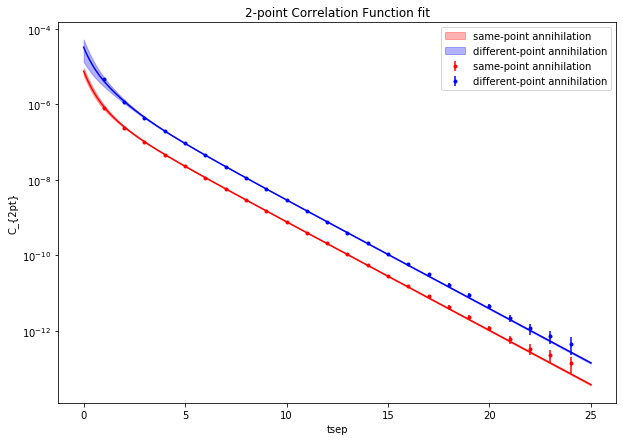

<Figure size 432x288 with 0 Axes>

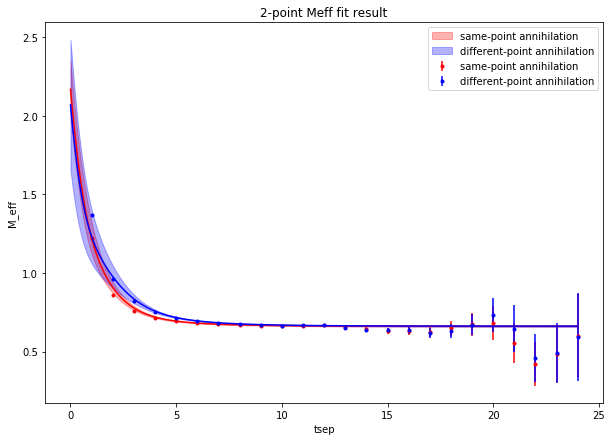

<Figure size 432x288 with 0 Axes>

In [434]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

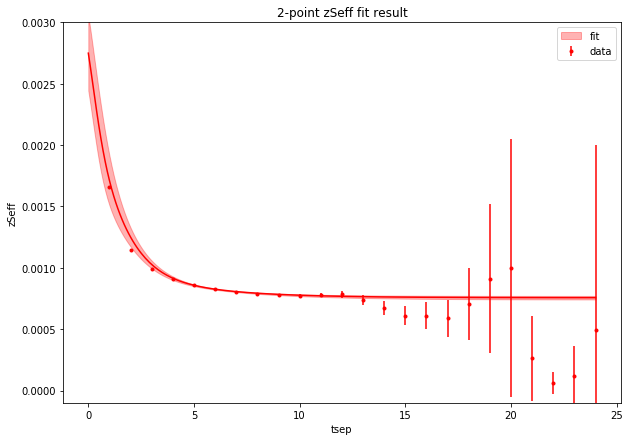

<Figure size 432x288 with 0 Axes>

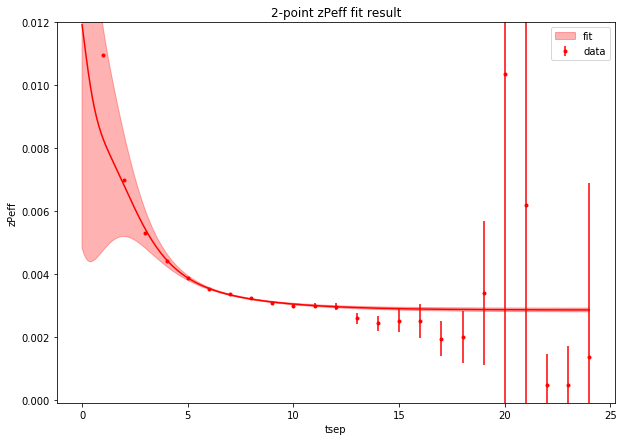

<Figure size 432x288 with 0 Axes>

In [435]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [436]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

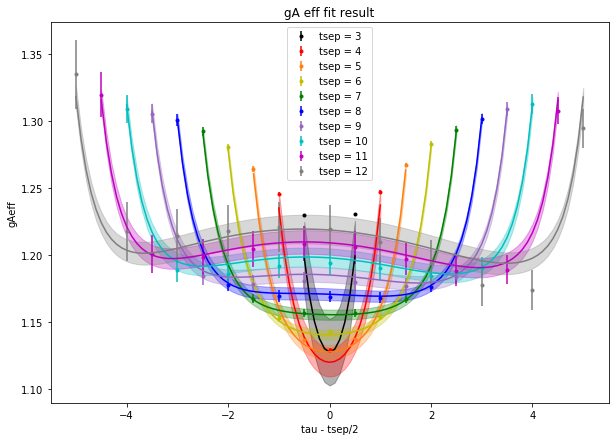

<Figure size 432x288 with 0 Axes>

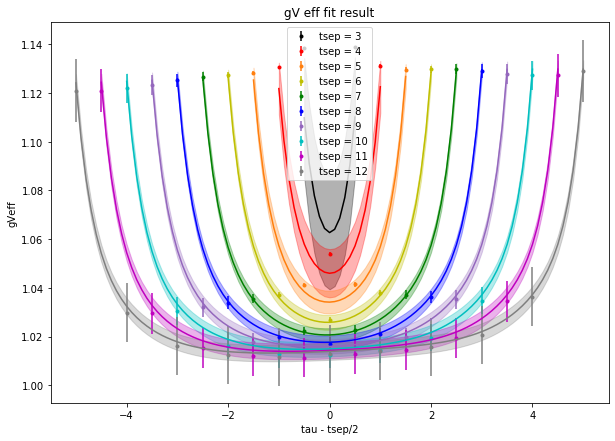

<Figure size 432x288 with 0 Axes>

In [437]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



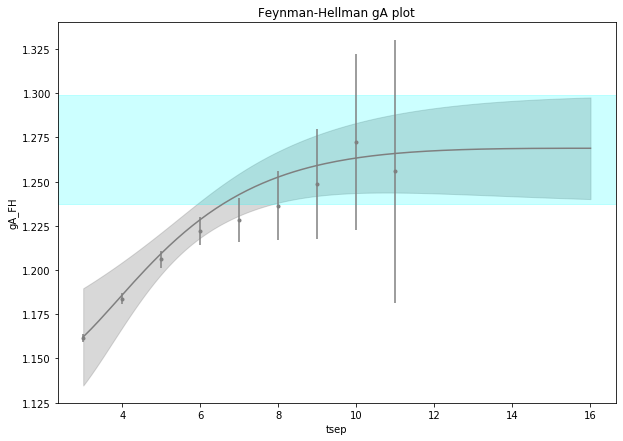

<Figure size 432x288 with 0 Axes>

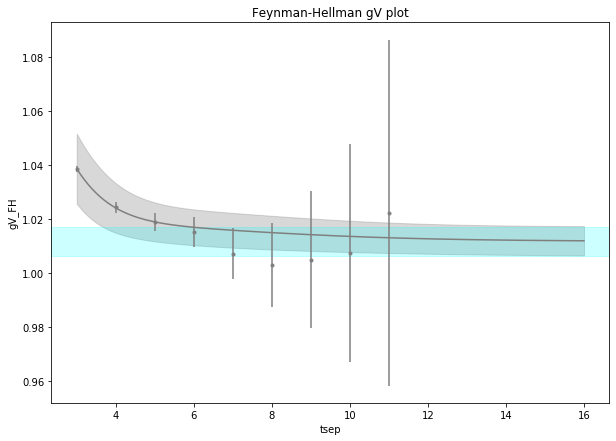

<Figure size 432x288 with 0 Axes>

In [438]:
# And finally, plot the Feynman-Hellman fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_3pt['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_3pt['gV4_00'], ydat_error=y_CFH_V4_err)



### gA_00 = 1.23 +/- 0.01; gV_00 = 1.019 +/- 0.003

### Now, try again, but with a 3 point with tau 2

In [439]:
num_zs = 4
num_states_FH = 3

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

#prior_2ptstep

1


In [440]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.85 [22]    Q = 0.67    logGBF = 484.64

Parameters:
             E0       0.661027 +- 0.00280207             [     0.67 +- 0.02 ]  
             Z0   0.000756981 +- 1.03675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286124 +- 4.6968e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.8113 +- 0.135657             [  -0.97551 +- 0.7 ]  
             Z1   0.000662449 +- 9.46282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00448214 +- 0.000764342             [        0 +- 0.01 ]  
       log(dE2)        -0.516866 +- 0.438609             [  -0.97551 +- 0.7 ]  
             Z2    0.000799852 +- 0.00040447             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0059393 +- 0.0030705             [        0 +- 0.01 ]  
       log(dE3)         -0.526875 +- 0.58489             [  -0.97551 +- 0.7 ]  
             Z3    0.00118014 +- 0.000236461             [ 0.0012 +- 0.0006 ]  
        Ztilde3      0.008748

In [441]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [442]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [443]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 46.333

Parameters:
             E0       0.661074 +- 0.00274943             [     0.661027 +- 0.00280207 ]  
             Z0   0.000757199 +- 1.01756e-05             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0    0.00286188 +- 4.60965e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)        -0.810387 +- 0.133613             [        -0.8113 +- 0.135657 ]  
             Z1   0.000659273 +- 9.38123e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00448196 +- 0.000754108             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.528043 +- 0.437477             [      -0.516866 +- 0.438609 ]  
             Z2    0.000801422 +- 0.00040434             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00587028 +- 0.00306862             [     0.0059393 +- 0.0030705 ]  
       log(dE3)        -0.525482 +- 0.582458             [       -0.526875 +- 0.58489 ]  
            

In [444]:
#current_posterior = open('2pt_FH_3pt_stageFH.obj', 'wb')
#pickle.dump(post_CFH, current_posterior)
#current_posterior.close()

In [445]:
#next_priors = open('2pt_FH_3pt_stageFH.obj', 'rb')
#prior_3pt = pickle.load(next_priors)
#next_priors.close()

In [446]:
tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

In [447]:


fit_3pt_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=post_CFH, fcn = C_3pt, debug = True)
print(fit_3pt_tau2.format(pstyle='vv'))
post_3pt_tau2 = fit_3pt_tau2.p

Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.4    logGBF = 2353.6

Parameters:
             E0       0.659256 +- 0.00231638             [     0.661074 +- 0.00274943 ]  
             Z0    0.000748614 +- 8.3101e-06             [ 0.000757199 +- 1.01756e-05 ]  
        Ztilde0    0.00281907 +- 3.69447e-05             [  0.00286188 +- 4.60965e-05 ]  
       log(dE1)       -0.907568 +- 0.0804178             [      -0.810387 +- 0.133613 ]  
             Z1    0.00063358 +- 5.05102e-05             [ 0.000659273 +- 9.38123e-05 ]  
        Ztilde1    0.00413435 +- 0.000414519             [  0.00448196 +- 0.000754108 ]  
       log(dE2)       0.0698333 +- 0.0728476             [      -0.528043 +- 0.437477 ]  *
             Z2    0.00149048 +- 0.000177534             [  0.000801422 +- 0.00040434 ]  *
        Ztilde2      0.0113389 +- 0.00125738             [   0.00587028 +- 0.00306862 ]  *
       log(dE3)        -0.300188 +- 0.431431             [      -0.525482 +- 0.582458 ]  
          

In [448]:
final_posterior = open("Final(3pt)_tau2_out.obj", 'wb')
pickle.dump(post_3pt_tau2, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for Feynman-Hellman; E0 = ", post_3pt_tau2['E0'], " for 3-point")

E0 =  0.6610(28)  for 2-point; E0 =  0.6611(27)  for Feynman-Hellman; E0 =  0.6593(23)  for 3-point


In [449]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt_tau2)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

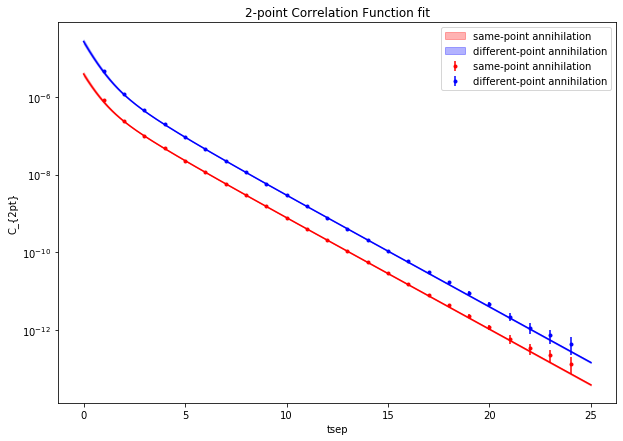

<Figure size 432x288 with 0 Axes>

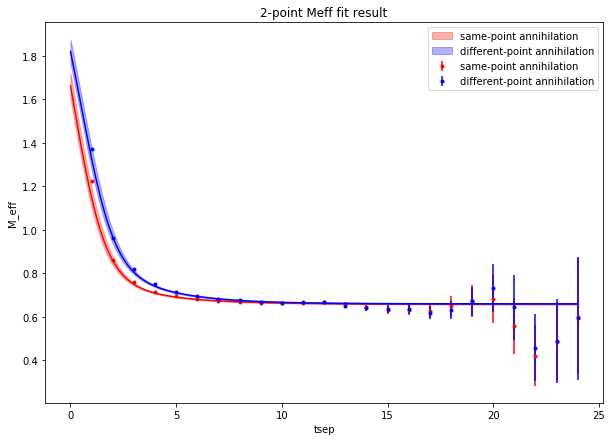

<Figure size 432x288 with 0 Axes>

In [450]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

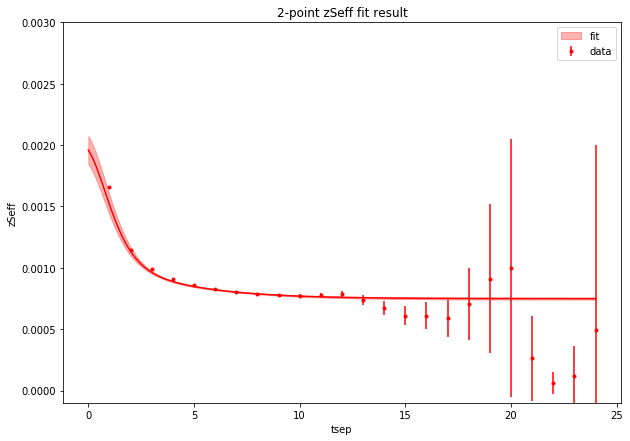

<Figure size 432x288 with 0 Axes>

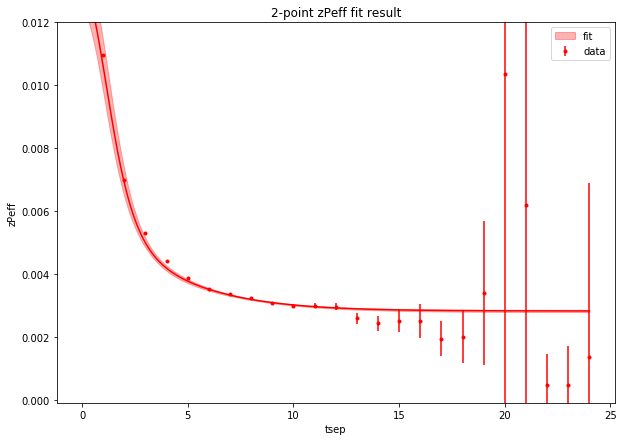

<Figure size 432x288 with 0 Axes>

In [451]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [452]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt_tau2)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

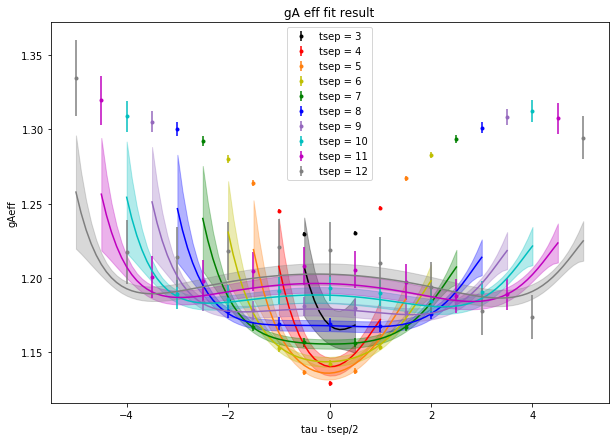

<Figure size 432x288 with 0 Axes>

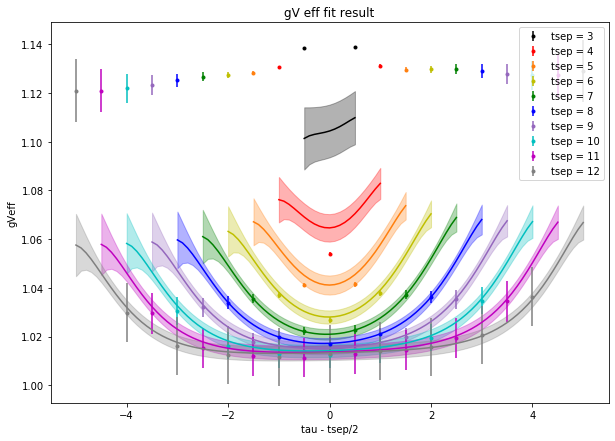

<Figure size 432x288 with 0 Axes>

In [453]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



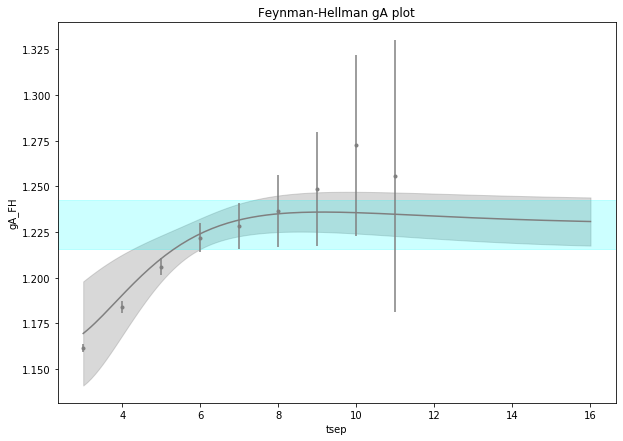

<Figure size 432x288 with 0 Axes>

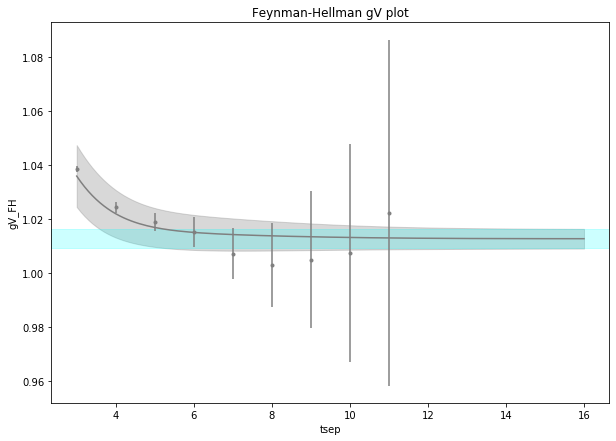

<Figure size 432x288 with 0 Axes>

In [454]:
# And finally, plot the Feynman-Hellman fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt_tau2)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt_tau2)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_3pt_tau2['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_3pt_tau2['gV4_00'], ydat_error=y_CFH_V4_err)



### gA3_00 = 1.22815 +- 0.0133987, gV4_00 =1.01296 +- 0.00358532  

## Try adding in the FH fit

In [455]:
num_zs = 7
num_states_FH = 2
#num_states_FHdata = 3

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    prior_2ptstep["d_gA_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gA_ps_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gV_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gV_ps_{}".format(n)] = gv.gvar(0,0.00001)
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
prior_2ptstep['Ztilde_FHmax'] = gv.gvar(0, 0.01)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior_2ptstep['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior_2ptstep['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior_2ptstep['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior_2ptstep['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior_2ptstep['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior_2ptstep['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)

#prior_2ptstep

0


In [456]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.9 [22]    Q = 0.59    logGBF = 483.09

Parameters:
             E0       0.659347 +- 0.00482406             [     0.67 +- 0.02 ]  
             Z0   0.000748018 +- 2.26286e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281834 +- 0.000100562             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07435 +- 0.453575             [  -0.97551 +- 0.7 ]  
             Z1   0.000518164 +- 0.000197072             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00318134 +- 0.00168234             [        0 +- 0.01 ]  
       log(dE2)        -0.732238 +- 0.442562             [  -0.97551 +- 0.7 ]  
             Z2   0.000778871 +- 0.000287095             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0064959 +- 0.0026369             [        0 +- 0.01 ]  
       log(dE3)        -0.853576 +- 0.645681             [  -0.97551 +- 0.7 ]  
             Z3   0.000712665 +- 0.000420096             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.0030271

In [457]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [458]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [459]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 46.545

Parameters:
             E0       0.659493 +- 0.00468475             [     0.659347 +- 0.00482406 ]  
             Z0   0.000748723 +- 2.21416e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00282116 +- 9.86772e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.06801 +- 0.452498             [       -1.07435 +- 0.453575 ]  
             Z1    0.000515759 +- 0.00019659             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1     0.00319093 +- 0.00168029             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -0.736855 +- 0.44144             [      -0.732238 +- 0.442562 ]  
             Z2   0.000782218 +- 0.000286582             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00646897 +- 0.00262434             [     0.0064959 +- 0.0026369 ]  
       log(dE3)        -0.855432 +- 0.645319             [      -0.853576 +- 0.645681 ]  
         

In [460]:
# Feynman-Hellman fit
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=post_CFH,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 1.1 [36]    Q = 0.38    logGBF = 144.29

Parameters:
             E0        0.660488 +- 0.00438595             [     0.659493 +- 0.00468475 ]  
             Z0    0.000752768 +- 2.07793e-05             [ 0.000748723 +- 2.21416e-05 ]  
        Ztilde0     0.00284078 +- 9.21318e-05             [  0.00282116 +- 9.86772e-05 ]  
       log(dE1)          -1.00678 +- 0.433305             [       -1.06801 +- 0.452498 ]  
             Z1    0.000535426 +- 0.000192066             [  0.000515759 +- 0.00019659 ]  
        Ztilde1      0.00330857 +- 0.00163253             [   0.00319093 +- 0.00168029 ]  
       log(dE2)         -0.780327 +- 0.437831             [       -0.736855 +- 0.44144 ]  
             Z2    0.000704402 +- 0.000284686             [ 0.000782218 +- 0.000286582 ]  
        Ztilde2       0.0066978 +- 0.00260239             [   0.00646897 +- 0.00262434 ]  
       log(dE3)         -0.926554 +- 0.644318             [      -0.855432 +- 0.645319 ]  


In [461]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)

y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

In [462]:
fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=post_FHdata, fcn = C_3pt, debug = True)
print(fit_3pt.format(pstyle='vv'))
post_3pt = fit_3pt.p

Least Square Fit:
  chi2/dof [dof] = 0.73 [130]    Q = 0.99    logGBF = 3326

Parameters:
             E0        0.661453 +- 0.00345451             [      0.660488 +- 0.00438595 ]  
             Z0    0.000753494 +- 1.53885e-05             [  0.000752768 +- 2.07793e-05 ]  
        Ztilde0     0.00283549 +- 6.73933e-05             [   0.00284078 +- 9.21318e-05 ]  
       log(dE1)           -1.3497 +- 0.258114             [        -1.00678 +- 0.433305 ]  
             Z1    0.000298142 +- 0.000106995             [  0.000535426 +- 0.000192066 ]  *
        Ztilde1     0.00174939 +- 0.000926807             [    0.00330857 +- 0.00163253 ]  
       log(dE2)          -1.28259 +- 0.257493             [       -0.780327 +- 0.437831 ]  *
             Z2    0.000580903 +- 0.000172134             [  0.000704402 +- 0.000284686 ]  
        Ztilde2      0.00402581 +- 0.00180936             [     0.0066978 +- 0.00260239 ]  *
       log(dE3)         -0.818377 +- 0.462697             [       -0.926554 +- 

In [463]:
final_posterior = open("Final(3pt)_withFH_out.obj", 'wb')
pickle.dump(post_3pt, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for sum-sub; E0 = ", post_FHdata['E0'], " for Feynman-Hellman; E0 = ", post_3pt['E0'], " for 3-point")

E0 =  0.6593(48)  for 2-point; E0 =  0.6595(47)  for sum-sub; E0 =  0.6605(44)  for Feynman-Hellman; E0 =  0.6615(35)  for 3-point


In [464]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

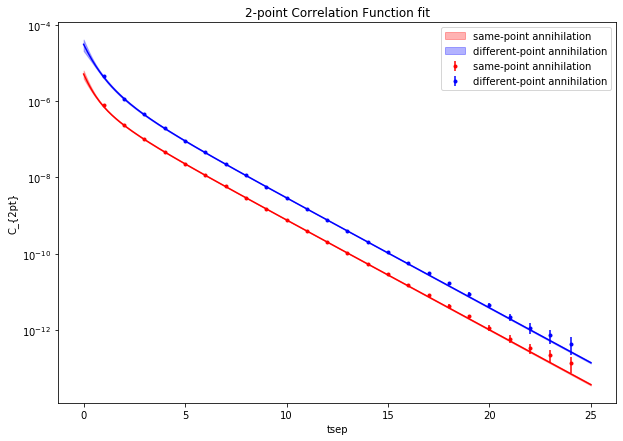

<Figure size 432x288 with 0 Axes>

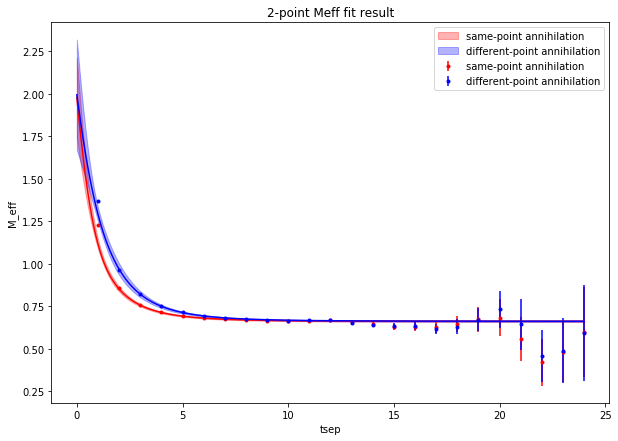

<Figure size 432x288 with 0 Axes>

In [465]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

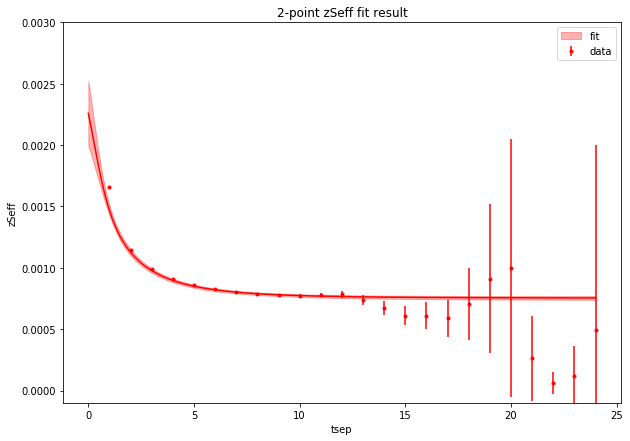

<Figure size 432x288 with 0 Axes>

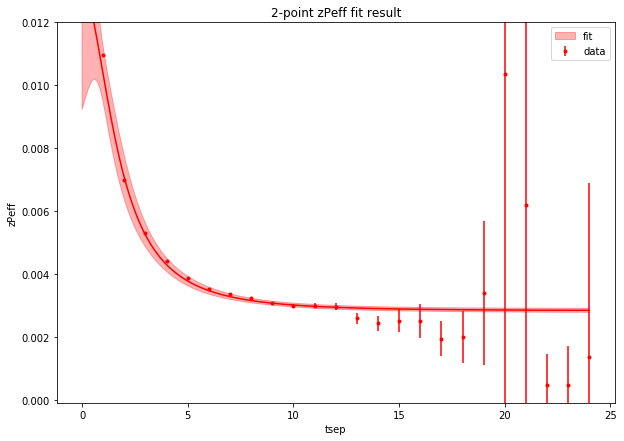

<Figure size 432x288 with 0 Axes>

In [466]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [467]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

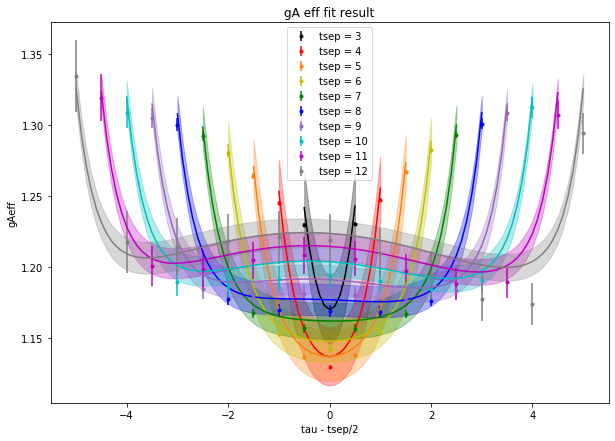

<Figure size 432x288 with 0 Axes>

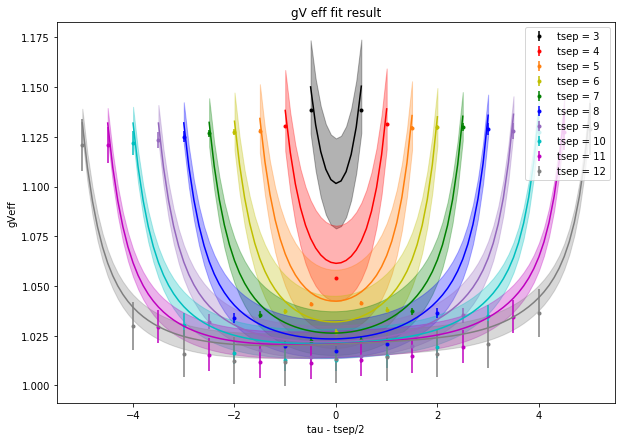

<Figure size 432x288 with 0 Axes>

In [468]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



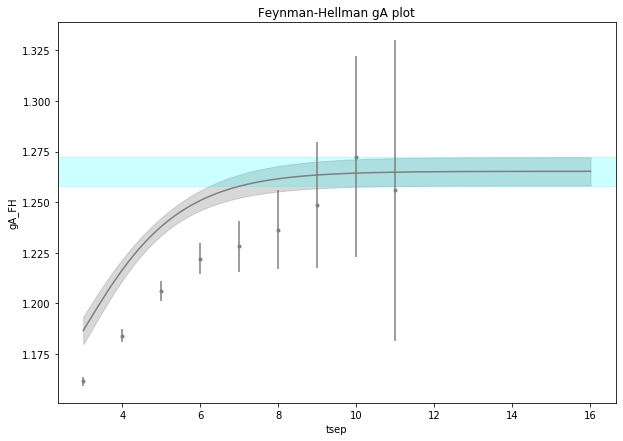

<Figure size 432x288 with 0 Axes>

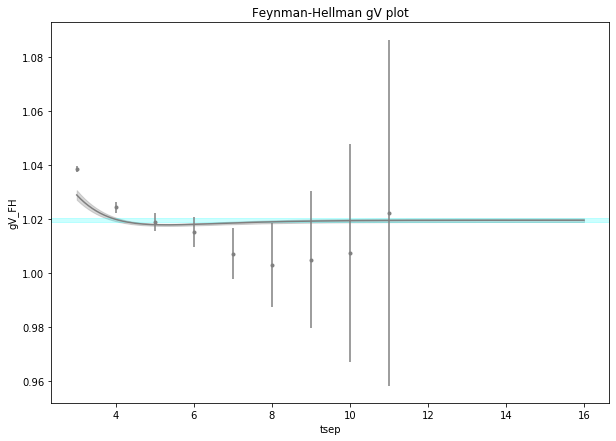

<Figure size 432x288 with 0 Axes>

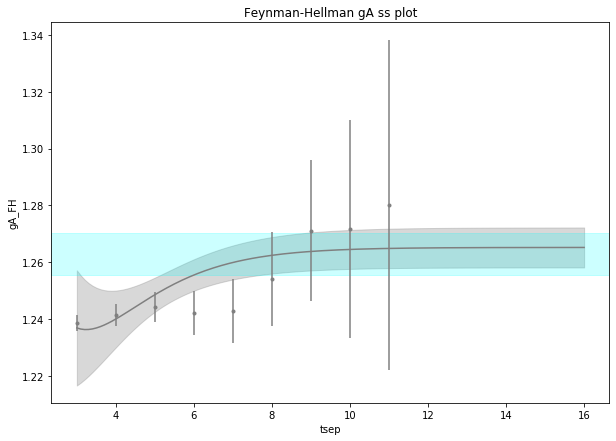

<Figure size 432x288 with 0 Axes>

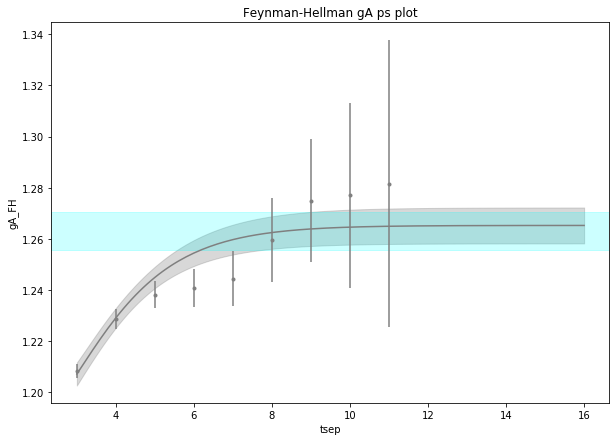

<Figure size 432x288 with 0 Axes>

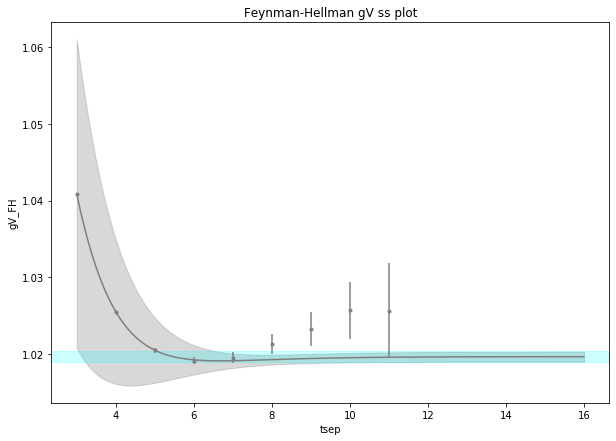

<Figure size 432x288 with 0 Axes>

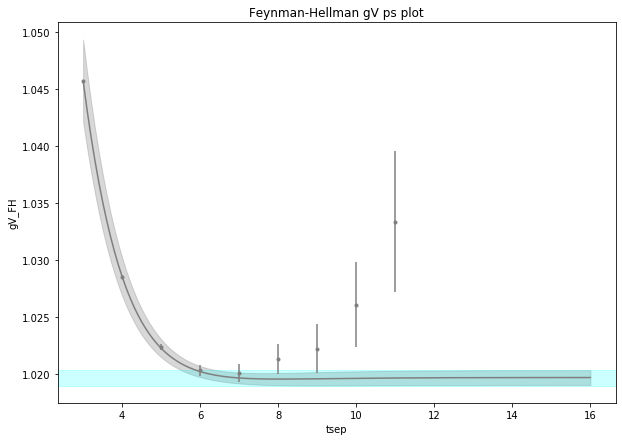

<Figure size 432x288 with 0 Axes>

In [469]:
# And finally, plot the Feynman-Hellman fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_3pt['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_3pt['gV4_00'], ydat_error=y_CFH_V4_err)

step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)


#CFH_A3_model = C_FH_A3(t_FH_model, post_CFHV4)
#CFH_V4_model = C_FH_V4(t_FH_model, post_CFHV4)
FH_A3_ss_model = C_FHdata_A3_ss(t_FH_model, post_3pt)
FH_A3_ps_model = C_FHdata_A3_ps(t_FH_model, post_3pt)
FH_V4_ss_model = C_FHdata_V4_ss(t_FH_model, post_3pt)
FH_V4_ps_model = C_FHdata_V4_ps(t_FH_model, post_3pt)

FH_A3_ss_model_mean = np.array([FH_A3_ss_model[i].mean for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_upbound = np.array([FH_A3_ss_model[i].mean + FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_lowbound = np.array([FH_A3_ss_model[i].mean - FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ps_model_mean = np.array([FH_A3_ps_model[i].mean for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_upbound = np.array([FH_A3_ps_model[i].mean + FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_lowbound = np.array([FH_A3_ps_model[i].mean - FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_V4_ss_model_mean = np.array([FH_V4_ss_model[i].mean for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_upbound = np.array([FH_V4_ss_model[i].mean + FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_lowbound = np.array([FH_V4_ss_model[i].mean - FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ps_model_mean = np.array([FH_V4_ps_model[i].mean for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_upbound = np.array([FH_V4_ps_model[i].mean + FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_lowbound = np.array([FH_V4_ps_model[i].mean - FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])

# Set up the raw data plotting
x_FHdata = np.array([i for i in tsep_vals[:-1] ])
y_FHdata_A3_ss = np.array([gv_avg_data['FH'][i][0].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ss_err = np.array([gv_avg_data['FH'][i][0].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps = np.array([gv_avg_data['FH'][i][1].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps_err = np.array([gv_avg_data['FH'][i][1].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss = np.array([gv_avg_data['FH'][i][2].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss_err = np.array([gv_avg_data['FH'][i][2].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps = np.array([gv_avg_data['FH'][i][3].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps_err = np.array([gv_avg_data['FH'][i][3].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])

#h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_CFHV4['gA3_00'], ydat_error=y_CFH_A3_err) 
#h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_CFHV4['gV4_00'], ydat_error=y_CFH_V4_err)

h5_dm.fit_data_plot("Feynman-Hellman gA ss plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ss, t_FH_model, FH_A3_ss_model_mean, FH_A3_ss_model_upbound, FH_A3_ss_model_lowbound, "tab:grey", g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ss_err) 
h5_dm.fit_data_plot("Feynman-Hellman gA ps plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ps, t_FH_model, FH_A3_ps_model_mean, FH_A3_ps_model_upbound, FH_A3_ps_model_lowbound, "tab:grey", g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ps_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV ss plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ss, t_FH_model, FH_V4_ss_model_mean, FH_V4_ss_model_upbound, FH_V4_ss_model_lowbound, "tab:grey", g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ss_err)
h5_dm.fit_data_plot("Feynman-Hellman gV ps plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ps, t_FH_model, FH_V4_ps_model_mean, FH_V4_ps_model_upbound, FH_V4_ps_model_lowbound, "tab:grey", g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ps_err)

### gA_00 = 1.23 +/- 0.01 ; gV_00 = 1.019 +/- 0.002 


### Now, try again, but with a 3 point with tau 2

In [470]:
num_zs = 4
num_states_FH = 3


# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    prior_2ptstep["d_gA_ss_{}".format(n)] = gv.gvar(0,0.0001)
    prior_2ptstep["d_gA_ps_{}".format(n)] = gv.gvar(0,0.0001)
    prior_2ptstep["d_gV_ss_{}".format(n)] = gv.gvar(0,0.0001)
    prior_2ptstep["d_gV_ps_{}".format(n)] = gv.gvar(0,0.0001)
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
prior_2ptstep['Ztilde_FHmax'] = gv.gvar(0, 0.01)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior_2ptstep['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior_2ptstep['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior_2ptstep['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior_2ptstep['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior_2ptstep['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior_2ptstep['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)



1


In [471]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.85 [22]    Q = 0.67    logGBF = 484.64

Parameters:
             E0       0.661027 +- 0.00280207             [     0.67 +- 0.02 ]  
             Z0   0.000756981 +- 1.03675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286124 +- 4.6968e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.8113 +- 0.135657             [  -0.97551 +- 0.7 ]  
             Z1   0.000662449 +- 9.46282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00448214 +- 0.000764342             [        0 +- 0.01 ]  
       log(dE2)        -0.516866 +- 0.438609             [  -0.97551 +- 0.7 ]  
             Z2    0.000799852 +- 0.00040447             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0059393 +- 0.0030705             [        0 +- 0.01 ]  
       log(dE3)         -0.526875 +- 0.58489             [  -0.97551 +- 0.7 ]  
             Z3    0.00118014 +- 0.000236461             [ 0.0012 +- 0.0006 ]  
        Ztilde3      0.008748

In [472]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [473]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [474]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.31 [18]    Q = 1    logGBF = 44.144

Parameters:
             E0       0.661091 +- 0.00275206             [     0.661027 +- 0.00280207 ]  
             Z0   0.000757305 +- 1.01856e-05             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0     0.00286243 +- 4.6139e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)         -0.80737 +- 0.133738             [        -0.8113 +- 0.135657 ]  
             Z1   0.000661284 +- 9.38685e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00449941 +- 0.000754815             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.523628 +- 0.437582             [      -0.516866 +- 0.438609 ]  
             Z2   0.000801401 +- 0.000404353             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00586376 +- 0.00306865             [     0.0059393 +- 0.0030705 ]  
       log(dE3)          -0.533188 +- 0.5827             [       -0.526875 +- 0.58489 ]  
            

In [475]:
# Feynman-Hellman fit
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=post_CFH,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 0.73 [36]    Q = 0.88    logGBF = 109.6

Parameters:
             E0         0.66126 +- 0.00266036             [     0.661091 +- 0.00275206 ]  
             Z0    0.000758202 +- 9.77312e-06             [ 0.000757305 +- 1.01856e-05 ]  
        Ztilde0     0.00286583 +- 4.39455e-05             [   0.00286243 +- 4.6139e-05 ]  
       log(dE1)          -0.79702 +- 0.124225             [       -0.80737 +- 0.133738 ]  
             Z1    0.000663118 +- 8.95004e-05             [ 0.000661284 +- 9.38685e-05 ]  
        Ztilde1     0.00455515 +- 0.000710791             [  0.00449941 +- 0.000754815 ]  
       log(dE2)         -0.523761 +- 0.434876             [      -0.523628 +- 0.437582 ]  
             Z2    0.000807433 +- 0.000404088             [ 0.000801401 +- 0.000404353 ]  
        Ztilde2      0.00574739 +- 0.00306152             [   0.00586376 +- 0.00306865 ]  
       log(dE3)         -0.531141 +- 0.575712             [        -0.533188 +- 0.5827 ]  


In [476]:
#next_priors = open('2pt_FH_3pt_stageFH.obj', 'rb')
#prior_3pt = pickle.load(next_priors)
#next_priors.close()

In [477]:
tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

In [478]:


fit_3pt_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=post_FHdata, fcn = C_3pt, debug = True)
print(fit_3pt_tau2.format(pstyle='vv'))
post_3pt_tau2 = fit_3pt_tau2.p

Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.24    logGBF = 2350.8

Parameters:
             E0        0.659824 +- 0.00218385             [       0.66126 +- 0.00266036 ]  
             Z0    0.000751357 +- 7.73313e-06             [  0.000758202 +- 9.77312e-06 ]  
        Ztilde0     0.00283078 +- 3.39755e-05             [   0.00286583 +- 4.39455e-05 ]  
       log(dE1)        -0.880155 +- 0.0689241             [        -0.79702 +- 0.124225 ]  
             Z1    0.000635393 +- 4.58841e-05             [  0.000663118 +- 8.95004e-05 ]  
        Ztilde1     0.00425465 +- 0.000358078             [   0.00455515 +- 0.000710791 ]  
       log(dE2)        7.28889e-06 +- 0.07642             [       -0.523761 +- 0.434876 ]  *
             Z2     0.00143072 +- 0.000170324             [  0.000807433 +- 0.000404088 ]  *
        Ztilde2       0.0105433 +- 0.00116925             [    0.00574739 +- 0.00306152 ]  *
       log(dE3)         -0.329713 +- 0.423634             [       -0.531141 +- 

In [479]:
final_posterior = open("Final(3pt)_tau2_withFH_out.obj", 'wb')
pickle.dump(post_3pt_tau2, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for sum-sub; E0 = ", post_FHdata['E0'], " for Feynman-Hellman; E0 = ", post_3pt_tau2['E0'], " for 3-point")

E0 =  0.6610(28)  for 2-point; E0 =  0.6611(28)  for sum-sub; E0 =  0.6613(27)  for Feynman-Hellman; E0 =  0.6598(22)  for 3-point


In [480]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt_tau2)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

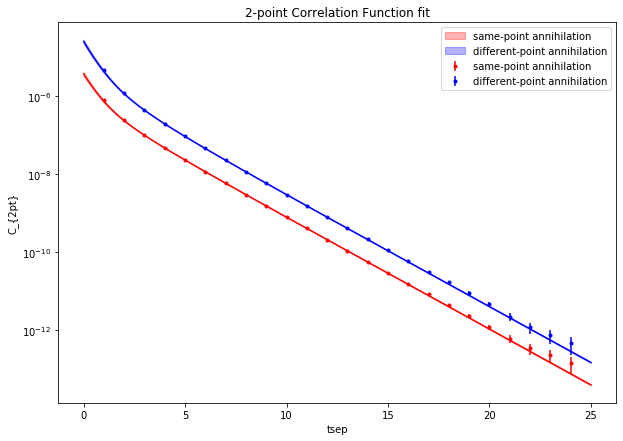

<Figure size 432x288 with 0 Axes>

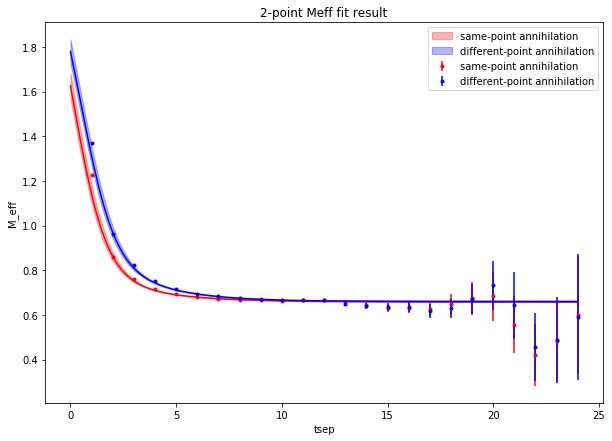

<Figure size 432x288 with 0 Axes>

In [481]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

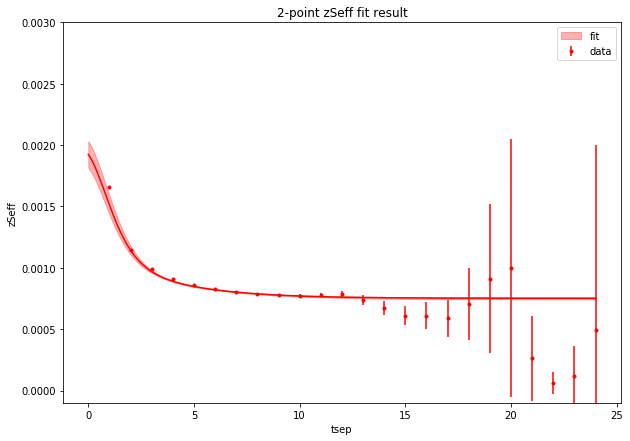

<Figure size 432x288 with 0 Axes>

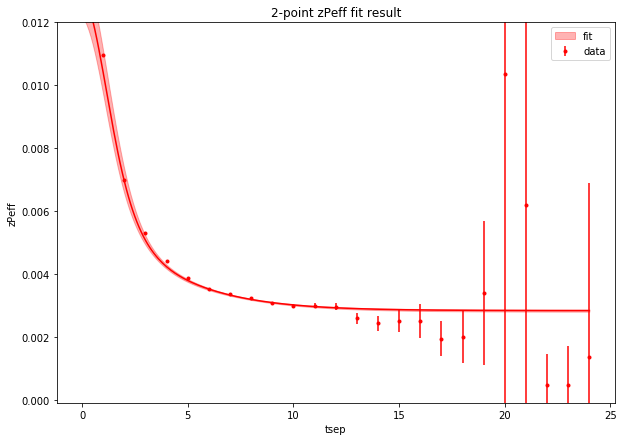

<Figure size 432x288 with 0 Axes>

In [482]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [483]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt_tau2)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

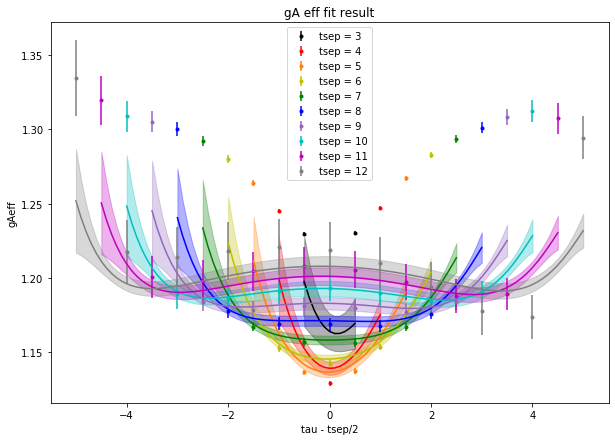

<Figure size 432x288 with 0 Axes>

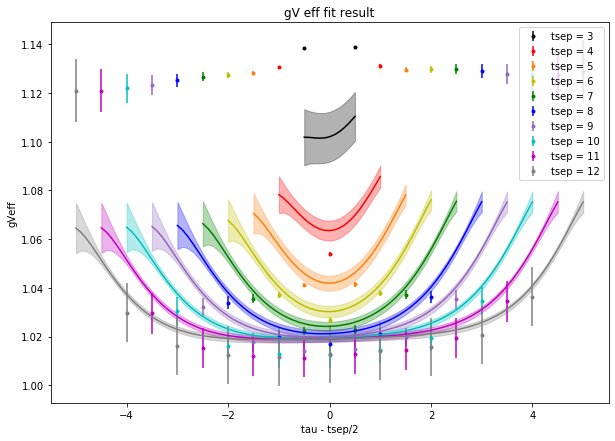

<Figure size 432x288 with 0 Axes>

In [484]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



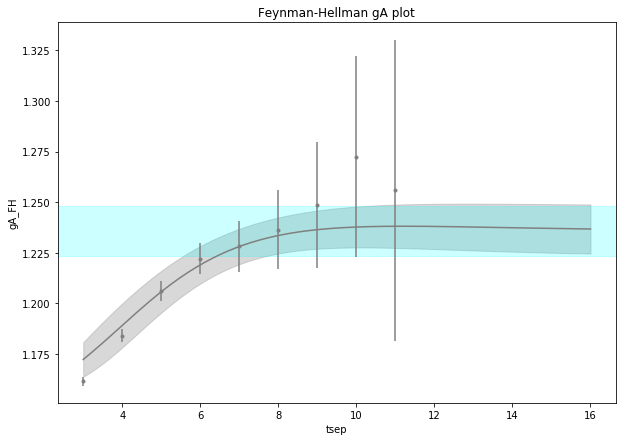

<Figure size 432x288 with 0 Axes>

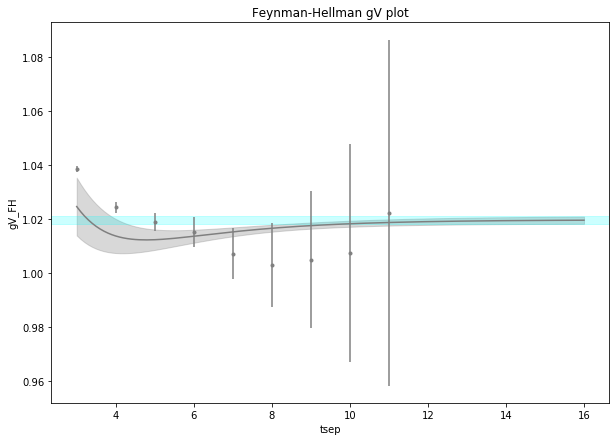

<Figure size 432x288 with 0 Axes>

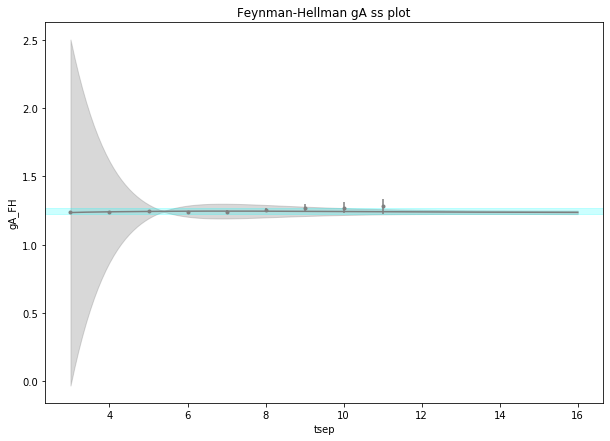

<Figure size 432x288 with 0 Axes>

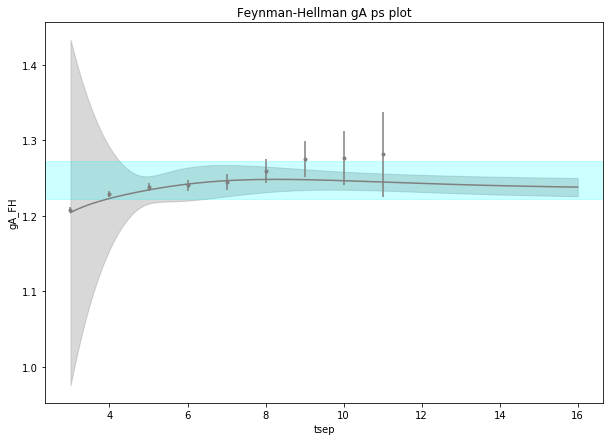

<Figure size 432x288 with 0 Axes>

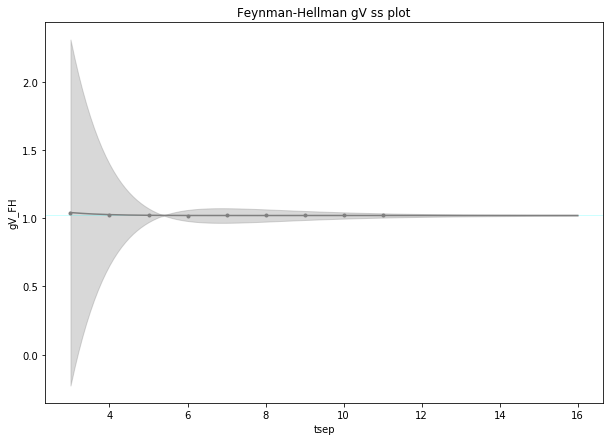

<Figure size 432x288 with 0 Axes>

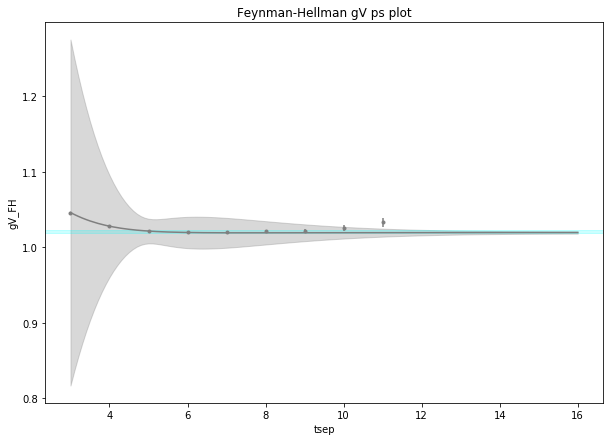

<Figure size 432x288 with 0 Axes>

In [485]:
# And finally, plot the Feynman-Hellman fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt_tau2)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt_tau2)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_3pt_tau2['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_3pt_tau2['gV4_00'], ydat_error=y_CFH_V4_err)

step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)


#CFH_A3_model = C_FH_A3(t_FH_model, post_CFHV4)
#CFH_V4_model = C_FH_V4(t_FH_model, post_CFHV4)
FH_A3_ss_model = C_FHdata_A3_ss(t_FH_model, post_3pt_tau2)
FH_A3_ps_model = C_FHdata_A3_ps(t_FH_model, post_3pt_tau2)
FH_V4_ss_model = C_FHdata_V4_ss(t_FH_model, post_3pt_tau2)
FH_V4_ps_model = C_FHdata_V4_ps(t_FH_model, post_3pt_tau2)

FH_A3_ss_model_mean = np.array([FH_A3_ss_model[i].mean for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_upbound = np.array([FH_A3_ss_model[i].mean + FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_lowbound = np.array([FH_A3_ss_model[i].mean - FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ps_model_mean = np.array([FH_A3_ps_model[i].mean for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_upbound = np.array([FH_A3_ps_model[i].mean + FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_lowbound = np.array([FH_A3_ps_model[i].mean - FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_V4_ss_model_mean = np.array([FH_V4_ss_model[i].mean for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_upbound = np.array([FH_V4_ss_model[i].mean + FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_lowbound = np.array([FH_V4_ss_model[i].mean - FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ps_model_mean = np.array([FH_V4_ps_model[i].mean for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_upbound = np.array([FH_V4_ps_model[i].mean + FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_lowbound = np.array([FH_V4_ps_model[i].mean - FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])

# Set up the raw data plotting
x_FHdata = np.array([i for i in tsep_vals[:-1] ])
y_FHdata_A3_ss = np.array([gv_avg_data['FH'][i][0].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ss_err = np.array([gv_avg_data['FH'][i][0].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps = np.array([gv_avg_data['FH'][i][1].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps_err = np.array([gv_avg_data['FH'][i][1].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss = np.array([gv_avg_data['FH'][i][2].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss_err = np.array([gv_avg_data['FH'][i][2].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps = np.array([gv_avg_data['FH'][i][3].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps_err = np.array([gv_avg_data['FH'][i][3].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])

#h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_CFHV4['gA3_00'], ydat_error=y_CFH_A3_err) 
#h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_CFHV4['gV4_00'], ydat_error=y_CFH_V4_err)

h5_dm.fit_data_plot("Feynman-Hellman gA ss plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ss, t_FH_model, FH_A3_ss_model_mean, FH_A3_ss_model_upbound, FH_A3_ss_model_lowbound, "tab:grey", g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ss_err) 
h5_dm.fit_data_plot("Feynman-Hellman gA ps plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ps, t_FH_model, FH_A3_ps_model_mean, FH_A3_ps_model_upbound, FH_A3_ps_model_lowbound, "tab:grey", g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ps_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV ss plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ss, t_FH_model, FH_V4_ss_model_mean, FH_V4_ss_model_upbound, FH_V4_ss_model_lowbound, "tab:grey", g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ss_err)
h5_dm.fit_data_plot("Feynman-Hellman gV ps plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ps, t_FH_model, FH_V4_ps_model_mean, FH_V4_ps_model_upbound, FH_V4_ps_model_lowbound, "tab:grey", g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ps_err)

#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [101]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [102]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.67, 0.02)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.0003)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.003)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.67, 0.02)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
            
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['Z1'] = gv.gvar(0.0012, 0.0006)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0, 0.01)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)


            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            if num_states_FH == 2:
                priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            else:
                priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            for n in range(num_states_FH-1):
                priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
                priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
                priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
            priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [103]:
list_LogGBF_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a0_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a1_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a2_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))


In [104]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])

In [105]:
for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[0][i][k],fcn=C_2pt,debug=True)
            fit_a1_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[1][i][k],fcn=C_2pt,debug=True)
            fit_a2_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[2][i][k],fcn=C_2pt,debug=True)
                
            fit_a0_FH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a0_2pt.p,fcn=C_FH,debug=True)
            fit_a1_FH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a1_2pt.p,fcn=C_FH,debug=True)
            fit_a2_FH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a2_2pt.p,fcn=C_FH,debug=True)
            
                
            fit_a0 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a0_FH.p,fcn=C_3pt,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a1_FH.p,fcn=C_3pt,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a2_FH.p,fcn=C_3pt,debug=True)
            
            print("dE constant, lod(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0_2pt[i][j][k] = fit_a0_2pt.logGBF
            list_LogGBF_a0_FH[i][j][k] = fit_a0_FH.logGBF
            list_LogGBF_a0_3pt[i][j][k] = fit_a0.logGBF
            list_Q_a0_2pt[i][j][k] = fit_a0_2pt.Q
            list_Q_a0_FH[i][j][k] = fit_a0_FH.Q
            list_Q_a0_3pt[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv')) 
            list_LogGBF_a1_2pt[i][j][k] = fit_a1_2pt.logGBF
            list_LogGBF_a1_FH[i][j][k] = fit_a1_FH.logGBF
            list_LogGBF_a1_3pt[i][j][k] = fit_a1.logGBF
            list_Q_a1_2pt[i][j][k] = fit_a1_2pt.Q
            list_Q_a1_FH[i][j][k] = fit_a1_FH.Q
            list_Q_a1_3pt[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a2.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2_2pt[i][j][k] = fit_a2_2pt.logGBF
            list_LogGBF_a2_FH[i][j][k] = fit_a2_FH.logGBF
            list_LogGBF_a2_3pt[i][j][k] = fit_a2.logGBF
            list_Q_a2_2pt[i][j][k] = fit_a2_2pt.Q
            list_Q_a2_FH[i][j][k] = fit_a2_FH.Q
            list_Q_a2_3pt[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 34 [130]    Q = 0    logGBF = 1315.2

Parameters:
             E0        0.680419 +- 0.00101821             [      0.660816 +- 0.0019214 ]  *****
             Z0    0.000810274 +- 2.59888e-06             [ 0.000755497 +- 6.13851e-06 ]  *****
        Ztilde0     0.00313288 +- 1.16632e-05             [  0.00285115 +- 2.87557e-05 ]  *****
       log(dE1)       -0.104039 +- 0.00783218             [     -0.822367 +- 0.0574889 ]  *****
             Z1     0.00110803 +- 5.53406e-06             [ 0.000675811 +- 3.48198e-05 ]  *****
        Ztilde1     0.00836289 +- 4.93925e-05             [  0.00457946 +- 0.000248996 ]  *****
       log(dE2)        0.829034 +- 0.00587835             [     -0.132199 +- 0.0422634 ]  *****
             Z2        0.00184 +- 6.32333e-06             [  0.00132118 +- 1.74106e-05 ]  *****
        Ztilde2      0.0138308 +- 6.25246e-05             [  0

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 64 [130]    Q = 0    logGBF = -648.88

Parameters:
             E0      0.694859 +- 0.000856856             [    0.660619 +- 0.00192935 ]  *****
             Z0   0.000804991 +- 2.01839e-06             [   0.000755 +- 6.15233e-06 ]  *****
        Ztilde0     0.00310034 +- 9.1538e-06             [  0.0028491 +- 2.87918e-05 ]  *****
       log(dE1)      -0.364417 +- 0.00594269             [    -0.821677 +- 0.0575101 ]  *****
             Z1   0.000975956 +- 6.09661e-06             [ 0.000677952 +- 3.4937e-05 ]  *****
        Ztilde1    0.00742603 +- 4.57522e-05             [ 0.00458802 +- 0.000249311 ]  *****
       log(dE2)       0.748619 +- 0.00217448             [    -0.129146 +- 0.0424151 ]  *****
             Z2    0.00180154 +- 4.91229e-06             [ 0.00132185 +- 1.74364e-05 ]  *****
        Ztilde2     0.0133717 +- 5.80023e-05             [ 0.00982509 +- 0.00

Least Square Fit:
  chi2/dof [dof] = 1.4e+02 [130]    Q = 0    logGBF = -5543.4

Parameters:
             E0        0.708843 +- 0.00065478             [      0.660888 +- 0.00195431 ]  *****
             Z0    0.000816411 +- 1.49481e-06             [   0.00075563 +- 6.26982e-06 ]  *****
        Ztilde0     0.00307546 +- 7.17079e-06             [   0.00285076 +- 2.92911e-05 ]  *****
       log(dE1)        -1.25837 +- 0.00912987             [       -0.839317 +- 0.058978 ]  *****
             Z1   -0.000336024 +- 2.69659e-06             [ -0.000663182 +- 3.51473e-05 ]  *****
        Ztilde1    -0.00346586 +- 4.54637e-05             [   -0.0044951 +- 0.000247703 ]  ****
       log(dE2)        0.757943 +- 0.00117244             [      -0.146886 +- 0.0403333 ]  *****
             Z2    -0.00209943 +- 3.39609e-06             [    -0.00131642 +- 1.584e-05 ]  *****
        Ztilde2     -0.0143787 +- 5.63635e-05             [  -0.00976049 +- 0.000173762 ]  *****
         gA3_00         1.27748 +- 

Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 1.6e-20    logGBF = 3289.2

Parameters:
             E0       0.661482 +- 0.00188257             [     0.659821 +- 0.00253669 ]  
             Z0    0.00075835 +- 6.25128e-06             [ 0.000751426 +- 9.04063e-06 ]  
        Ztilde0     0.00286717 +- 2.7143e-05             [  0.00283388 +- 3.99427e-05 ]  
       log(dE1)         -0.768218 +- 0.03072             [     -0.855647 +- 0.0689142 ]  *
             Z1   0.000682528 +- 1.87167e-05             [  0.000670074 +- 3.4595e-05 ]  
        Ztilde1     0.0046938 +- 0.000131237             [  0.00441156 +- 0.000287246 ]  
       log(dE2)       -0.573237 +- 0.0355619             [      -0.231307 +- 0.125956 ]  **
             Z2   0.000895574 +- 5.71074e-05             [ 0.000819858 +- 0.000438952 ]  
        Ztilde2    -0.000465752 +- 0.0020139             [   0.00779803 +- 0.00362844 ]  **
       log(dE3)         1.27629 +- 0.0379918             [       -1.74667 +- 0.682365 ]  **

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.9 [130]    Q = 1.8e-25    logGBF = 3264.4

Parameters:
             E0       0.661432 +- 0.00208477             [     0.660242 +- 0.00306407 ]  
             Z0    0.00075894 +- 7.36277e-06             [ 0.000752873 +- 1.14771e-05 ]  
        Ztilde0    0.00287427 +- 3.16429e-05             [  0.00283948 +- 4.90961e-05 ]  
       log(dE1)        -0.90981 +- 0.0552096             [     -0.961516 +- 0.0952902 ]  
             Z1   0.000495855 +- 3.14925e-05             [ 0.000555684 +- 9.38158e-05 ]  
        Ztilde1     0.00342011 +- 0.00020063             [  0.00363875 +- 0.000559626 ]  
       log(dE2)        -0.45654 +- 0.0551701             [      -0.772796 +- 0.487269 ]  
             Z2    0.00146454 +- 4.43437e-05             [  0.000780408 +- 0.00029626 ]  **
        Ztilde2      0.0102605 +- 0.00039583             [    0.00576553 +- 0.0021701 ]  **
       lo

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [130]    Q = 0.026    logGBF = 3348

Parameters:
             E0        0.65606 +- 0.00230165             [     0.660069 +- 0.00317701 ]  *
             Z0    0.000736063 +- 8.4716e-06             [  0.000751637 +- 1.2218e-05 ]  *
        Ztilde0    0.00276728 +- 3.59119e-05             [  0.00283544 +- 5.14467e-05 ]  *
       log(dE1)       -0.896122 +- 0.0497607             [     -0.977208 +- 0.0971395 ]  
             Z1   0.000710443 +- 2.89431e-05             [ 0.000559497 +- 8.30734e-05 ]  *
        Ztilde1    0.00448345 +- 0.000213475             [   0.00355008 +- 0.00052811 ]  *
       log(dE2)        0.172536 +- 0.0612808             [      -0.727631 +- 0.423573 ]  **
             Z2    0.00123013 +- 9.25047e-05             [ 0.000758596 +- 0.000314324 ]  *
        Ztilde2      0.0105611 +- 0.00108505             [    0.00635884 +- 0.0025323 ]  *
       l

Least Square Fit:
  chi2/dof [dof] = 1.1e+03 [130]    Q = 0    logGBF = -67348

Parameters:
             E0       0.575211 +- 0.000906336             [       0.65593 +- 0.00206448 ]  *****
             Z0    0.000137328 +- 2.61766e-06             [  0.000704038 +- 5.86834e-06 ]  *****
        Ztilde0    0.000808496 +- 1.34291e-05             [    0.0027221 +- 2.57392e-05 ]  *****
       log(dE1)         -1.11066 +- 0.0698985             [      -0.966879 +- 0.0772731 ]  *
             Z1     7.17158e-05 +- 5.9603e-05             [  0.000111497 +- 8.49932e-05 ]  
        Ztilde1      -0.0486324 +- 0.00710866             [    -0.0149861 +- 0.00990761 ]  ***
       log(dE2)          -1.63827 +- 0.336357             [        -2.35764 +- 0.404322 ]  *
             Z2   -0.000244666 +- 0.000314604             [  1.98771e-05 +- 0.000569782 ]  
        Ztilde2       0.0150765 +- 0.00998418             [   -0.00187666 +- 0.00999035 ]  *
       log(dE3)           -2.8591 +- 0.624283             [

Least Square Fit:
  chi2/dof [dof] = 1.4 [130]    Q = 0.0028    logGBF = 3347.4

Parameters:
             E0       0.655964 +- 0.00226386             [      0.65964 +- 0.00323243 ]  *
             Z0    0.00073619 +- 8.26847e-06             [ 0.000750374 +- 1.23347e-05 ]  *
        Ztilde0     0.00277179 +- 3.5072e-05             [   0.00283076 +- 5.1635e-05 ]  *
       log(dE1)       -0.859049 +- 0.0498843             [     -0.948739 +- 0.0951891 ]  
             Z1    0.00074292 +- 2.98391e-05             [ 0.000582579 +- 9.20799e-05 ]  *
        Ztilde1    0.00462098 +- 0.000230608             [  0.00367724 +- 0.000577067 ]  *
       log(dE2)          0.17054 +- 0.065615             [      -0.919497 +- 0.539386 ]  **
             Z2    0.00086959 +- 9.51871e-05             [ 0.000589873 +- 0.000333184 ]  
        Ztilde2    0.00851928 +- 0.000812692             [   0.00503317 +- 0.00189126 ]  *
       log(dE3)          -1.10325 +- 0.16384             [       -0.535264 +- 0.34751 ]  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.4 [130]    Q = 0.0013    logGBF = 3311.1

Parameters:
             E0        0.670534 +- 0.00260189             [     0.660326 +- 0.00322377 ]  ***
             Z0    0.000785807 +- 1.00118e-05             [ 0.000752711 +- 1.24671e-05 ]  **
        Ztilde0     0.00296509 +- 4.29549e-05             [  0.00283974 +- 5.24718e-05 ]  **
       log(dE1)         -1.55577 +- 0.0662923             [       -0.98111 +- 0.097497 ]  *****
             Z1   -5.04254e-05 +- 2.65316e-05             [ 0.000548261 +- 8.92643e-05 ]  *****
        Ztilde1   -4.47073e-06 +- 0.000243725             [  0.00351179 +- 0.000535953 ]  *****
       log(dE2)          -2.07685 +- 0.140609             [      -0.747176 +- 0.439064 ]  ***
             Z2    0.000558725 +- 7.69094e-05             [ 0.000764572 +- 0.000309031 ]  
        Ztilde2      0.00078447 +- 0.00147034             [   0.0062130

Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.044    logGBF = 3322.5

Parameters:
             E0        0.660471 +- 0.00258279             [      0.659571 +- 0.0031633 ]  
             Z0    0.000752762 +- 9.57737e-06             [ 0.000749764 +- 1.21185e-05 ]  
        Ztilde0     0.00285314 +- 4.08201e-05             [   0.00282831 +- 5.0632e-05 ]  
       log(dE1)        -0.989943 +- 0.0799129             [      -0.952058 +- 0.095198 ]  
             Z1    0.000490785 +- 4.43022e-05             [ 0.000589836 +- 8.05927e-05 ]  *
        Ztilde1      0.00251561 +- 0.00040541             [  0.00368435 +- 0.000542724 ]  **
       log(dE2)          -2.66916 +- 0.298133             [      -0.857539 +- 0.500549 ]  ***
             Z2   -0.000191062 +- 0.000150514             [ 0.000578695 +- 0.000373129 ]  **
        Ztilde2    -1.14572e-05 +- 0.00167919             [   0.00543052 +- 0.00231987 ]  **
       log(dE3)         -0.116236 +- 0.104186             [      -0.731262 +- 0

Least Square Fit:
  chi2/dof [dof] = 5.3e+03 [130]    Q = 0    logGBF = -3.3795e+05

Parameters:
             E0       0.641135 +- 0.000751121             [      0.656413 +- 0.00202248 ]  *****
             Z0    0.000294674 +- 2.22024e-06             [  0.000710073 +- 5.71452e-06 ]  *****
        Ztilde0     0.00136388 +- 1.23905e-05             [   0.00273745 +- 2.58187e-05 ]  *****
       log(dE1)         -0.943057 +- 0.070284             [      -0.967444 +- 0.0868482 ]  
             Z1   -0.000162134 +- 7.49274e-05             [    8.92887e-05 +- 9.712e-05 ]  **
        Ztilde1      -0.0195632 +- 0.00921287             [    -0.0126363 +- 0.00992342 ]  
       log(dE2)          -2.35203 +- 0.409349             [        -2.35812 +- 0.431215 ]  
             Z2   -0.000164642 +- 0.000190232             [   0.00011148 +- 0.000289329 ]  
        Ztilde2      -0.0104047 +- 0.00965362             [   -0.00716634 +- 0.00985083 ]  
       log(dE3)          -3.16861 +- 0.636599             

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3334.6

Parameters:
             E0        0.662238 +- 0.00299358             [     0.659884 +- 0.00328238 ]  
             Z0      0.000759059 +- 1.153e-05             [ 0.000751134 +- 1.26713e-05 ]  
        Ztilde0     0.00286484 +- 4.84663e-05             [  0.00283357 +- 5.32041e-05 ]  
       log(dE1)        -0.989332 +- 0.0890428             [     -0.980889 +- 0.0970164 ]  
             Z1    0.000512131 +- 7.64706e-05             [ 0.000557741 +- 9.00309e-05 ]  
        Ztilde1     0.00338749 +- 0.000427842             [  0.00352727 +- 0.000533662 ]  
       log(dE2)         -0.737532 +- 0.276412             [      -0.728006 +- 0.439314 ]  
             Z2    0.000743044 +- 0.000174067             [ 0.000753181 +- 0.000309466 ]  
        Ztilde2      0.00656164 +- 0.00208675             [   0.00640567 +- 0.00277371 ]  
      

Least Square Fit:
  chi2/dof [dof] = 1e+04 [130]    Q = 0    logGBF = -6.434e+05

Parameters:
             E0         0.634337 +- 0.0011442             [     0.659312 +- 0.00320859 ]  *****
             Z0    0.000361633 +- 5.72628e-06             [ 0.000748943 +- 1.22685e-05 ]  *****
        Ztilde0     0.00176393 +- 2.51046e-05             [  0.00282526 +- 5.11565e-05 ]  *****
       log(dE1)        -0.893663 +- 0.0739396             [     -0.948352 +- 0.0947406 ]  
             Z1    0.000398036 +- 5.00601e-05             [ 0.000596784 +- 8.11298e-05 ]  **
        Ztilde1     0.00188009 +- 0.000408123             [  0.00370522 +- 0.000540429 ]  ***
       log(dE2)         -0.830565 +- 0.345868             [      -0.859998 +- 0.500416 ]  
             Z2    0.000192344 +- 0.000168976             [ 0.000556434 +- 0.000375152 ]  
        Ztilde2      0.00280338 +- 0.00194337             [   0.00548628 +- 0.00232184 ]  *
       log(dE3)          -0.775661 +- 0.33137             [       

Least Square Fit:
  chi2/dof [dof] = 4.9e+03 [130]    Q = 0    logGBF = -3.1254e+05

Parameters:
             E0        0.638282 +- 0.00073896             [      0.656349 +- 0.00201893 ]  *****
             Z0    0.000279984 +- 2.18699e-06             [  0.000709949 +- 5.70418e-06 ]  *****
        Ztilde0     0.00133344 +- 1.22049e-05             [   0.00273628 +- 2.58212e-05 ]  *****
       log(dE1)        -0.942222 +- 0.0765329             [      -0.962926 +- 0.0863084 ]  
             Z1    -0.00010343 +- 7.59227e-05             [  8.24369e-05 +- 9.59197e-05 ]  *
        Ztilde1      -0.0246565 +- 0.00909286             [    -0.0134669 +- 0.00985743 ]  *
       log(dE2)          -2.37191 +- 0.416446             [        -2.37722 +- 0.430345 ]  
             Z2   -0.000179909 +- 0.000190078             [  0.000122392 +- 0.000284753 ]  *
        Ztilde2      -0.0122318 +- 0.00963033             [   -0.00732889 +- 0.00984949 ]  
       log(dE3)          -3.17033 +- 0.634782            

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.81 [130]    Q = 0.94    logGBF = 3337.2

Parameters:
             E0        0.66505 +- 0.00270498             [     0.660623 +- 0.00326246 ]  *
             Z0   0.000771061 +- 1.01814e-05             [ 0.000753976 +- 1.26602e-05 ]  *
        Ztilde0    0.00291392 +- 4.28093e-05             [  0.00284455 +- 5.32856e-05 ]  *
       log(dE1)        -1.01922 +- 0.0850222             [     -0.981853 +- 0.0975556 ]  
             Z1   0.000377253 +- 6.39255e-05             [  0.00053839 +- 9.51123e-05 ]  *
        Ztilde1    0.00290344 +- 0.000404726             [   0.0035019 +- 0.000536512 ]  *
       log(dE2)         -1.29629 +- 0.185501             [      -0.747453 +- 0.431812 ]  *
             Z2   0.000710613 +- 0.000142073             [ 0.000790191 +- 0.000293883 ]  
        Ztilde2      0.0030423 +- 0.00156292             [   0.00614573 +- 0.00274583 ]  *
       l

Least Square Fit:
  chi2/dof [dof] = 1.5e+04 [130]    Q = 0    logGBF = -9.7477e+05

Parameters:
             E0        0.642179 +- 0.00106007             [      0.659396 +- 0.0031294 ]  *****
             Z0    0.000323663 +- 5.37443e-06             [ 0.000749009 +- 1.19845e-05 ]  *****
        Ztilde0     0.00176064 +- 2.34252e-05             [  0.00282542 +- 5.00591e-05 ]  *****
       log(dE1)         -0.95281 +- 0.0670465             [     -0.951523 +- 0.0948389 ]  
             Z1    0.000232841 +- 5.09135e-05             [ 0.000597249 +- 7.35762e-05 ]  ****
        Ztilde1    -0.00143283 +- 0.000418051             [  0.00369959 +- 0.000522933 ]  *****
       log(dE2)         -0.826947 +- 0.307544             [      -0.826157 +- 0.478072 ]  
             Z2    0.000202615 +- 0.000164463             [ 0.000556006 +- 0.000396676 ]  
        Ztilde2      0.00251231 +- 0.00230937             [   0.00576703 +- 0.00286251 ]  *
       log(dE3)          -0.91318 +- 0.429031             [

Least Square Fit:
  chi2/dof [dof] = 5.5e+03 [130]    Q = 0    logGBF = -3.5205e+05

Parameters:
             E0       0.649732 +- 0.000750069             [      0.657319 +- 0.00198388 ]  ***
             Z0     0.000309193 +- 2.2109e-06             [  0.000715143 +- 5.58753e-06 ]  *****
        Ztilde0     0.00137147 +- 1.23366e-05             [   0.00275182 +- 2.54449e-05 ]  *****
       log(dE1)         -0.968197 +- 0.073282             [      -0.968326 +- 0.0883351 ]  
             Z1   -0.000147894 +- 7.41089e-05             [  7.29037e-05 +- 9.93462e-05 ]  **
        Ztilde1      -0.0111604 +- 0.00916028             [    -0.0105433 +- 0.00992865 ]  
       log(dE2)          -2.35852 +- 0.420855             [        -2.35858 +- 0.436364 ]  
             Z2   -0.000122953 +- 0.000170489             [  0.000135892 +- 0.000214124 ]  *
        Ztilde2     -0.00993413 +- 0.00955422             [   -0.00904668 +- 0.00983515 ]  
       log(dE3)          -3.17152 +- 0.636487             [

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.77 [130]    Q = 0.98    logGBF = 3340.6

Parameters:
             E0       0.664066 +- 0.00271831             [     0.660159 +- 0.00332571 ]  *
             Z0   0.000767213 +- 1.02058e-05             [ 0.000752298 +- 1.28841e-05 ]  *
        Ztilde0    0.00289854 +- 4.28531e-05             [  0.00283796 +- 5.40977e-05 ]  *
       log(dE1)       -0.999806 +- 0.0875846             [      -0.98115 +- 0.0970656 ]  
             Z1    0.000419882 +- 6.7894e-05             [ 0.000549404 +- 9.60614e-05 ]  *
        Ztilde1    0.00307386 +- 0.000419725             [  0.00352343 +- 0.000534382 ]  
       log(dE2)         -1.18223 +- 0.211577             [      -0.721029 +- 0.432621 ]  *
             Z2   0.000698012 +- 0.000154283             [  0.00078384 +- 0.000294011 ]  
        Ztilde2     0.00369019 +- 0.00169036             [   0.00636305 +- 0.00275627 ]  
       log

Least Square Fit:
  chi2/dof [dof] = 1.3e+04 [130]    Q = 0    logGBF = -8.4289e+05

Parameters:
             E0        0.640315 +- 0.00111052             [     0.659147 +- 0.00317104 ]  *****
             Z0    0.000328683 +- 5.45892e-06             [ 0.000748228 +- 1.21195e-05 ]  *****
        Ztilde0     0.00175984 +- 2.40193e-05             [  0.00282255 +- 5.05259e-05 ]  *****
       log(dE1)        -0.948876 +- 0.0647609             [     -0.948274 +- 0.0944073 ]  
             Z1     0.00030368 +- 3.83094e-05             [ 0.000603463 +- 7.40472e-05 ]  ****
        Ztilde1    0.000125313 +- 0.000350394             [  0.00371656 +- 0.000520848 ]  *****
       log(dE2)          -0.828668 +- 0.25135             [      -0.828069 +- 0.477989 ]  
             Z2     0.00016825 +- 0.000130017             [ 0.000533534 +- 0.000398555 ]  
        Ztilde2      0.00307273 +- 0.00212093             [   0.00588061 +- 0.00286829 ]  
       log(dE3)         -0.926904 +- 0.365508             [ 

Least Square Fit:
  chi2/dof [dof] = 5.1e+03 [130]    Q = 0    logGBF = -3.2496e+05

Parameters:
             E0       0.645551 +- 0.000732834             [      0.657281 +- 0.00197694 ]  *****
             Z0    0.000293551 +- 2.17003e-06             [  0.000715051 +- 5.56487e-06 ]  *****
        Ztilde0     0.00132526 +- 1.20435e-05             [   0.00275188 +- 2.53432e-05 ]  *****
       log(dE1)        -0.963559 +- 0.0787842             [       -0.963556 +- 0.087656 ]  
             Z1    -8.64186e-05 +- 7.6195e-05             [  6.87641e-05 +- 0.000102137 ]  *
        Ztilde1       -0.012054 +- 0.00890344             [     -0.0114094 +- 0.0098413 ]  
       log(dE2)          -2.38137 +- 0.425512             [        -2.38139 +- 0.434836 ]  
             Z2     -0.0001439 +- 0.000169956             [   0.000134661 +- 0.00021471 ]  *
        Ztilde2     -0.00995802 +- 0.00957911             [   -0.00920295 +- 0.00985843 ]  
       log(dE3)          -3.16952 +- 0.635344             

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.9 [90]    Q = 1.7e-06    logGBF = 2329.3

Parameters:
             E0       0.660932 +- 0.00174574             [      0.660816 +- 0.0019214 ]  
             Z0   0.000752979 +- 5.55284e-06             [ 0.000755497 +- 6.13851e-06 ]  
        Ztilde0    0.00282926 +- 2.58456e-05             [  0.00285115 +- 2.87557e-05 ]  
       log(dE1)       -0.991488 +- 0.0315327             [     -0.822367 +- 0.0574889 ]  **
             Z1   0.000561023 +- 1.29703e-05             [ 0.000675811 +- 3.48198e-05 ]  ***
        Ztilde1    0.00376423 +- 0.000100514             [  0.00457946 +- 0.000248996 ]  ***
       log(dE2)       -0.264206 +- 0.0191607             [     -0.132199 +- 0.0422634 ]  ***
             Z2    0.00127593 +- 1.16083e-05             [  0.00132118 +- 1.74106e-05 ]  **
        Ztilde2    0.00934765 +- 0.000121701             [  0.00981464 +- 0.000187213 ]  **

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.9 [90]    Q = 2.2e-07    logGBF = 2351.1

Parameters:
             E0       0.658478 +- 0.00145542             [    0.660619 +- 0.00192935 ]  *
             Z0    0.000744351 +- 4.3162e-06             [   0.000755 +- 6.15233e-06 ]  *
        Ztilde0    0.00279011 +- 1.98268e-05             [  0.0028491 +- 2.87918e-05 ]  **
       log(dE1)        -1.00721 +- 0.0233765             [    -0.821677 +- 0.0575101 ]  ***
             Z1   0.000583383 +- 1.04175e-05             [ 0.000677952 +- 3.4937e-05 ]  **
        Ztilde1    0.00378523 +- 8.32391e-05             [ 0.00458802 +- 0.000249311 ]  ***
       log(dE2)        -0.23395 +- 0.0121986             [    -0.129146 +- 0.0424151 ]  **
             Z2    0.00127413 +- 9.88412e-06             [ 0.00132185 +- 1.74364e-05 ]  **
        Ztilde2    0.00947043 +- 9.11503e-05             [ 0.00982509 +- 0.000187701 ]  *
      

Least Square Fit:
  chi2/dof [dof] = 2 [90]    Q = 1.4e-07    logGBF = 2348.4

Parameters:
             E0         0.65646 +- 0.00117926             [      0.660888 +- 0.00195431 ]  **
             Z0    0.000738063 +- 3.11638e-06             [   0.00075563 +- 6.26982e-06 ]  **
        Ztilde0     0.00276179 +- 1.39224e-05             [   0.00285076 +- 2.92911e-05 ]  ***
       log(dE1)         -1.02726 +- 0.0158337             [       -0.839317 +- 0.058978 ]  ***
             Z1   -0.000592241 +- 8.73071e-06             [ -0.000663182 +- 3.51473e-05 ]  **
        Ztilde1    -0.00375438 +- 7.06445e-05             [   -0.0044951 +- 0.000247703 ]  **
       log(dE2)        -0.21914 +- 0.00635419             [      -0.146886 +- 0.0403333 ]  *
             Z2    -0.00127403 +- 8.47168e-06             [    -0.00131642 +- 1.584e-05 ]  **
        Ztilde2    -0.00954574 +- 6.87146e-05             [  -0.00976049 +- 0.000173762 ]  *
         gA3_00         1.26027 +- 0.00572896             [    

Least Square Fit:
  chi2/dof [dof] = 1.3 [90]    Q = 0.024    logGBF = 2340.2

Parameters:
             E0       0.658222 +- 0.00231623             [     0.659821 +- 0.00253669 ]  
             Z0   0.000745009 +- 8.20439e-06             [ 0.000751426 +- 9.04063e-06 ]  
        Ztilde0    0.00280501 +- 3.62323e-05             [  0.00283388 +- 3.99427e-05 ]  
       log(dE1)       -0.873652 +- 0.0596417             [     -0.855647 +- 0.0689142 ]  
             Z1   0.000677414 +- 2.94678e-05             [  0.000670074 +- 3.4595e-05 ]  
        Ztilde1    0.00437691 +- 0.000243737             [  0.00441156 +- 0.000287246 ]  
       log(dE2)      -0.0625796 +- 0.0735842             [      -0.231307 +- 0.125956 ]  *
             Z2    0.00148262 +- 0.000295208             [ 0.000819858 +- 0.000438952 ]  *
        Ztilde2      0.0122819 +- 0.00277151             [   0.00779803 +- 0.00362844 ]  *
       log(dE3)         -1.78337 +- 0.529204             [       -1.74667 +- 0.682365 ]  
      

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.29    logGBF = 2346.6

Parameters:
             E0        0.661395 +- 0.0026238             [     0.660242 +- 0.00306407 ]  
             Z0   0.000755727 +- 9.64742e-06             [ 0.000752873 +- 1.14771e-05 ]  
        Ztilde0    0.00284655 +- 4.13521e-05             [  0.00283948 +- 4.90961e-05 ]  
       log(dE1)        -1.10529 +- 0.0839144             [     -0.961516 +- 0.0952902 ]  *
             Z1   0.000404608 +- 7.33641e-05             [ 0.000555684 +- 9.38158e-05 ]  *
        Ztilde1    0.00266778 +- 0.000446598             [  0.00363875 +- 0.000559626 ]  *
       log(dE2)         -1.70799 +- 0.224655             [      -0.772796 +- 0.487269 ]  *
             Z2   0.000231427 +- 7.29725e-05             [  0.000780408 +- 0.00029626 ]  *
        Ztilde2    0.00129036 +- 0.000705006             [    0.00576553 +- 0.0021701 ]  **
       log

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.8 [90]    Q = 0.92    logGBF = 2335.7

Parameters:
             E0        0.66153 +- 0.00296978             [     0.660069 +- 0.00317701 ]  
             Z0   0.000756761 +- 1.13202e-05             [  0.000751637 +- 1.2218e-05 ]  
        Ztilde0    0.00285663 +- 4.78666e-05             [  0.00283544 +- 5.14467e-05 ]  
       log(dE1)        -1.02803 +- 0.0884725             [     -0.977208 +- 0.0971395 ]  
             Z1     0.0004754 +- 7.16279e-05             [ 0.000559497 +- 8.30734e-05 ]  *
        Ztilde1    0.00305972 +- 0.000444188             [   0.00355008 +- 0.00052811 ]  
       log(dE2)         -1.13066 +- 0.305685             [      -0.727631 +- 0.423573 ]  
             Z2   0.000605074 +- 0.000194267             [ 0.000758596 +- 0.000314324 ]  
        Ztilde2      0.0042123 +- 0.00206613             [    0.00635884 +- 0.0025323 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2341

Parameters:
             E0       0.660869 +- 0.00299981             [     0.659654 +- 0.00323094 ]  
             Z0   0.000754332 +- 1.14141e-05             [  0.000750183 +- 1.2402e-05 ]  
        Ztilde0    0.00284738 +- 4.81868e-05             [  0.00282978 +- 5.20993e-05 ]  
       log(dE1)        -1.01434 +- 0.0897602             [     -0.977368 +- 0.0966726 ]  
             Z1   0.000499606 +- 7.38079e-05             [ 0.000567318 +- 8.36767e-05 ]  
        Ztilde1     0.00314601 +- 0.00044898             [  0.00355915 +- 0.000525777 ]  
       log(dE2)         -1.11036 +- 0.304081             [      -0.718329 +- 0.423434 ]  
             Z2    0.000555296 +- 0.00019475             [  0.000742167 +- 0.00031517 ]  
        Ztilde2      0.00441263 +- 0.0020683             [   0.00649586 +- 0.00253686 ]  
       log(dE3)   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.79 [90]    Q = 0.93    logGBF = 2332.1

Parameters:
             E0       0.661839 +- 0.00300321             [     0.660326 +- 0.00322377 ]  
             Z0    0.000758174 +- 1.1518e-05             [ 0.000752711 +- 1.24671e-05 ]  
        Ztilde0     0.00286209 +- 4.8576e-05             [  0.00283974 +- 5.24718e-05 ]  
       log(dE1)        -1.05515 +- 0.0908555             [       -0.98111 +- 0.097497 ]  
             Z1   0.000435622 +- 7.53582e-05             [ 0.000548261 +- 8.92643e-05 ]  *
        Ztilde1    0.00283287 +- 0.000462835             [  0.00351179 +- 0.000535953 ]  *
       log(dE2)          -1.35953 +- 0.32663             [      -0.747176 +- 0.439064 ]  *
             Z2   0.000458184 +- 0.000230976             [ 0.000764572 +- 0.000309031 ]  
        Ztilde2     0.00289431 +- 0.00223288             [   0.00621309 +- 0.00276589 ]  *
       log(d

Least Square Fit:
  chi2/dof [dof] = 5.2e+02 [90]    Q = 0    logGBF = -20843

Parameters:
             E0        0.657327 +- 0.00151703             [      0.656413 +- 0.00202248 ]  
             Z0    0.000529412 +- 4.59871e-06             [  0.000710073 +- 5.71452e-06 ]  *****
        Ztilde0     0.00201296 +- 2.10201e-05             [   0.00273745 +- 2.58187e-05 ]  *****
       log(dE1)        -0.957342 +- 0.0763239             [      -0.967444 +- 0.0868482 ]  
             Z1   -0.000156295 +- 8.23744e-05             [    8.92887e-05 +- 9.712e-05 ]  **
        Ztilde1      -0.0527938 +- 0.00954213             [    -0.0126363 +- 0.00992342 ]  ****
       log(dE2)          -2.35497 +- 0.415982             [        -2.35812 +- 0.431215 ]  
             Z2   -0.000400803 +- 0.000213745             [   0.00011148 +- 0.000289329 ]  *
        Ztilde2      -0.0260665 +- 0.00969444             [   -0.00716634 +- 0.00985083 ]  *
       log(dE3)          -3.16927 +- 0.620475             [    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2338.9

Parameters:
             E0       0.661064 +- 0.00304351             [     0.659884 +- 0.00328238 ]  
             Z0   0.000755159 +- 1.16626e-05             [ 0.000751134 +- 1.26713e-05 ]  
        Ztilde0    0.00285031 +- 4.90828e-05             [  0.00283357 +- 5.32041e-05 ]  
       log(dE1)        -1.01876 +- 0.0903817             [     -0.980889 +- 0.0970164 ]  
             Z1   0.000489316 +- 7.73889e-05             [ 0.000557741 +- 9.00309e-05 ]  
        Ztilde1    0.00312098 +- 0.000456704             [  0.00352727 +- 0.000533662 ]  
       log(dE2)         -1.13037 +- 0.316898             [      -0.728006 +- 0.439314 ]  
             Z2   0.000531536 +- 0.000205862             [ 0.000753181 +- 0.000309466 ]  
        Ztilde2     0.00416217 +- 0.00221196             [   0.00640567 +- 0.00277371 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.77 [90]    Q = 0.95    logGBF = 2339.8

Parameters:
             E0        0.660146 +- 0.0029752             [     0.659312 +- 0.00320859 ]  
             Z0   0.000751488 +- 1.12815e-05             [ 0.000748943 +- 1.22685e-05 ]  
        Ztilde0    0.00283631 +- 4.75033e-05             [  0.00282526 +- 5.11565e-05 ]  
       log(dE1)       -0.977733 +- 0.0880331             [     -0.948352 +- 0.0947406 ]  
             Z1    0.000548356 +- 7.1559e-05             [ 0.000596784 +- 8.11298e-05 ]  
        Ztilde1    0.00335674 +- 0.000483128             [  0.00370522 +- 0.000540429 ]  
       log(dE2)         -1.15953 +- 0.411225             [      -0.859998 +- 0.500416 ]  
             Z2    0.00050177 +- 0.000267652             [ 0.000556434 +- 0.000375152 ]  
        Ztilde2     0.00481206 +- 0.00214784             [   0.00548628 +- 0.00232184 ]  
       log(dE3)        -0.556539 +- 0.386102             [       -0.746526 +- 0.43772 ]  
         

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.8 [90]    Q = 0.92    logGBF = 2331.3

Parameters:
             E0       0.662517 +- 0.00300369             [     0.660623 +- 0.00326246 ]  
             Z0   0.000761123 +- 1.15224e-05             [ 0.000753976 +- 1.26602e-05 ]  
        Ztilde0    0.00287326 +- 4.85732e-05             [  0.00284455 +- 5.32856e-05 ]  
       log(dE1)        -1.05334 +- 0.0908953             [     -0.981853 +- 0.0975556 ]  
             Z1   0.000414143 +- 7.82362e-05             [  0.00053839 +- 9.51123e-05 ]  *
        Ztilde1    0.00283521 +- 0.000459075             [   0.0035019 +- 0.000536512 ]  *
       log(dE2)         -1.34684 +- 0.317748             [      -0.747453 +- 0.431812 ]  *
             Z2    0.00050211 +- 0.000226474             [ 0.000790191 +- 0.000293883 ]  
        Ztilde2      0.0028379 +- 0.00218081             [   0.00614573 +- 0.00274583 ]  *
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.84 [90]    Q = 0.86    logGBF = 2330

Parameters:
             E0        0.660601 +- 0.00296244             [      0.659396 +- 0.0031294 ]  
             Z0    0.000753037 +- 1.12878e-05             [ 0.000749009 +- 1.19845e-05 ]  
        Ztilde0      0.00284171 +- 4.7481e-05             [  0.00282542 +- 5.00591e-05 ]  
       log(dE1)        -0.991227 +- 0.0847919             [     -0.951523 +- 0.0948389 ]  
             Z1    0.000533111 +- 6.16427e-05             [ 0.000597249 +- 7.35762e-05 ]  
        Ztilde1     0.00331342 +- 0.000438925             [  0.00369959 +- 0.000522933 ]  
       log(dE2)          -1.05922 +- 0.384818             [      -0.826157 +- 0.478072 ]  
             Z2    0.000611234 +- 0.000292997             [ 0.000556006 +- 0.000396676 ]  
        Ztilde2      0.00504432 +- 0.00268039             [   0.00576703 +- 0.00286251 ]  
       log(dE3)          -0.700303 +- 0.43471             [      -0.912653 +- 0.495402 ]  
 

Least Square Fit:
  chi2/dof [dof] = 6.2e+02 [90]    Q = 0    logGBF = -25548

Parameters:
             E0        0.647128 +- 0.00131411             [      0.657319 +- 0.00198388 ]  *****
             Z0    0.000473546 +- 4.12437e-06             [  0.000715143 +- 5.58753e-06 ]  *****
        Ztilde0     0.00172296 +- 1.90228e-05             [   0.00275182 +- 2.54449e-05 ]  *****
       log(dE1)        -0.964446 +- 0.0799531             [      -0.968326 +- 0.0883351 ]  
             Z1   -9.43441e-05 +- 7.98679e-05             [  7.29037e-05 +- 9.93462e-05 ]  *
        Ztilde1      -0.0324105 +- 0.00939859             [    -0.0105433 +- 0.00992865 ]  **
       log(dE2)           -2.35718 +- 0.42712             [        -2.35858 +- 0.436364 ]  
             Z2   -0.000263917 +- 0.000180813             [  0.000135892 +- 0.000214124 ]  *
        Ztilde2       -0.0256751 +- 0.0096087             [   -0.00904668 +- 0.00983515 ]  *
       log(dE3)          -3.17075 +- 0.629571             [  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.97    logGBF = 2338

Parameters:
             E0       0.661427 +- 0.00305153             [     0.660159 +- 0.00332571 ]  
             Z0   0.000756739 +- 1.17078e-05             [ 0.000752298 +- 1.28841e-05 ]  
        Ztilde0    0.00285613 +- 4.92367e-05             [  0.00283796 +- 5.40977e-05 ]  
       log(dE1)        -1.02095 +- 0.0905501             [      -0.98115 +- 0.0970656 ]  
             Z1   0.000474708 +- 8.04551e-05             [ 0.000549404 +- 9.60614e-05 ]  
        Ztilde1    0.00310623 +- 0.000454535             [  0.00352343 +- 0.000534382 ]  
       log(dE2)         -1.13872 +- 0.304685             [      -0.721029 +- 0.432621 ]  
             Z2     0.000540711 +- 0.0001948             [  0.00078384 +- 0.000294011 ]  
        Ztilde2     0.00398911 +- 0.00212521             [   0.00636305 +- 0.00275627 ]  
       log(dE3)   

Least Square Fit:
  chi2/dof [dof] = 0.78 [90]    Q = 0.94    logGBF = 2336.1

Parameters:
             E0        0.660164 +- 0.00296756             [     0.659147 +- 0.00317104 ]  
             Z0    0.000751566 +- 1.12823e-05             [ 0.000748228 +- 1.21195e-05 ]  
        Ztilde0     0.00283643 +- 4.74597e-05             [  0.00282255 +- 5.05259e-05 ]  
       log(dE1)        -0.973611 +- 0.0871303             [     -0.948274 +- 0.0944073 ]  
             Z1    0.000554801 +- 6.49817e-05             [ 0.000603463 +- 7.40472e-05 ]  
        Ztilde1     0.00340716 +- 0.000459466             [  0.00371656 +- 0.000520848 ]  
       log(dE2)          -1.07661 +- 0.397524             [      -0.828069 +- 0.477989 ]  
             Z2    0.000527575 +- 0.000295467             [ 0.000533534 +- 0.000398555 ]  
        Ztilde2      0.00515058 +- 0.00272463             [   0.00588061 +- 0.00286829 ]  
       log(dE3)         -0.735123 +- 0.444496             [      -0.926513 +- 0.495654 ]  

Least Square Fit:
  chi2/dof [dof] = 6.4e+02 [90]    Q = 0    logGBF = -26445

Parameters:
             E0        0.644704 +- 0.00121132             [      0.657281 +- 0.00197694 ]  *****
             Z0    0.000461533 +- 3.94069e-06             [  0.000715051 +- 5.56487e-06 ]  *****
        Ztilde0     0.00168734 +- 1.79708e-05             [   0.00275188 +- 2.53432e-05 ]  *****
       log(dE1)        -0.959794 +- 0.0819096             [       -0.963556 +- 0.087656 ]  
             Z1    -2.51842e-05 +- 7.5815e-05             [  6.87641e-05 +- 0.000102137 ]  
        Ztilde1      -0.0305945 +- 0.00889106             [     -0.0114094 +- 0.0098413 ]  *
       log(dE2)          -2.38042 +- 0.416553             [        -2.38139 +- 0.434836 ]  
             Z2   -0.000343035 +- 0.000178811             [   0.000134661 +- 0.00021471 ]  **
        Ztilde2      -0.0218612 +- 0.00961143             [   -0.00920295 +- 0.00985843 ]  *
       log(dE3)           -3.1688 +- 0.614413             [   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [56]    Q = 0.068    logGBF = 1457.1

Parameters:
             E0       0.659466 +- 0.00184866             [      0.660816 +- 0.0019214 ]  
             Z0   0.000749626 +- 5.88918e-06             [ 0.000755497 +- 6.13851e-06 ]  
        Ztilde0    0.00282351 +- 2.75458e-05             [  0.00285115 +- 2.87557e-05 ]  
       log(dE1)       -0.862174 +- 0.0513071             [     -0.822367 +- 0.0574889 ]  
             Z1   0.000666137 +- 3.01118e-05             [ 0.000675811 +- 3.48198e-05 ]  
        Ztilde1    0.00442918 +- 0.000215857             [  0.00457946 +- 0.000248996 ]  
       log(dE2)       -0.132569 +- 0.0365773             [     -0.132199 +- 0.0422634 ]  
             Z2    0.00131878 +- 1.57028e-05             [  0.00132118 +- 1.74106e-05 ]  
        Ztilde2    0.00984878 +- 0.000169219             [  0.00981464 +- 0.000187213 ]  
         gA3_00 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.2    logGBF = 1476.4

Parameters:
             E0      0.660007 +- 0.00182332            [    0.660619 +- 0.00192935 ]  
             Z0   0.00075174 +- 5.82409e-06            [   0.000755 +- 6.15233e-06 ]  
        Ztilde0   0.00283367 +- 2.72889e-05            [  0.0028491 +- 2.87918e-05 ]  
       log(dE1)      -0.843507 +- 0.0513411            [    -0.821677 +- 0.0575101 ]  
             Z1   0.000672442 +- 2.9824e-05            [ 0.000677952 +- 3.4937e-05 ]  
        Ztilde1    0.00450603 +- 0.00021523            [ 0.00458802 +- 0.000249311 ]  
       log(dE2)      -0.127016 +- 0.0363677            [    -0.129146 +- 0.0424151 ]  
             Z2   0.00132202 +- 1.57096e-05            [ 0.00132185 +- 1.74364e-05 ]  
        Ztilde2   0.00985674 +- 0.000168888            [ 0.00982509 +- 0.000187701 ]  
         gA3_00        1.22568 +- 0.0122267  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [56]    Q = 0.93    logGBF = 1457.3

Parameters:
             E0       0.660441 +- 0.00291607             [      0.66055 +- 0.00302441 ]  
             Z0   0.000752842 +- 1.09278e-05             [ 0.000753846 +- 1.13511e-05 ]  
        Ztilde0    0.00283828 +- 4.68251e-05             [  0.00284336 +- 4.86487e-05 ]  
       log(dE1)        -1.01377 +- 0.0881269             [      -0.96351 +- 0.0957901 ]  
             Z1   0.000504524 +- 8.26023e-05             [ 0.000550041 +- 9.36574e-05 ]  
        Ztilde1     0.0032886 +- 0.000479185             [  0.00362218 +- 0.000562643 ]  
       log(dE2)         -1.04646 +- 0.346518             [      -0.767318 +- 0.487952 ]  
             Z2   0.000646695 +- 0.000202115             [ 0.000793314 +- 0.000295474 ]  
        Ztilde2     0.00464744 +- 0.00148443             [   0.00582567 +- 0.00216945 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.96    logGBF = 1461.3

Parameters:
             E0       0.660291 +- 0.00294469             [     0.660242 +- 0.00306407 ]  
             Z0   0.000752606 +- 1.10188e-05             [ 0.000752873 +- 1.14771e-05 ]  
        Ztilde0    0.00283805 +- 4.71384e-05             [  0.00283948 +- 4.90961e-05 ]  
       log(dE1)        -0.99031 +- 0.0888507             [     -0.961516 +- 0.0952902 ]  
             Z1   0.000520842 +- 8.56074e-05             [ 0.000555684 +- 9.38158e-05 ]  
        Ztilde1    0.00339504 +- 0.000490826             [  0.00363875 +- 0.000559626 ]  
       log(dE2)         -1.05853 +- 0.351981             [      -0.772796 +- 0.487269 ]  
             Z2   0.000618257 +- 0.000202223             [  0.000780408 +- 0.00029626 ]  
        Ztilde2     0.00447278 +- 0.00149178             [    0.00576553 +- 0.0021701 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [56]    Q = 0.91    logGBF = 1455.3

Parameters:
             E0           0.66 +- 0.00304771             [     0.660069 +- 0.00317701 ]  
             Z0   0.000750651 +- 1.16831e-05             [  0.000751637 +- 1.2218e-05 ]  
        Ztilde0    0.00283075 +- 4.92093e-05             [  0.00283544 +- 5.14467e-05 ]  
       log(dE1)        -1.03477 +- 0.0913248             [     -0.977208 +- 0.0971395 ]  
             Z1   0.000515091 +- 7.47333e-05             [ 0.000559497 +- 8.30734e-05 ]  
        Ztilde1    0.00319695 +- 0.000471313             [   0.00355008 +- 0.00052811 ]  
       log(dE2)        -0.937095 +- 0.348242             [      -0.727631 +- 0.423573 ]  
             Z2   0.000652684 +- 0.000262271             [ 0.000758596 +- 0.000314324 ]  
        Ztilde2     0.00540704 +- 0.00220745             [    0.00635884 +- 0.0025323 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1458.8

Parameters:
             E0       0.659694 +- 0.00308201             [     0.659654 +- 0.00323094 ]  
             Z0   0.000749818 +- 1.17943e-05             [  0.000750183 +- 1.2402e-05 ]  
        Ztilde0     0.0028285 +- 4.96433e-05             [  0.00282978 +- 5.20993e-05 ]  
       log(dE1)         -1.02489 +- 0.092452             [     -0.977368 +- 0.0966726 ]  
             Z1   0.000521843 +- 7.84448e-05             [ 0.000567318 +- 8.36767e-05 ]  
        Ztilde1    0.00319443 +- 0.000487582             [  0.00355915 +- 0.000525777 ]  
       log(dE2)         -1.02556 +- 0.363277             [      -0.718329 +- 0.423434 ]  
             Z2   0.000561315 +- 0.000259033             [  0.000742167 +- 0.00031517 ]  
        Ztilde2      0.00497697 +- 0.0022878             [   0.00649586 +- 0.00253686 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.77 [56]    Q = 0.9    logGBF = 1455.3

Parameters:
             E0       0.660205 +- 0.00307386             [     0.660326 +- 0.00322377 ]  
             Z0   0.000751534 +- 1.18295e-05             [ 0.000752711 +- 1.24671e-05 ]  
        Ztilde0      0.002834 +- 4.97546e-05             [  0.00283974 +- 5.24718e-05 ]  
       log(dE1)        -1.03368 +- 0.0911999             [       -0.98111 +- 0.097497 ]  
             Z1   0.000510748 +- 7.82248e-05             [ 0.000548261 +- 8.92643e-05 ]  
        Ztilde1    0.00321372 +- 0.000470295             [  0.00351179 +- 0.000535953 ]  
       log(dE2)        -0.904789 +- 0.351709             [      -0.747176 +- 0.439064 ]  
             Z2   0.000677513 +- 0.000258066             [ 0.000764572 +- 0.000309031 ]  
        Ztilde2     0.00545172 +- 0.00235405             [   0.00621309 +- 0.00276589 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.78 [56]    Q = 0.88    logGBF = 1453

Parameters:
             E0        0.660119 +- 0.00300417             [      0.659571 +- 0.0031633 ]  
             Z0    0.000751424 +- 1.14612e-05             [ 0.000749764 +- 1.21185e-05 ]  
        Ztilde0      0.0028328 +- 4.81254e-05             [   0.00282831 +- 5.0632e-05 ]  
       log(dE1)          -1.00405 +- 0.088336             [      -0.952058 +- 0.095198 ]  
             Z1    0.000526008 +- 6.87605e-05             [ 0.000589836 +- 8.05927e-05 ]  
        Ztilde1     0.00335116 +- 0.000479811             [  0.00368435 +- 0.000542724 ]  
       log(dE2)          -1.05425 +- 0.408974             [      -0.857539 +- 0.500549 ]  
             Z2    0.000692691 +- 0.000289923             [ 0.000578695 +- 0.000373129 ]  
        Ztilde2      0.00432154 +- 0.00209515             [   0.00543052 +- 0.00231987 ]  
       log(dE3)         -0.663445 +- 0.387555             [      -0.731262 +- 0.437333 ]  
 

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.27    logGBF = 1451.3

Parameters:
             E0        0.656814 +- 0.00196509             [      0.656413 +- 0.00202248 ]  
             Z0     0.00071043 +- 5.54755e-06             [  0.000710073 +- 5.71452e-06 ]  
        Ztilde0      0.00274503 +- 2.4807e-05             [   0.00273745 +- 2.58187e-05 ]  
       log(dE1)         -1.05947 +- 0.0775833             [      -0.967444 +- 0.0868482 ]  *
             Z1    0.000180172 +- 8.16994e-05             [    8.92887e-05 +- 9.712e-05 ]  
        Ztilde1      0.00140759 +- 0.00848519             [    -0.0126363 +- 0.00992342 ]  *
       log(dE2)           -1.8503 +- 0.303969             [        -2.35812 +- 0.431215 ]  *
             Z2   -0.000165702 +- 0.000233354             [   0.00011148 +- 0.000289329 ]  
        Ztilde2     -0.00654528 +- 0.00981671             [   -0.00716634 +- 0.00985083 ]  
       log(dE3)           -4.0728 +- 0.532958             [        -3.17123 +- 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [56]    Q = 0.95    logGBF = 1458.4

Parameters:
             E0       0.659912 +- 0.00311538             [     0.659884 +- 0.00328238 ]  
             Z0   0.000750776 +- 1.19763e-05             [ 0.000751134 +- 1.26713e-05 ]  
        Ztilde0    0.00283204 +- 5.03182e-05             [  0.00283357 +- 5.32041e-05 ]  
       log(dE1)        -1.02493 +- 0.0925504             [     -0.980889 +- 0.0970164 ]  
             Z1   0.000515007 +- 8.28259e-05             [ 0.000557741 +- 9.00309e-05 ]  
        Ztilde1    0.00319813 +- 0.000490664             [  0.00352727 +- 0.000533662 ]  
       log(dE2)         -1.01207 +- 0.373987             [      -0.728006 +- 0.439314 ]  
             Z2   0.000574852 +- 0.000259126             [ 0.000753181 +- 0.000309466 ]  
        Ztilde2     0.00487773 +- 0.00246669             [   0.00640567 +- 0.00277371 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.73 [56]    Q = 0.93    logGBF = 1457.5

Parameters:
             E0       0.659477 +- 0.00301296             [     0.659312 +- 0.00320859 ]  
             Z0    0.000749022 +- 1.1459e-05             [ 0.000748943 +- 1.22685e-05 ]  
        Ztilde0     0.0028245 +- 4.80839e-05             [  0.00282526 +- 5.11565e-05 ]  
       log(dE1)       -0.984875 +- 0.0892633             [     -0.948352 +- 0.0947406 ]  
             Z1   0.000560702 +- 7.26975e-05             [ 0.000596784 +- 8.11298e-05 ]  
        Ztilde1    0.00347147 +- 0.000495632             [  0.00370522 +- 0.000540429 ]  
       log(dE2)         -0.948141 +- 0.43275             [      -0.859998 +- 0.500416 ]  
             Z2   0.000609902 +- 0.000301043             [ 0.000556434 +- 0.000375152 ]  
        Ztilde2     0.00532073 +- 0.00216036             [   0.00548628 +- 0.00232184 ]  
       log(dE3)        -0.668598 +- 0.400051             [       -0.746526 +- 0.43772 ]  
         

Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.19    logGBF = 1449.4

Parameters:
             E0        0.656663 +- 0.00196098             [      0.656349 +- 0.00201893 ]  
             Z0     0.000709965 +- 5.5301e-06             [  0.000709949 +- 5.70418e-06 ]  
        Ztilde0     0.00274432 +- 2.48192e-05             [   0.00273628 +- 2.58212e-05 ]  
       log(dE1)         -1.09095 +- 0.0741002             [      -0.962926 +- 0.0863084 ]  *
             Z1    0.000176907 +- 7.94752e-05             [  8.24369e-05 +- 9.59197e-05 ]  
        Ztilde1      0.00335347 +- 0.00821877             [    -0.0134669 +- 0.00985743 ]  *
       log(dE2)           -1.84282 +- 0.30277             [        -2.37722 +- 0.430345 ]  *
             Z2   -0.000148558 +- 0.000230529             [  0.000122392 +- 0.000284753 ]  
        Ztilde2     -0.00673184 +- 0.00980938             [   -0.00732889 +- 0.00984949 ]  
       log(dE3)           -3.82002 +- 0.52622             [        -3.17278 +- 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.77 [56]    Q = 0.9    logGBF = 1455.9

Parameters:
             E0       0.660455 +- 0.00309301             [     0.660623 +- 0.00326246 ]  
             Z0   0.000752602 +- 1.19316e-05             [ 0.000753976 +- 1.26602e-05 ]  
        Ztilde0    0.00283789 +- 5.01962e-05             [  0.00284455 +- 5.32856e-05 ]  
       log(dE1)        -1.02848 +- 0.0905266             [     -0.981853 +- 0.0975556 ]  
             Z1    0.000508507 +- 8.1524e-05             [  0.00053839 +- 9.51123e-05 ]  
        Ztilde1    0.00325567 +- 0.000462383             [   0.0035019 +- 0.000536512 ]  
       log(dE2)        -0.862184 +- 0.338403             [      -0.747453 +- 0.431812 ]  
             Z2   0.000716048 +- 0.000239372             [ 0.000790191 +- 0.000293883 ]  
        Ztilde2     0.00559335 +- 0.00228601             [   0.00614573 +- 0.00274583 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.79 [56]    Q = 0.87    logGBF = 1449.5

Parameters:
             E0         0.660108 +- 0.0029932             [      0.659396 +- 0.0031294 ]  
             Z0    0.000751408 +- 1.14305e-05             [ 0.000749009 +- 1.19845e-05 ]  
        Ztilde0     0.00283289 +- 4.79462e-05             [  0.00282542 +- 5.00591e-05 ]  
       log(dE1)         -1.00642 +- 0.0883621             [     -0.951523 +- 0.0948389 ]  
             Z1     0.00052356 +- 6.28909e-05             [ 0.000597249 +- 7.35762e-05 ]  *
        Ztilde1     0.00332106 +- 0.000470943             [  0.00369959 +- 0.000522933 ]  
       log(dE2)          -1.10145 +- 0.402796             [      -0.826157 +- 0.478072 ]  
             Z2    0.000727877 +- 0.000318732             [ 0.000556006 +- 0.000396676 ]  
        Ztilde2      0.00351157 +- 0.00263195             [   0.00576703 +- 0.00286251 ]  
       log(dE3)         -0.853157 +- 0.452225             [      -0.912653 +- 0.495402 ] 

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.31    logGBF = 1453

Parameters:
             E0        0.657738 +- 0.00192587             [      0.657319 +- 0.00198388 ]  
             Z0    0.000715545 +- 5.42166e-06             [  0.000715143 +- 5.58753e-06 ]  
        Ztilde0     0.00275945 +- 2.43207e-05             [   0.00275182 +- 2.54449e-05 ]  
       log(dE1)         -1.06525 +- 0.0792502             [      -0.968326 +- 0.0883351 ]  *
             Z1    0.000166551 +- 8.09699e-05             [  7.29037e-05 +- 9.93462e-05 ]  
        Ztilde1      0.00246664 +- 0.00858226             [    -0.0105433 +- 0.00992865 ]  *
       log(dE2)          -1.78343 +- 0.296229             [        -2.35858 +- 0.436364 ]  *
             Z2    4.83541e-05 +- 0.000195777             [  0.000135892 +- 0.000214124 ]  
        Ztilde2     -0.00789845 +- 0.00977676             [   -0.00904668 +- 0.00983515 ]  
       log(dE3)          -4.07668 +- 0.536925             [        -3.17155 +- 0.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.94    logGBF = 1458.6

Parameters:
             E0       0.660195 +- 0.00313476             [     0.660159 +- 0.00332571 ]  
             Z0   0.000751998 +- 1.20796e-05             [ 0.000752298 +- 1.28841e-05 ]  
        Ztilde0    0.00283646 +- 5.07411e-05             [  0.00283796 +- 5.40977e-05 ]  
       log(dE1)        -1.02105 +- 0.0923063             [      -0.98115 +- 0.0970656 ]  
             Z1    0.00050984 +- 8.69353e-05             [ 0.000549404 +- 9.60614e-05 ]  
        Ztilde1    0.00323155 +- 0.000487564             [  0.00352343 +- 0.000534382 ]  
       log(dE2)        -0.975424 +- 0.365578             [      -0.721029 +- 0.432621 ]  
             Z2    0.00061272 +- 0.000247141             [  0.00078384 +- 0.000294011 ]  
        Ztilde2     0.00494202 +- 0.00241779             [   0.00636305 +- 0.00275627 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.75 [56]    Q = 0.92    logGBF = 1455.3

Parameters:
             E0         0.659495 +- 0.0029992             [     0.659147 +- 0.00317104 ]  
             Z0    0.000749037 +- 1.14101e-05             [ 0.000748228 +- 1.21195e-05 ]  
        Ztilde0     0.00282484 +- 4.78338e-05             [  0.00282255 +- 5.05259e-05 ]  
       log(dE1)        -0.991597 +- 0.0891958             [     -0.948274 +- 0.0944073 ]  
             Z1    0.000556349 +- 6.66584e-05             [ 0.000603463 +- 7.40472e-05 ]  
        Ztilde1     0.00341796 +- 0.000483639             [  0.00371656 +- 0.000520848 ]  
       log(dE2)         -0.953431 +- 0.423497             [      -0.828069 +- 0.477989 ]  
             Z2      0.00062071 +- 0.00032553             [ 0.000533534 +- 0.000398555 ]  
        Ztilde2      0.00544542 +- 0.00271782             [   0.00588061 +- 0.00286829 ]  
       log(dE3)         -0.804232 +- 0.459057             [      -0.926513 +- 0.495654 ]  

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.24    logGBF = 1451.1

Parameters:
             E0         0.65757 +- 0.00191967             [      0.657281 +- 0.00197694 ]  
             Z0    0.000714963 +- 5.39605e-06             [  0.000715051 +- 5.56487e-06 ]  
        Ztilde0      0.00275899 +- 2.4287e-05             [   0.00275188 +- 2.53432e-05 ]  
       log(dE1)         -1.09233 +- 0.0757816             [       -0.963556 +- 0.087656 ]  *
             Z1    0.000171535 +- 8.21729e-05             [  6.87641e-05 +- 0.000102137 ]  *
        Ztilde1      0.00433035 +- 0.00824633             [     -0.0114094 +- 0.0098413 ]  *
       log(dE2)          -1.81199 +- 0.304106             [        -2.38139 +- 0.434836 ]  *
             Z2     3.51569e-05 +- 0.00019539             [   0.000134661 +- 0.00021471 ]  
        Ztilde2     -0.00842558 +- 0.00980634             [   -0.00920295 +- 0.00985843 ]  
       log(dE3)          -3.80783 +- 0.530857             [        -3.16953 +-

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 28 [130]    Q = 0    logGBF = 1667.8

Parameters:
             E0        0.678605 +- 0.00101181             [     0.661268 +- 0.00184668 ]  *****
             Z0    0.000806145 +- 2.57698e-06             [  0.00075814 +- 5.84529e-06 ]  *****
        Ztilde0     0.00312284 +- 1.16098e-05             [  0.00286742 +- 2.79344e-05 ]  *****
       log(dE1)       -0.079959 +- 0.00761493             [     -0.753766 +- 0.0631951 ]  *****
             Z1     0.00114436 +- 5.77366e-06             [ 0.000713564 +- 4.10395e-05 ]  *****
        Ztilde1     0.00863806 +- 5.14635e-05             [  0.00488599 +- 0.000307589 ]  *****
       log(dE2)        0.851227 +- 0.00672607             [     -0.102283 +- 0.0538109 ]  *****
             Z2     0.00185768 +- 7.23797e-06             [  0.00132934 +- 2.30752e-05 ]  *****
        Ztilde2      0.0138526 +- 6.96258e-05             [   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 51 [130]    Q = 0    logGBF = 204.6

Parameters:
             E0      0.688247 +- 0.000810969             [     0.661104 +- 0.00185324 ]  *****
             Z0   0.000795293 +- 1.87218e-06             [ 0.000757733 +- 5.85458e-06 ]  *****
        Ztilde0    0.00306618 +- 8.56014e-06             [   0.00286575 +- 2.7951e-05 ]  *****
       log(dE1)       -0.32463 +- 0.00579051             [      -0.753196 +- 0.063223 ]  *****
             Z1    0.00102416 +- 5.92426e-06             [ 0.000715425 +- 4.11582e-05 ]  *****
        Ztilde1    0.00764469 +- 4.72624e-05             [  0.00489357 +- 0.000307935 ]  *****
       log(dE2)       0.758285 +- 0.00237148             [    -0.0991372 +- 0.0539967 ]  *****
             Z2    0.00180555 +- 5.28635e-06             [  0.00133026 +- 2.31212e-05 ]  *****
        Ztilde2     0.0134517 +- 6.45181e-05             [  0.00989351 

Least Square Fit:
  chi2/dof [dof] = 46 [130]    Q = 0    logGBF = 561.39

Parameters:
             E0      0.700669 +- 0.000844414             [     0.661291 +- 0.00188229 ]  *****
             Z0   0.000855206 +- 1.90482e-06             [ 0.000757976 +- 5.99991e-06 ]  *****
        Ztilde0    0.00333174 +- 8.98618e-06             [   0.0028653 +- 2.86381e-05 ]  *****
       log(dE1)     -0.0767278 +- 0.00634509             [     -0.776129 +- 0.0657659 ]  *****
             Z1   -0.00107289 +- 5.33731e-06             [ -0.000697346 +- 4.1382e-05 ]  *****
        Ztilde1    -0.0088222 +- 5.41423e-05             [ -0.00477099 +- 0.000307374 ]  *****
       log(dE2)       0.847828 +- 0.00704606             [     -0.120599 +- 0.0500333 ]  *****
             Z2    0.00187796 +- 5.45439e-06             [  0.00132374 +- 2.02183e-05 ]  *****
        Ztilde2     0.0134269 +- 6.52124e-05             [   0.0098209 +- 0.000210109 ]  *****
         gA3_00         1.06566 +- 0.0018302             [

Least Square Fit:
  chi2/dof [dof] = 12 [130]    Q = 4.4e-255    logGBF = 2660.7

Parameters:
             E0       0.676043 +- 0.00114435             [     0.661313 +- 0.00240778 ]  *****
             Z0    0.000814198 +- 3.0331e-06             [ 0.000758232 +- 8.46969e-06 ]  *****
        Ztilde0    0.00315634 +- 1.36808e-05             [   0.0028675 +- 3.84454e-05 ]  *****
       log(dE1)       0.0589162 +- 0.0104237             [      -0.75971 +- 0.0783788 ]  *****
             Z1    0.00106862 +- 8.65468e-06             [ 0.000707784 +- 4.20687e-05 ]  *****
        Ztilde1    0.00883146 +- 8.50589e-05             [  0.00484792 +- 0.000392026 ]  *****
       log(dE2)        0.532525 +- 0.0603404             [       -0.198924 +- 0.11376 ]  *****
             Z2    0.00452542 +- 0.000369732             [ 0.000865507 +- 0.000425503 ]  *****
        Ztilde2      0.0136409 +- 0.00310399             [    0.0063547 +- 0.00436213 ]  *
       log(dE3)         -0.734343 +- 0.24116           

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 1.2e-20    logGBF = 3282.7

Parameters:
             E0       0.662894 +- 0.00204851             [      0.66065 +- 0.00294642 ]  
             Z0   0.000763539 +- 7.07468e-06             [ 0.000755094 +- 1.12099e-05 ]  
        Ztilde0    0.00289058 +- 3.06352e-05             [  0.00285103 +- 5.02125e-05 ]  
       log(dE1)       -0.887188 +- 0.0573581             [      -0.876888 +- 0.171695 ]  
             Z1   0.000506795 +- 3.49125e-05             [  0.00061157 +- 0.000125215 ]  
        Ztilde1    0.00362806 +- 0.000240987             [  0.00408808 +- 0.000944246 ]  
       log(dE2)       -0.472472 +- 0.0553631             [       -0.66796 +- 0.514823 ]  
             Z2    0.00156104 +- 6.28101e-05             [  0.00077866 +- 0.000356991 ]  **
        Ztilde2     0.0106814 +- 0.000544516             [   0.00575664 +- 0.00263775 ]  *
       log

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.039    logGBF = 3349.5

Parameters:
             E0       0.656126 +- 0.00236669             [     0.659899 +- 0.00376989 ]  *
             Z0   0.000736702 +- 8.92866e-06             [   0.00075088 +- 1.6091e-05 ]  
        Ztilde0     0.00277016 +- 3.7974e-05             [  0.00283209 +- 6.99111e-05 ]  
       log(dE1)       -0.863988 +- 0.0573184             [      -0.988855 +- 0.247486 ]  
             Z1   0.000725183 +- 2.80513e-05             [ 0.000556131 +- 0.000128857 ]  *
        Ztilde1     0.00461402 +- 0.00022348             [   0.00350334 +- 0.00110034 ]  *
       log(dE2)        0.166405 +- 0.0618791             [       -0.72648 +- 0.440208 ]  **
             Z2    0.00121077 +- 9.08636e-05             [ 0.000757676 +- 0.000308188 ]  *
        Ztilde2      0.0105301 +- 0.00105645             [    0.00642584 +- 0.0024885 ]  *
       l

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.051    logGBF = 3353.1

Parameters:
             E0       0.656166 +- 0.00231247             [     0.659574 +- 0.00378378 ]  
             Z0   0.000736918 +- 8.68351e-06             [ 0.000749778 +- 1.60316e-05 ]  
        Ztilde0    0.00277145 +- 3.69636e-05             [   0.0028279 +- 6.94464e-05 ]  
       log(dE1)       -0.851772 +- 0.0540406             [      -0.985542 +- 0.240103 ]  
             Z1   0.000732628 +- 2.80845e-05             [ 0.000564276 +- 0.000126544 ]  *
        Ztilde1    0.00466286 +- 0.000214366             [   0.00352683 +- 0.00106816 ]  *
       log(dE2)         0.16269 +- 0.0623325             [      -0.715829 +- 0.437889 ]  **
             Z2    0.00119531 +- 9.14716e-05             [  0.00074565 +- 0.000308734 ]  *
        Ztilde2      0.0105074 +- 0.00105143             [   0.00654115 +- 0.00249241 ]  *
       lo

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [130]    Q = 0.35    logGBF = 3333.1

Parameters:
             E0        0.659627 +- 0.00267472             [     0.660006 +- 0.00381201 ]  
             Z0    0.000737971 +- 1.04049e-05             [ 0.000751178 +- 1.63434e-05 ]  
        Ztilde0     0.00275784 +- 4.50267e-05             [  0.00283276 +- 7.09654e-05 ]  *
       log(dE1)         -1.99213 +- 0.0827165             [       -1.01013 +- 0.256476 ]  ***
             Z1   -2.63954e-05 +- 2.38021e-05             [ 0.000538653 +- 0.000135019 ]  ****
        Ztilde1    -0.00102319 +- 0.000288722             [    0.00339803 +- 0.0011036 ]  ****
       log(dE2)          -1.60944 +- 0.110106             [       -0.74475 +- 0.445774 ]  *
             Z2    0.000587248 +- 4.60053e-05             [ 0.000765335 +- 0.000300555 ]  
        Ztilde2      0.00383397 +- 0.00129844             [    0.0063384 +- 0.00269326 

Least Square Fit:
  chi2/dof [dof] = 1.3e+04 [130]    Q = 0    logGBF = -8.4819e+05

Parameters:
             E0        0.640136 +- 0.00102155             [     0.661123 +- 0.00259853 ]  *****
             Z0    0.000347035 +- 4.60715e-06             [ 0.000757382 +- 9.40047e-06 ]  *****
        Ztilde0      0.0017707 +- 2.08514e-05             [  0.00286351 +- 4.23326e-05 ]  *****
       log(dE1)        -0.742051 +- 0.0467873             [      -0.77582 +- 0.0893587 ]  
             Z1     0.00034502 +- 2.91487e-05             [ 0.000697317 +- 4.62428e-05 ]  *****
        Ztilde1   -1.59987e-05 +- 0.000256207             [  0.00474235 +- 0.000454453 ]  *****
       log(dE2)         -0.395997 +- 0.140004             [       -0.375951 +- 0.22442 ]  
             Z2    -0.000182569 +- 0.00029425             [ 0.000577941 +- 0.000514203 ]  *
        Ztilde2    -0.000134495 +- 0.00422996             [    0.0049675 +- 0.00511227 ]  
       log(dE3)          -1.75902 +- 0.663847             

Least Square Fit:
  chi2/dof [dof] = 5.8e+03 [130]    Q = 0    logGBF = -3.7593e+05

Parameters:
             E0         0.647582 +- 0.0007774             [      0.655882 +- 0.00202053 ]  ****
             Z0    0.000310177 +- 2.27488e-06             [  0.000709098 +- 5.69909e-06 ]  *****
        Ztilde0     0.00141862 +- 1.27616e-05             [   0.00272973 +- 2.59451e-05 ]  *****
       log(dE1)        -0.943598 +- 0.0969736             [        -0.966504 +- 0.15919 ]  
             Z1   -0.000151979 +- 7.14131e-05             [  7.14674e-05 +- 0.000116213 ]  *
        Ztilde1      -0.0151504 +- 0.00954952             [    -0.0114992 +- 0.00994328 ]  
       log(dE2)          -2.35282 +- 0.485844             [        -2.35863 +- 0.601913 ]  
             Z2   -0.000141863 +- 0.000154875             [  0.000152695 +- 0.000217872 ]  *
        Ztilde2      -0.0136159 +- 0.00962738             [    -0.0107518 +- 0.00985809 ]  
       log(dE3)          -3.16899 +- 0.629915             [

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3333.2

Parameters:
             E0        0.661843 +- 0.00333005             [     0.659671 +- 0.00383301 ]  
             Z0     0.00075706 +- 1.37622e-05             [ 0.000750048 +- 1.63091e-05 ]  
        Ztilde0     0.00285546 +- 5.93253e-05             [  0.00282852 +- 7.05811e-05 ]  
       log(dE1)          -1.02943 +- 0.169371             [       -1.00302 +- 0.248315 ]  
             Z1    0.000501843 +- 9.28147e-05             [ 0.000549833 +- 0.000132736 ]  
        Ztilde1     0.00325123 +- 0.000659121             [   0.00344169 +- 0.00106955 ]  
       log(dE2)         -0.715591 +- 0.271248             [      -0.724262 +- 0.443961 ]  
             Z2    0.000749466 +- 0.000179458             [ 0.000758095 +- 0.000300632 ]  
        Ztilde2      0.00676632 +- 0.00211167             [   0.00650078 +- 0.00269977 ]  
      

Least Square Fit:
  chi2/dof [dof] = 9.7e+03 [130]    Q = 0    logGBF = -6.2925e+05

Parameters:
             E0       0.605417 +- 0.000694955             [     0.661028 +- 0.00260716 ]  *****
             Z0     0.00026302 +- 3.43032e-06             [ 0.000757199 +- 9.41237e-06 ]  *****
        Ztilde0     0.00135228 +- 1.58656e-05             [  0.00286292 +- 4.23348e-05 ]  *****
       log(dE1)        -0.780038 +- 0.0408633             [      -0.77309 +- 0.0890814 ]  
             Z1     0.000406553 +- 2.4864e-05             [ 0.000699955 +- 4.63357e-05 ]  *****
        Ztilde1   -8.93678e-06 +- 0.000223311             [  0.00475894 +- 0.000453221 ]  *****
       log(dE2)         -0.378813 +- 0.155102             [      -0.372348 +- 0.224529 ]  
             Z2    0.000180441 +- 0.000249851             [ 0.000574451 +- 0.000514293 ]  
        Ztilde2       0.00293973 +- 0.0041021             [   0.00498202 +- 0.00511264 ]  
       log(dE3)          -1.75499 +- 0.652488             [

Least Square Fit:
  chi2/dof [dof] = 2.4e+03 [130]    Q = 0    logGBF = -1.5459e+05

Parameters:
             E0       0.583814 +- 0.000659539             [      0.655986 +- 0.00201999 ]  *****
             Z0     0.00016716 +- 1.89357e-06             [    0.00070929 +- 5.6988e-06 ]  *****
        Ztilde0    0.000716257 +- 1.18032e-05             [    0.0027297 +- 2.59833e-05 ]  *****
       log(dE1)         -0.926839 +- 0.109548             [       -0.950266 +- 0.155724 ]  
             Z1    -0.000106356 +- 7.5726e-05             [  7.07886e-05 +- 0.000114221 ]  *
        Ztilde1      -0.0279493 +- 0.00948937             [    -0.0122078 +- 0.00988738 ]  *
       log(dE2)          -2.41255 +- 0.514649             [        -2.41842 +- 0.593441 ]  
             Z2   -0.000172525 +- 0.000160765             [  0.000154245 +- 0.000215473 ]  *
        Ztilde2       -0.023041 +- 0.00960774             [    -0.0108115 +- 0.00985607 ]  *
       log(dE3)          -3.18047 +- 0.626923           

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.79 [130]    Q = 0.96    logGBF = 3334.8

Parameters:
             E0       0.663892 +- 0.00304505             [     0.660279 +- 0.00376262 ]  
             Z0   0.000765986 +- 1.23391e-05             [  0.00075232 +- 1.60219e-05 ]  
        Ztilde0    0.00289148 +- 5.30627e-05             [  0.00283696 +- 6.97682e-05 ]  
       log(dE1)         -1.09205 +- 0.161623             [       -1.01424 +- 0.257879 ]  
             Z1   0.000368007 +- 8.54291e-05             [ 0.000527914 +- 0.000141487 ]  *
        Ztilde1    0.00266182 +- 0.000658575             [   0.00337558 +- 0.00110581 ]  
       log(dE2)         -1.23206 +- 0.193381             [      -0.744374 +- 0.437288 ]  *
             Z2   0.000711754 +- 0.000136497             [ 0.000788971 +- 0.000289726 ]  
        Ztilde2     0.00350981 +- 0.00155808             [   0.00627899 +- 0.00268162 ]  *
       log(d

Least Square Fit:
  chi2/dof [dof] = 1.3e+04 [130]    Q = 0    logGBF = -8.4727e+05

Parameters:
             E0       0.631695 +- 0.000952807             [     0.661104 +- 0.00293951 ]  *****
             Z0    0.000311408 +- 4.55694e-06             [ 0.000756872 +- 1.12358e-05 ]  *****
        Ztilde0     0.00162003 +- 2.05056e-05             [   0.00286033 +- 4.9858e-05 ]  *****
       log(dE1)         -0.816876 +- 0.053191             [       -0.814204 +- 0.12564 ]  
             Z1    0.000304684 +- 3.45421e-05             [ 0.000667296 +- 6.70741e-05 ]  *****
        Ztilde1    -0.00113191 +- 0.000331305             [    0.004474 +- 0.000703853 ]  *****
       log(dE2)         -0.715401 +- 0.275224             [      -0.712858 +- 0.395432 ]  
             Z2    -7.0246e-06 +- 0.000197849             [ 0.000360203 +- 0.000542274 ]  
        Ztilde2      0.00268889 +- 0.00472684             [   0.00453612 +- 0.00567343 ]  
       log(dE3)          -1.46971 +- 0.601244             [

Least Square Fit:
  chi2/dof [dof] = 5.4e+03 [130]    Q = 0    logGBF = -3.4758e+05

Parameters:
             E0       0.651795 +- 0.000776785             [       0.659374 +- 0.0019931 ]  ***
             Z0    0.000311312 +- 2.27492e-06             [  0.000719105 +- 5.62115e-06 ]  *****
        Ztilde0      0.0014002 +- 1.26851e-05             [   0.00276594 +- 2.56252e-05 ]  *****
       log(dE1)         -0.968804 +- 0.106784             [       -0.969021 +- 0.162832 ]  
             Z1   -0.000140386 +- 8.10317e-05             [  6.40168e-05 +- 0.000135332 ]  *
        Ztilde1     -0.00884815 +- 0.00931804             [   -0.00826264 +- 0.00991193 ]  
       log(dE2)          -2.35922 +- 0.514218             [        -2.35929 +- 0.607627 ]  
             Z2   -0.000119747 +- 0.000159991             [  0.000154325 +- 0.000188184 ]  *
        Ztilde2      -0.0126445 +- 0.00959583             [    -0.0115778 +- 0.00986312 ]  
       log(dE3)          -3.17154 +- 0.629473             [ 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.77 [130]    Q = 0.98    logGBF = 3338.3

Parameters:
             E0        0.663722 +- 0.0029927             [     0.659932 +- 0.00379339 ]  
             Z0   0.000765379 +- 1.20795e-05             [ 0.000751151 +- 1.60328e-05 ]  
        Ztilde0    0.00288932 +- 5.20015e-05             [  0.00283261 +- 6.95449e-05 ]  
       log(dE1)         -1.07047 +- 0.161955             [        -1.0045 +- 0.249544 ]  
             Z1   0.000389559 +- 8.56597e-05             [ 0.000541406 +- 0.000139297 ]  *
        Ztilde1    0.00278378 +- 0.000654881             [    0.00343317 +- 0.0010714 ]  
       log(dE2)         -1.18229 +- 0.199603             [      -0.717608 +- 0.436033 ]  *
             Z2    0.000704372 +- 0.00014432             [ 0.000785924 +- 0.000289427 ]  
        Ztilde2     0.00377815 +- 0.00160966             [   0.00646028 +- 0.00269022 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 1.1e+04 [130]    Q = 0    logGBF = -7.1186e+05

Parameters:
             E0       0.623546 +- 0.000867129             [     0.661007 +- 0.00294683 ]  *****
             Z0    0.000299063 +- 4.38551e-06             [  0.000756693 +- 1.1232e-05 ]  *****
        Ztilde0     0.00154945 +- 2.00422e-05             [  0.00285982 +- 4.97718e-05 ]  *****
       log(dE1)        -0.812828 +- 0.0597291             [      -0.810151 +- 0.124694 ]  
             Z1    0.000364347 +- 3.42234e-05             [  0.000670997 +- 6.6915e-05 ]  ****
        Ztilde1    7.62367e-05 +- 0.000357121             [  0.00449688 +- 0.000698712 ]  *****
       log(dE2)         -0.713956 +- 0.284894             [      -0.711388 +- 0.395436 ]  
             Z2     8.98416e-05 +- 0.00018552             [ 0.000348191 +- 0.000542411 ]  
        Ztilde2      0.00271778 +- 0.00473529             [   0.00459759 +- 0.00566764 ]  
       log(dE3)          -1.47087 +- 0.602936             [ 

Least Square Fit:
  chi2/dof [dof] = 4.7e+03 [130]    Q = 0    logGBF = -3.0466e+05

Parameters:
             E0       0.642491 +- 0.000707428             [      0.659404 +- 0.00199831 ]  *****
             Z0    0.000285353 +- 2.10097e-06             [   0.000719189 +- 5.6418e-06 ]  *****
        Ztilde0     0.00128072 +- 1.20261e-05             [    0.00276323 +- 2.5801e-05 ]  *****
       log(dE1)         -0.946316 +- 0.118809             [       -0.950369 +- 0.159549 ]  
             Z1   -8.86765e-05 +- 7.62852e-05             [  4.79754e-05 +- 0.000121841 ]  *
        Ztilde1      -0.0101496 +- 0.00940414             [   -0.00900418 +- 0.00987435 ]  
       log(dE2)            -2.4306 +- 0.53953             [        -2.43161 +- 0.600792 ]  
             Z2   -0.000136426 +- 0.000159153             [  0.000175789 +- 0.000182241 ]  *
        Ztilde2       -0.013441 +- 0.00948964             [     -0.011706 +- 0.00983739 ]  
       log(dE3)          -3.17737 +- 0.625074             

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 2.6e-06    logGBF = 2330.3

Parameters:
             E0       0.660775 +- 0.00167987             [     0.661268 +- 0.00184668 ]  
             Z0   0.000753166 +- 5.22234e-06             [  0.00075814 +- 5.84529e-06 ]  
        Ztilde0     0.0028326 +- 2.43986e-05             [  0.00286742 +- 2.79344e-05 ]  *
       log(dE1)        -0.95483 +- 0.0295317             [     -0.753766 +- 0.0631951 ]  ***
             Z1   0.000572031 +- 1.25336e-05             [ 0.000713564 +- 4.10395e-05 ]  ***
        Ztilde1    0.00383462 +- 0.000105909             [  0.00488599 +- 0.000307589 ]  ***
       log(dE2)        -0.28398 +- 0.0195367             [     -0.102283 +- 0.0538109 ]  ***
             Z2    0.00126069 +- 1.33326e-05             [  0.00132934 +- 2.30752e-05 ]  **
        Ztilde2     0.0092567 +- 0.000142461             [   0.00988135 +- 0.00023293 ]  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.1 [90]    Q = 7.9e-09    logGBF = 2344.1

Parameters:
             E0        0.65814 +- 0.00139589             [     0.661104 +- 0.00185324 ]  *
             Z0   0.000744248 +- 4.23065e-06             [ 0.000757733 +- 5.85458e-06 ]  **
        Ztilde0    0.00279273 +- 1.98743e-05             [   0.00286575 +- 2.7951e-05 ]  **
       log(dE1)       -0.964643 +- 0.0244517             [      -0.753196 +- 0.063223 ]  ***
             Z1   0.000599054 +- 9.87456e-06             [ 0.000715425 +- 4.11582e-05 ]  **
        Ztilde1     0.00387488 +- 9.3344e-05             [  0.00489357 +- 0.000307935 ]  ***
       log(dE2)        -0.252199 +- 0.013774             [    -0.0991372 +- 0.0539967 ]  **
             Z2    0.00125513 +- 1.10086e-05             [  0.00133026 +- 2.31212e-05 ]  ***
        Ztilde2    0.00938986 +- 0.000113007             [  0.00989351 +- 0.000233614 

Least Square Fit:
  chi2/dof [dof] = 2.2 [90]    Q = 3.1e-10    logGBF = 2335.9

Parameters:
             E0        0.655107 +- 0.00119838             [     0.661291 +- 0.00188229 ]  ***
             Z0    0.000732715 +- 3.05397e-06             [ 0.000757976 +- 5.99991e-06 ]  ****
        Ztilde0     0.00273603 +- 1.35155e-05             [   0.0028653 +- 2.86381e-05 ]  ****
       log(dE1)         -1.04669 +- 0.0158436             [     -0.776129 +- 0.0657659 ]  ****
             Z1   -0.000592286 +- 1.00102e-05             [ -0.000697346 +- 4.1382e-05 ]  **
        Ztilde1    -0.00364727 +- 7.47075e-05             [ -0.00477099 +- 0.000307374 ]  ***
       log(dE2)       -0.210007 +- 0.00714344             [     -0.120599 +- 0.0500333 ]  *
             Z2     0.00127084 +- 1.00707e-05             [  0.00132374 +- 2.02183e-05 ]  **
        Ztilde2     0.00966189 +- 7.85184e-05             [   0.0098209 +- 0.000210109 ]  
         gA3_00         1.28362 +- 0.00554598             [      

Least Square Fit:
  chi2/dof [dof] = 1.3 [90]    Q = 0.04    logGBF = 2342.6

Parameters:
             E0       0.659696 +- 0.00217744             [     0.661313 +- 0.00240778 ]  
             Z0   0.000751918 +- 7.54352e-06             [ 0.000758232 +- 8.46969e-06 ]  
        Ztilde0    0.00283918 +- 3.39462e-05             [   0.0028675 +- 3.84454e-05 ]  
       log(dE1)        -0.778992 +- 0.062672             [      -0.75971 +- 0.0783788 ]  
             Z1    0.000713535 +- 3.3137e-05             [ 0.000707784 +- 4.20687e-05 ]  
        Ztilde1    0.00477502 +- 0.000310221             [  0.00484792 +- 0.000392026 ]  
       log(dE2)        -0.10995 +- 0.0765908             [       -0.198924 +- 0.11376 ]  
             Z2      0.0013238 +- 0.00031298             [ 0.000865507 +- 0.000425503 ]  *
        Ztilde2      0.0104579 +- 0.00387435             [    0.0063547 +- 0.00436213 ]  
       log(dE3)         -1.66441 +- 0.572206             [       -1.91169 +- 0.696689 ]  
         

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.38    logGBF = 2351.6

Parameters:
             E0       0.658951 +- 0.00247383             [      0.66065 +- 0.00294642 ]  
             Z0   0.000746577 +- 9.16075e-06             [ 0.000755094 +- 1.12099e-05 ]  
        Ztilde0    0.00280822 +- 4.03369e-05             [  0.00285103 +- 5.02125e-05 ]  
       log(dE1)       -0.948147 +- 0.0877096             [      -0.876888 +- 0.171695 ]  
             Z1   0.000630527 +- 5.24028e-05             [  0.00061157 +- 0.000125215 ]  
        Ztilde1    0.00408171 +- 0.000405055             [  0.00408808 +- 0.000944246 ]  
       log(dE2)       0.0692675 +- 0.0686011             [       -0.66796 +- 0.514823 ]  *
             Z2     0.0012814 +- 0.000126921             [  0.00077866 +- 0.000356991 ]  *
        Ztilde2    0.00977949 +- 0.000791194             [   0.00575664 +- 0.00263775 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.76 [90]    Q = 0.96    logGBF = 2334.7

Parameters:
             E0       0.660091 +- 0.00338911             [     0.659899 +- 0.00376989 ]  
             Z0   0.000750183 +- 1.39329e-05             [   0.00075088 +- 1.6091e-05 ]  
        Ztilde0    0.00282759 +- 6.03326e-05             [  0.00283209 +- 6.99111e-05 ]  
       log(dE1)         -1.11737 +- 0.180846             [      -0.988855 +- 0.247486 ]  
             Z1   0.000455541 +- 9.83305e-05             [ 0.000556131 +- 0.000128857 ]  
        Ztilde1     0.00274958 +- 0.00077767             [   0.00350334 +- 0.00110034 ]  
       log(dE2)          -1.0841 +- 0.312556             [       -0.72648 +- 0.440208 ]  
             Z2    0.000626704 +- 0.00018599             [ 0.000757676 +- 0.000308188 ]  
        Ztilde2      0.0047752 +- 0.00208007             [    0.00642584 +- 0.0024885 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2338.4

Parameters:
             E0       0.659962 +- 0.00335425             [     0.659574 +- 0.00378378 ]  
             Z0   0.000749799 +- 1.37343e-05             [ 0.000749778 +- 1.60316e-05 ]  
        Ztilde0    0.00282655 +- 5.95164e-05             [   0.0028279 +- 6.94464e-05 ]  
       log(dE1)         -1.10921 +- 0.182514             [      -0.985542 +- 0.240103 ]  
             Z1   0.000462523 +- 9.99657e-05             [ 0.000564276 +- 0.000126544 ]  
        Ztilde1    0.00277286 +- 0.000781478             [   0.00352683 +- 0.00106816 ]  
       log(dE2)          -1.11069 +- 0.30512             [      -0.715829 +- 0.437889 ]  
             Z2    0.00058525 +- 0.000187423             [  0.00074565 +- 0.000308734 ]  
        Ztilde2     0.00465779 +- 0.00204722             [   0.00654115 +- 0.00249241 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.96    logGBF = 2328.4

Parameters:
             E0       0.659925 +- 0.00354628             [     0.660006 +- 0.00381201 ]  
             Z0   0.000748645 +- 1.49613e-05             [ 0.000751178 +- 1.63434e-05 ]  
        Ztilde0    0.00281834 +- 6.48851e-05             [  0.00283276 +- 7.09654e-05 ]  
       log(dE1)         -1.25273 +- 0.216871             [       -1.01013 +- 0.256476 ]  
             Z1    0.000368329 +- 0.00011184             [ 0.000538653 +- 0.000135019 ]  *
        Ztilde1    0.00211272 +- 0.000902886             [    0.00339803 +- 0.0011036 ]  *
       log(dE2)          -1.2963 +- 0.328518             [       -0.74475 +- 0.445774 ]  *
             Z2   0.000535256 +- 0.000223734             [ 0.000765335 +- 0.000300555 ]  
        Ztilde2     0.00378875 +- 0.00219361             [    0.0063384 +- 0.00269326 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.87 [90]    Q = 0.81    logGBF = 2343

Parameters:
             E0       0.660745 +- 0.00243703             [     0.661123 +- 0.00259853 ]  
             Z0    0.000754534 +- 8.7005e-06             [ 0.000757382 +- 9.40047e-06 ]  
        Ztilde0    0.00284634 +- 3.87741e-05             [  0.00286351 +- 4.23326e-05 ]  
       log(dE1)       -0.858193 +- 0.0736277             [      -0.77582 +- 0.0893587 ]  
             Z1   0.000637904 +- 3.69927e-05             [ 0.000697317 +- 4.62428e-05 ]  *
        Ztilde1    0.00427528 +- 0.000369081             [  0.00474235 +- 0.000454453 ]  *
       log(dE2)        -0.645462 +- 0.189611             [       -0.375951 +- 0.22442 ]  *
             Z2   0.000418817 +- 0.000331785             [ 0.000577941 +- 0.000514203 ]  
        Ztilde2     0.00499208 +- 0.00479607             [    0.0049675 +- 0.00511227 ]  
       log(dE3)          -1.0479 +- 0.564668             [       -1.75195 +- 0.687085 ]  *
       

Least Square Fit:
  chi2/dof [dof] = 2.2e+02 [90]    Q = 0    logGBF = -7491.4

Parameters:
             E0         0.723324 +- 0.0018101             [      0.655882 +- 0.00202053 ]  *****
             Z0    0.000787863 +- 5.21225e-06             [  0.000709098 +- 5.69909e-06 ]  *****
        Ztilde0      0.0030423 +- 2.38002e-05             [   0.00272973 +- 2.59451e-05 ]  *****
       log(dE1)        -0.857392 +- 0.0731731             [        -0.966504 +- 0.15919 ]  
             Z1     -0.0005058 +- 7.65527e-05             [  7.14674e-05 +- 0.000116213 ]  ****
        Ztilde1      -0.0843109 +- 0.00973668             [    -0.0114992 +- 0.00994328 ]  *****
       log(dE2)          -2.32907 +- 0.420845             [        -2.35863 +- 0.601913 ]  
             Z2   -0.000284534 +- 0.000168181             [  0.000152695 +- 0.000217872 ]  **
        Ztilde2      -0.0644813 +- 0.00974626             [    -0.0107518 +- 0.00985809 ]  *****
       log(dE3)          -3.15659 +- 0.632246    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2332.8

Parameters:
             E0       0.659795 +- 0.00349061             [     0.659671 +- 0.00383301 ]  
             Z0    0.00074852 +- 1.45966e-05             [ 0.000750048 +- 1.63091e-05 ]  
        Ztilde0    0.00281901 +- 6.32072e-05             [  0.00282852 +- 7.05811e-05 ]  
       log(dE1)          -1.20606 +- 0.21082             [       -1.00302 +- 0.248315 ]  
             Z1   0.000402487 +- 0.000111245             [ 0.000549833 +- 0.000132736 ]  *
        Ztilde1    0.00233719 +- 0.000884091             [   0.00344169 +- 0.00106955 ]  *
       log(dE2)          -1.23701 +- 0.32767             [      -0.724262 +- 0.443961 ]  *
             Z2   0.000526086 +- 0.000216263             [ 0.000758095 +- 0.000300632 ]  
        Ztilde2     0.00402748 +- 0.00218348             [   0.00650078 +- 0.00269977 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.83 [90]    Q = 0.88    logGBF = 2347.6

Parameters:
             E0       0.661004 +- 0.00241809             [     0.661028 +- 0.00260716 ]  
             Z0   0.000755801 +- 8.64282e-06             [ 0.000757199 +- 9.41237e-06 ]  
        Ztilde0    0.00285276 +- 3.86219e-05             [  0.00286292 +- 4.23348e-05 ]  
       log(dE1)       -0.835169 +- 0.0758245             [      -0.77309 +- 0.0890814 ]  
             Z1   0.000649878 +- 3.88358e-05             [ 0.000699955 +- 4.63357e-05 ]  *
        Ztilde1    0.00439789 +- 0.000382238             [  0.00475894 +- 0.000453221 ]  
       log(dE2)        -0.635869 +- 0.193625             [      -0.372348 +- 0.224529 ]  *
             Z2    0.00040083 +- 0.000326418             [ 0.000574451 +- 0.000514293 ]  
        Ztilde2     0.00431021 +- 0.00478788             [   0.00498202 +- 0.00511264 ]  
       log(dE3)         -1.10508 +- 0.573863             [       -1.75343 +- 0.687026 ]  
       

Least Square Fit:
  chi2/dof [dof] = 4.2e+02 [90]    Q = 0    logGBF = -16438

Parameters:
             E0        0.680744 +- 0.00166993             [      0.655986 +- 0.00201999 ]  *****
             Z0    0.000633929 +- 4.95462e-06             [    0.00070929 +- 5.6988e-06 ]  *****
        Ztilde0     0.00250548 +- 2.23455e-05             [    0.0027297 +- 2.59833e-05 ]  *****
       log(dE1)         -0.906799 +- 0.120811             [       -0.950266 +- 0.155724 ]  
             Z1   -4.95665e-05 +- 7.70295e-05             [  7.07886e-05 +- 0.000114221 ]  *
        Ztilde1      -0.0571912 +- 0.00947418             [    -0.0122078 +- 0.00988738 ]  ****
       log(dE2)          -2.40776 +- 0.541803             [        -2.41842 +- 0.593441 ]  
             Z2     -0.00055737 +- 0.00016303             [  0.000154245 +- 0.000215473 ]  ***
        Ztilde2      -0.0456628 +- 0.00955881             [    -0.0108115 +- 0.00985607 ]  ***
       log(dE3)          -3.17586 +- 0.572864          

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.76 [90]    Q = 0.96    logGBF = 2327.6

Parameters:
             E0       0.660709 +- 0.00348414             [     0.660279 +- 0.00376262 ]  
             Z0   0.000752057 +- 1.45981e-05             [  0.00075232 +- 1.60219e-05 ]  
        Ztilde0     0.0028311 +- 6.34488e-05             [  0.00283696 +- 6.97682e-05 ]  
       log(dE1)         -1.25491 +- 0.216233             [       -1.01424 +- 0.257879 ]  
             Z1   0.000345805 +- 0.000114954             [ 0.000527914 +- 0.000141487 ]  *
        Ztilde1        0.0021 +- 0.000894108             [   0.00337558 +- 0.00110581 ]  *
       log(dE2)          -1.2819 +- 0.317491             [      -0.744374 +- 0.437288 ]  *
             Z2   0.000569761 +- 0.000213591             [ 0.000788971 +- 0.000289726 ]  
        Ztilde2      0.00373915 +- 0.0021435             [   0.00627899 +- 0.00268162 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.8 [90]    Q = 0.91    logGBF = 2334.6

Parameters:
             E0       0.660869 +- 0.00276057             [     0.661104 +- 0.00293951 ]  
             Z0   0.000755095 +- 1.03881e-05             [ 0.000756872 +- 1.12358e-05 ]  
        Ztilde0    0.00285032 +- 4.57038e-05             [   0.00286033 +- 4.9858e-05 ]  
       log(dE1)        -0.867025 +- 0.100727             [       -0.814204 +- 0.12564 ]  
             Z1   0.000620039 +- 4.78805e-05             [ 0.000667296 +- 6.70741e-05 ]  
        Ztilde1    0.00411374 +- 0.000547207             [    0.004474 +- 0.000703853 ]  
       log(dE2)         -1.17591 +- 0.311331             [      -0.712858 +- 0.395432 ]  *
             Z2   0.000569293 +- 0.000373948             [ 0.000360203 +- 0.000542274 ]  
        Ztilde2    0.000625556 +- 0.00539321             [   0.00453612 +- 0.00567343 ]  
       log(dE3)         -1.09875 +- 0.540136             [       -1.46864 +- 0.645312 ]  
         

Least Square Fit:
  chi2/dof [dof] = 6.1e+02 [90]    Q = 0    logGBF = -24866

Parameters:
             E0        0.652977 +- 0.00143961             [       0.659374 +- 0.0019931 ]  ***
             Z0     0.000486672 +- 4.3896e-06             [  0.000719105 +- 5.62115e-06 ]  *****
        Ztilde0     0.00176763 +- 2.03823e-05             [   0.00276594 +- 2.56252e-05 ]  *****
       log(dE1)          -0.964503 +- 0.10735             [       -0.969021 +- 0.162832 ]  
             Z1    -0.000218696 +- 9.2185e-05             [  6.40168e-05 +- 0.000135332 ]  **
        Ztilde1      -0.0291672 +- 0.00955707             [   -0.00826264 +- 0.00991193 ]  **
       log(dE2)          -2.35754 +- 0.501427             [        -2.35929 +- 0.607627 ]  
             Z2   -3.29238e-05 +- 0.000163285             [  0.000154325 +- 0.000188184 ]  
        Ztilde2      -0.0317405 +- 0.00972144             [    -0.0115778 +- 0.00986312 ]  **
       log(dE3)          -3.17075 +- 0.647636             [   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2331.9

Parameters:
             E0       0.660333 +- 0.00344827             [     0.659932 +- 0.00379339 ]  
             Z0   0.000750835 +- 1.43299e-05             [ 0.000751151 +- 1.60328e-05 ]  
        Ztilde0     0.00282732 +- 6.2151e-05             [  0.00283261 +- 6.95449e-05 ]  
       log(dE1)         -1.21191 +- 0.209895             [        -1.0045 +- 0.249544 ]  
             Z1   0.000384913 +- 0.000113694             [ 0.000541406 +- 0.000139297 ]  *
        Ztilde1    0.00232073 +- 0.000870607             [    0.00343317 +- 0.0010714 ]  *
       log(dE2)          -1.2165 +- 0.312886             [      -0.717608 +- 0.436033 ]  *
             Z2    0.000552276 +- 0.00020466             [ 0.000785924 +- 0.000289427 ]  
        Ztilde2     0.00401833 +- 0.00212606             [   0.00646028 +- 0.00269022 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 1.2e+03 [90]    Q = 0    logGBF = -49763

Parameters:
             E0        0.649039 +- 0.00237821             [     0.661007 +- 0.00294683 ]  ****
             Z0    0.000655079 +- 9.02027e-06             [  0.000756693 +- 1.1232e-05 ]  *****
        Ztilde0     0.00255965 +- 3.99376e-05             [  0.00285982 +- 4.97718e-05 ]  *****
       log(dE1)         -0.805652 +- 0.100091             [      -0.810151 +- 0.124694 ]  
             Z1    0.000644469 +- 5.47519e-05             [  0.000670997 +- 6.6915e-05 ]  
        Ztilde1     0.00190045 +- 0.000565506             [  0.00449688 +- 0.000698712 ]  ***
       log(dE2)         -0.711301 +- 0.340953             [      -0.711388 +- 0.395436 ]  
             Z2    0.000151389 +- 0.000322155             [ 0.000348191 +- 0.000542411 ]  
        Ztilde2      0.00157854 +- 0.00534051             [   0.00459759 +- 0.00566764 ]  
       log(dE3)          -1.46947 +- 0.617089             [       -1.4697

Least Square Fit:
  chi2/dof [dof] = 6.3e+02 [90]    Q = 0    logGBF = -25904

Parameters:
             E0         0.648385 +- 0.0011925             [      0.659404 +- 0.00199831 ]  *****
             Z0    0.000470818 +- 3.92335e-06             [   0.000719189 +- 5.6418e-06 ]  *****
        Ztilde0     0.00169988 +- 1.78219e-05             [    0.00276323 +- 2.5801e-05 ]  *****
       log(dE1)         -0.946557 +- 0.127227             [       -0.950369 +- 0.159549 ]  
             Z1   -4.18319e-05 +- 7.53153e-05             [  4.79754e-05 +- 0.000121841 ]  
        Ztilde1      -0.0236344 +- 0.00936424             [   -0.00900418 +- 0.00987435 ]  *
       log(dE2)           -2.43065 +- 0.56407             [        -2.43161 +- 0.600792 ]  
             Z2   -0.000248242 +- 0.000165013             [  0.000175789 +- 0.000182241 ]  **
        Ztilde2        -0.03045 +- 0.00955516             [     -0.011706 +- 0.00983739 ]  *
       log(dE3)          -3.17712 +- 0.619514             [   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [56]    Q = 0.091    logGBF = 1458.9

Parameters:
             E0        0.65993 +- 0.00177546             [     0.661268 +- 0.00184668 ]  
             Z0   0.000752223 +- 5.58098e-06             [  0.00075814 +- 5.84529e-06 ]  *
        Ztilde0    0.00283839 +- 2.64763e-05             [  0.00286742 +- 2.79344e-05 ]  *
       log(dE1)       -0.808777 +- 0.0533157             [     -0.753766 +- 0.0631951 ]  
             Z1   0.000690374 +- 3.33529e-05             [ 0.000713564 +- 4.10395e-05 ]  
        Ztilde1    0.00463553 +- 0.000251535             [  0.00488599 +- 0.000307589 ]  
       log(dE2)       -0.118723 +- 0.0438703             [     -0.102283 +- 0.0538109 ]  
             Z2    0.00132182 +- 1.98377e-05             [  0.00132934 +- 2.30752e-05 ]  
        Ztilde2    0.00988229 +- 0.000203578             [   0.00988135 +- 0.00023293 ]  
         gA3_0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.16    logGBF = 1475.7

Parameters:
             E0       0.660533 +- 0.00174379             [     0.661104 +- 0.00185324 ]  
             Z0   0.000754622 +- 5.48177e-06             [ 0.000757733 +- 5.85458e-06 ]  
        Ztilde0    0.00285031 +- 2.60721e-05             [   0.00286575 +- 2.7951e-05 ]  
       log(dE1)       -0.786043 +- 0.0527968             [      -0.753196 +- 0.063223 ]  
             Z1    0.00069851 +- 3.27926e-05             [ 0.000715425 +- 4.11582e-05 ]  
        Ztilde1      0.0047327 +- 0.00024844             [  0.00489357 +- 0.000307935 ]  
       log(dE2)       -0.114455 +- 0.0433631             [    -0.0991372 +- 0.0539967 ]  
             Z2     0.0013243 +- 1.98239e-05             [  0.00133026 +- 2.31212e-05 ]  
        Ztilde2    0.00987043 +- 0.000202348             [  0.00989351 +- 0.000233614 ]  
         gA3_00  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.95    logGBF = 1458.6

Parameters:
             E0       0.660231 +- 0.00280922             [     0.660853 +- 0.00292839 ]  
             Z0   0.000752153 +- 1.05823e-05             [ 0.000755659 +- 1.11914e-05 ]  
        Ztilde0     0.0028352 +- 4.70045e-05             [  0.00285318 +- 5.02819e-05 ]  
       log(dE1)        -0.976941 +- 0.137656             [      -0.881146 +- 0.174482 ]  
             Z1   0.000539558 +- 9.93508e-05             [ 0.000605734 +- 0.000126436 ]  
        Ztilde1    0.00352137 +- 0.000735534             [  0.00405958 +- 0.000959438 ]  
       log(dE2)        -0.970779 +- 0.372854             [      -0.670259 +- 0.517224 ]  
             Z2   0.000627547 +- 0.000243489             [ 0.000788364 +- 0.000356536 ]  
        Ztilde2     0.00457921 +- 0.00186184             [   0.00579999 +- 0.00263746 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1462.2

Parameters:
             E0       0.660411 +- 0.00279086             [      0.66065 +- 0.00294642 ]  
             Z0   0.000753187 +- 1.04512e-05             [ 0.000755094 +- 1.12099e-05 ]  
        Ztilde0    0.00284057 +- 4.62822e-05             [  0.00285103 +- 5.02125e-05 ]  
       log(dE1)        -0.948272 +- 0.135961             [      -0.876888 +- 0.171695 ]  
             Z1   0.000554721 +- 0.000100997             [  0.00061157 +- 0.000125215 ]  
        Ztilde1     0.0036547 +- 0.000731882             [  0.00408808 +- 0.000944246 ]  
       log(dE2)        -0.987355 +- 0.375335             [       -0.66796 +- 0.514823 ]  
             Z2   0.000593626 +- 0.000242696             [  0.00077866 +- 0.000356991 ]  
        Ztilde2     0.00429898 +- 0.00185955             [   0.00575664 +- 0.00263775 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1452.1

Parameters:
             E0       0.658009 +- 0.00352463             [     0.659899 +- 0.00376989 ]  
             Z0   0.000741051 +- 1.47638e-05             [   0.00075088 +- 1.6091e-05 ]  
        Ztilde0     0.00278818 +- 6.4063e-05             [  0.00283209 +- 6.99111e-05 ]  
       log(dE1)         -1.21781 +- 0.207859             [      -0.988855 +- 0.247486 ]  
             Z1   0.000443636 +- 0.000107582             [ 0.000556131 +- 0.000128857 ]  
        Ztilde1    0.00241635 +- 0.000896674             [   0.00350334 +- 0.00110034 ]  
       log(dE2)         -1.06793 +- 0.344252             [       -0.72648 +- 0.440208 ]  
             Z2    0.00058613 +- 0.000238258             [ 0.000757676 +- 0.000308188 ]  
        Ztilde2     0.00531129 +- 0.00216833             [    0.00642584 +- 0.0024885 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1454.8

Parameters:
             E0        0.658008 +- 0.0035061             [     0.659574 +- 0.00378378 ]  
             Z0   0.000741268 +- 1.45662e-05             [ 0.000749778 +- 1.60316e-05 ]  
        Ztilde0    0.00278979 +- 6.31469e-05             [   0.0028279 +- 6.94464e-05 ]  
       log(dE1)         -1.21512 +- 0.205128             [      -0.985542 +- 0.240103 ]  
             Z1   0.000440133 +- 0.000110255             [ 0.000564276 +- 0.000126544 ]  
        Ztilde1    0.00237906 +- 0.000895197             [   0.00352683 +- 0.00106816 ]  *
       log(dE2)         -1.15066 +- 0.353061             [      -0.715829 +- 0.437889 ]  
             Z2    0.000527095 +- 0.00022935             [  0.00074565 +- 0.000308734 ]  
        Ztilde2     0.00487126 +- 0.00220593             [   0.00654115 +- 0.00249241 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [56]    Q = 0.95    logGBF = 1451.7

Parameters:
             E0       0.658322 +- 0.00357349             [     0.660006 +- 0.00381201 ]  
             Z0   0.000742321 +- 1.50497e-05             [ 0.000751178 +- 1.63434e-05 ]  
        Ztilde0     0.0027928 +- 6.51547e-05             [  0.00283276 +- 7.09654e-05 ]  
       log(dE1)         -1.22861 +- 0.212219             [       -1.01013 +- 0.256476 ]  
             Z1    0.000433218 +- 0.00010899             [ 0.000538653 +- 0.000135019 ]  
        Ztilde1    0.00240522 +- 0.000876791             [    0.00339803 +- 0.0011036 ]  
       log(dE2)         -1.04434 +- 0.342919             [       -0.74475 +- 0.445774 ]  
             Z2   0.000601482 +- 0.000240283             [ 0.000765335 +- 0.000300555 ]  
        Ztilde2     0.00520301 +- 0.00230703             [    0.0063384 +- 0.00269326 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.81 [56]    Q = 0.85    logGBF = 1459.4

Parameters:
             E0       0.660653 +- 0.00248848             [     0.661123 +- 0.00259853 ]  
             Z0   0.000754672 +- 8.91217e-06             [ 0.000757382 +- 9.40047e-06 ]  
        Ztilde0    0.00284862 +- 3.97562e-05             [  0.00286351 +- 4.23326e-05 ]  
       log(dE1)        -0.834211 +- 0.077799             [      -0.77582 +- 0.0893587 ]  
             Z1    0.00065844 +- 4.02377e-05             [ 0.000697317 +- 4.62428e-05 ]  
        Ztilde1    0.00443405 +- 0.000393076             [  0.00474235 +- 0.000454453 ]  
       log(dE2)         -0.52722 +- 0.199386             [       -0.375951 +- 0.22442 ]  
             Z2   0.000804489 +- 0.000436979             [ 0.000577941 +- 0.000514203 ]  
        Ztilde2     0.00388915 +- 0.00492804             [    0.0049675 +- 0.00511227 ]  
       log(dE3)         -1.41031 +- 0.637377             [       -1.75195 +- 0.687085 ]  
         

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.27    logGBF = 1450.2

Parameters:
             E0        0.656483 +- 0.00196135             [      0.655882 +- 0.00202053 ]  
             Z0    0.000709989 +- 5.52927e-06             [  0.000709098 +- 5.69909e-06 ]  
        Ztilde0     0.00274226 +- 2.46566e-05             [   0.00272973 +- 2.59451e-05 ]  
       log(dE1)          -1.14417 +- 0.115426             [        -0.966504 +- 0.15919 ]  *
             Z1    0.000139472 +- 8.51134e-05             [  7.14674e-05 +- 0.000116213 ]  
        Ztilde1      0.00319615 +- 0.00849874             [    -0.0114992 +- 0.00994328 ]  *
       log(dE2)           -1.6537 +- 0.329085             [        -2.35863 +- 0.601913 ]  *
             Z2   -1.19689e-05 +- 0.000175906             [  0.000152695 +- 0.000217872 ]  
        Ztilde2     -0.00992758 +- 0.00980494             [    -0.0107518 +- 0.00985809 ]  
       log(dE3)          -3.78738 +- 0.610943             [         -3.17151 +-

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1454.2

Parameters:
             E0       0.658386 +- 0.00356775             [     0.659671 +- 0.00383301 ]  
             Z0   0.000742842 +- 1.49045e-05             [ 0.000750048 +- 1.63091e-05 ]  
        Ztilde0    0.00279568 +- 6.44302e-05             [  0.00282852 +- 7.05811e-05 ]  
       log(dE1)         -1.22487 +- 0.209367             [       -1.00302 +- 0.248315 ]  
             Z1    0.00042774 +- 0.000112595             [ 0.000549833 +- 0.000132736 ]  
        Ztilde1    0.00236518 +- 0.000878088             [   0.00344169 +- 0.00106955 ]  *
       log(dE2)         -1.13649 +- 0.356558             [      -0.724262 +- 0.443961 ]  
             Z2   0.000538319 +- 0.000230605             [ 0.000758095 +- 0.000300632 ]  
        Ztilde2     0.00467271 +- 0.00236379             [   0.00650078 +- 0.00269977 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.78 [56]    Q = 0.89    logGBF = 1463.3

Parameters:
             E0        0.66074 +- 0.00246898             [     0.661028 +- 0.00260716 ]  
             Z0    0.000755287 +- 8.8379e-06             [ 0.000757199 +- 9.41237e-06 ]  
        Ztilde0    0.00285213 +- 3.94532e-05             [  0.00286292 +- 4.23348e-05 ]  
       log(dE1)       -0.816161 +- 0.0784179             [      -0.77309 +- 0.0890814 ]  
             Z1   0.000669753 +- 4.12988e-05             [ 0.000699955 +- 4.63357e-05 ]  
        Ztilde1    0.00452958 +- 0.000396666             [  0.00475894 +- 0.000453221 ]  
       log(dE2)        -0.512763 +- 0.201688             [      -0.372348 +- 0.224529 ]  
             Z2   0.000744744 +- 0.000439473             [ 0.000574451 +- 0.000514293 ]  
        Ztilde2     0.00369589 +- 0.00492377             [   0.00498202 +- 0.00511264 ]  
       log(dE3)         -1.46036 +- 0.641691             [       -1.75343 +- 0.687026 ]  
         

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.23    logGBF = 1449.4

Parameters:
             E0        0.656564 +- 0.00195583             [      0.655986 +- 0.00201999 ]  
             Z0     0.000710048 +- 5.5092e-06             [    0.00070929 +- 5.6988e-06 ]  
        Ztilde0     0.00274327 +- 2.46564e-05             [    0.0027297 +- 2.59833e-05 ]  
       log(dE1)           -1.1661 +- 0.108957             [       -0.950266 +- 0.155724 ]  *
             Z1    0.000136853 +- 8.25474e-05             [  7.07886e-05 +- 0.000114221 ]  
        Ztilde1      0.00437671 +- 0.00824675             [    -0.0122078 +- 0.00988738 ]  *
       log(dE2)          -1.65015 +- 0.325095             [        -2.41842 +- 0.593441 ]  *
             Z2   -1.56886e-05 +- 0.000174178             [  0.000154245 +- 0.000215473 ]  
        Ztilde2      -0.0100965 +- 0.00979778             [    -0.0108115 +- 0.00985607 ]  
       log(dE3)          -3.61481 +- 0.584271             [        -3.18332 +- 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [56]    Q = 0.95    logGBF = 1451.8

Parameters:
             E0       0.658817 +- 0.00353778             [     0.660279 +- 0.00376262 ]  
             Z0   0.000744528 +- 1.48351e-05             [  0.00075232 +- 1.60219e-05 ]  
        Ztilde0     0.00280104 +- 6.4368e-05             [  0.00283696 +- 6.97682e-05 ]  
       log(dE1)         -1.22619 +- 0.212524             [       -1.01424 +- 0.257879 ]  
             Z1   0.000422302 +- 0.000112089             [ 0.000527914 +- 0.000141487 ]  
        Ztilde1    0.00241711 +- 0.000871887             [   0.00337558 +- 0.00110581 ]  
       log(dE2)          -1.03475 +- 0.33614             [      -0.744374 +- 0.437288 ]  
             Z2    0.000617011 +- 0.00023395             [ 0.000788971 +- 0.000289726 ]  
        Ztilde2     0.00509311 +- 0.00228179             [   0.00627899 +- 0.00268162 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.76 [56]    Q = 0.91    logGBF = 1451

Parameters:
             E0       0.660145 +- 0.00280144             [     0.661104 +- 0.00293951 ]  
             Z0   0.000752148 +- 1.05826e-05             [ 0.000756872 +- 1.12358e-05 ]  
        Ztilde0    0.00283656 +- 4.66342e-05             [   0.00286033 +- 4.9858e-05 ]  
       log(dE1)        -0.909876 +- 0.108488             [       -0.814204 +- 0.12564 ]  
             Z1   0.000602594 +- 5.51151e-05             [ 0.000667296 +- 6.70741e-05 ]  
        Ztilde1    0.00392382 +- 0.000600814             [    0.004474 +- 0.000703853 ]  
       log(dE2)        -0.992413 +- 0.351252             [      -0.712858 +- 0.395432 ]  
             Z2     0.0007979 +- 0.000429481             [ 0.000360203 +- 0.000542274 ]  
        Ztilde2     0.00174198 +- 0.00550162             [   0.00453612 +- 0.00567343 ]  
       log(dE3)         -1.24219 +- 0.594588             [       -1.46864 +- 0.645312 ]  
           

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.34    logGBF = 1453.2

Parameters:
             E0         0.659555 +- 0.0019282             [       0.659374 +- 0.0019931 ]  
             Z0    0.000718709 +- 5.44158e-06             [  0.000719105 +- 5.62115e-06 ]  
        Ztilde0       0.0027727 +- 2.4216e-05             [   0.00276594 +- 2.56252e-05 ]  
       log(dE1)          -1.19481 +- 0.111459             [       -0.969021 +- 0.162832 ]  *
             Z1    0.000132761 +- 8.87496e-05             [  6.40168e-05 +- 0.000135332 ]  
        Ztilde1      0.00574031 +- 0.00829299             [   -0.00826264 +- 0.00991193 ]  *
       log(dE2)          -1.54288 +- 0.310365             [        -2.35929 +- 0.607627 ]  *
             Z2     0.000133081 +- 0.00016619             [  0.000154325 +- 0.000188184 ]  
        Ztilde2      -0.0107602 +- 0.00978685             [    -0.0115778 +- 0.00986312 ]  
       log(dE3)          -3.51643 +- 0.635361             [        -3.17157 +- 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1454.1

Parameters:
             E0        0.65893 +- 0.00354465             [     0.659932 +- 0.00379339 ]  
             Z0   0.000745249 +- 1.47473e-05             [ 0.000751151 +- 1.60328e-05 ]  
        Ztilde0    0.00280464 +- 6.38337e-05             [  0.00283261 +- 6.95449e-05 ]  
       log(dE1)          -1.22351 +- 0.20965             [        -1.0045 +- 0.249544 ]  
             Z1     0.00041448 +- 0.00011612             [ 0.000541406 +- 0.000139297 ]  
        Ztilde1    0.00237183 +- 0.000873156             [    0.00343317 +- 0.0010714 ]  
       log(dE2)         -1.12673 +- 0.349447             [      -0.717608 +- 0.436033 ]  
             Z2   0.000555777 +- 0.000224562             [ 0.000785924 +- 0.000289427 ]  
        Ztilde2     0.00455248 +- 0.00233119             [   0.00646028 +- 0.00269022 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.74 [56]    Q = 0.93    logGBF = 1453.9

Parameters:
             E0        0.660423 +- 0.00277014             [     0.661007 +- 0.00294683 ]  
             Z0    0.000753467 +- 1.04313e-05             [  0.000756693 +- 1.1232e-05 ]  
        Ztilde0      0.0028428 +- 4.59442e-05             [  0.00285982 +- 4.97718e-05 ]  
       log(dE1)         -0.887351 +- 0.106854             [      -0.810151 +- 0.124694 ]  
             Z1    0.000613559 +- 5.50466e-05             [  0.000670997 +- 6.6915e-05 ]  
        Ztilde1      0.00404271 +- 0.00059193             [  0.00449688 +- 0.000698712 ]  
       log(dE2)          -1.03674 +- 0.349147             [      -0.711388 +- 0.395436 ]  
             Z2    0.000730661 +- 0.000421027             [ 0.000348191 +- 0.000542411 ]  
        Ztilde2       0.00115708 +- 0.0054443             [   0.00459759 +- 0.00566764 ]  
       log(dE3)          -1.22776 +- 0.590327             [       -1.46978 +- 0.644888 ]  

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.25    logGBF = 1451.8

Parameters:
             E0        0.659646 +- 0.00192257             [      0.659404 +- 0.00199831 ]  
             Z0    0.000718938 +- 5.42483e-06             [   0.000719189 +- 5.6418e-06 ]  
        Ztilde0     0.00277356 +- 2.41059e-05             [    0.00276323 +- 2.5801e-05 ]  
       log(dE1)          -1.22174 +- 0.106689             [       -0.950369 +- 0.159549 ]  *
             Z1    0.000126963 +- 7.99697e-05             [  4.79754e-05 +- 0.000121841 ]  
        Ztilde1      0.00643265 +- 0.00843301             [   -0.00900418 +- 0.00987435 ]  *
       log(dE2)          -1.55496 +- 0.306006             [        -2.43161 +- 0.600792 ]  *
             Z2    0.000102063 +- 0.000162561             [  0.000175789 +- 0.000182241 ]  
        Ztilde2      -0.0106643 +- 0.00973175             [     -0.011706 +- 0.00983739 ]  
       log(dE3)          -3.32144 +- 0.618752             [        -3.17785 +- 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 28 [130]    Q = 0    logGBF = 1688

Parameters:
             E0        0.678952 +- 0.00100723             [     0.661276 +- 0.00183982 ]  *****
             Z0    0.000807248 +- 2.56205e-06             [ 0.000758318 +- 5.81517e-06 ]  *****
        Ztilde0     0.00312882 +- 1.15497e-05             [   0.00286874 +- 2.7836e-05 ]  *****
       log(dE1)      -0.0751181 +- 0.00768973             [       -0.74619 +- 0.063546 ]  *****
             Z1     0.00114661 +- 5.83585e-06             [ 0.000718426 +- 4.16602e-05 ]  *****
        Ztilde1     0.00867799 +- 5.21887e-05             [   0.0049233 +- 0.000313195 ]  *****
       log(dE2)        0.856523 +- 0.00703427             [    -0.0973918 +- 0.0553438 ]  *****
             Z2     0.00186426 +- 7.38897e-06             [  0.00133081 +- 2.38993e-05 ]  *****
        Ztilde2      0.0138656 +- 7.08438e-05             [  0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 50 [130]    Q = 0    logGBF = 286.09

Parameters:
             E0      0.687496 +- 0.000806559             [    0.661158 +- 0.00184548 ]  *****
             Z0   0.000794148 +- 1.85918e-06             [ 0.000758024 +- 5.8227e-06 ]  *****
        Ztilde0    0.00306193 +- 8.50735e-06             [ 0.00286751 +- 2.78468e-05 ]  *****
       log(dE1)       -0.32072 +- 0.00577043             [     -0.74606 +- 0.0635748 ]  *****
             Z1    0.00102936 +- 5.90505e-06             [ 0.000719588 +- 4.1769e-05 ]  *****
        Ztilde1    0.00766677 +- 4.73967e-05             [ 0.00492753 +- 0.000313501 ]  *****
       log(dE2)        0.75934 +- 0.00239216             [   -0.0953123 +- 0.0555026 ]  *****
             Z2    0.00180597 +- 5.33142e-06             [ 0.00133143 +- 2.39386e-05 ]  *****
        Ztilde2      0.013463 +- 6.53074e-05             [ 0.00990253 +- 0.000

Least Square Fit:
  chi2/dof [dof] = 45 [130]    Q = 0    logGBF = 570.33

Parameters:
             E0      0.701113 +- 0.000840377             [      0.661338 +- 0.00187525 ]  *****
             Z0    0.000855968 +- 1.8983e-06             [   0.000758233 +- 5.9722e-06 ]  *****
        Ztilde0      0.003336 +- 8.96508e-06             [     0.00286687 +- 2.856e-05 ]  *****
       log(dE1)     -0.0755853 +- 0.00636431             [      -0.769571 +- 0.0662781 ]  *****
             Z1   -0.00107269 +- 5.36288e-06             [ -0.000701022 +- 4.20369e-05 ]  *****
        Ztilde1   -0.00884103 +- 5.44597e-05             [  -0.00480094 +- 0.000313336 ]  *****
       log(dE2)        0.849558 +- 0.0071345             [      -0.117668 +- 0.0512929 ]  *****
             Z2    0.00188246 +- 5.52712e-06             [   0.00132451 +- 2.08015e-05 ]  *****
        Ztilde2     0.0134241 +- 6.59111e-05             [   0.00982687 +- 0.000214697 ]  *****
         gA3_00        1.06423 +- 0.00182138     

Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 1.2e-19    logGBF = 3292.5

Parameters:
             E0       0.660393 +- 0.00184668             [      0.661426 +- 0.0023886 ]  
             Z0   0.000753212 +- 6.11381e-06             [  0.00075883 +- 8.37486e-06 ]  
        Ztilde0    0.00284013 +- 2.71402e-05             [  0.00287066 +- 3.81034e-05 ]  
       log(dE1)       -0.830091 +- 0.0348593             [     -0.748556 +- 0.0786774 ]  *
             Z1   0.000662635 +- 1.57621e-05             [ 0.000713351 +- 4.29447e-05 ]  *
        Ztilde1    0.00448635 +- 0.000176076             [  0.00490469 +- 0.000402119 ]  *
       log(dE2)       -0.496928 +- 0.0385774             [      -0.194996 +- 0.114226 ]  **
             Z2     0.00091648 +- 4.8511e-05             [ 0.000866867 +- 0.000425127 ]  
        Ztilde2      0.0069418 +- 0.00296953             [   0.00611006 +- 0.00448711 ]  
       log(dE3)         1.27964 +- 0.0378865             [       -1.91942 +- 0.696964 ]  **

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.5 [130]    Q = 5.5e-19    logGBF = 3289.7

Parameters:
             E0       0.662224 +- 0.00197909             [     0.660964 +- 0.00279331 ]  
             Z0    0.00076076 +- 6.69867e-06             [ 0.000756708 +- 1.04132e-05 ]  
        Ztilde0    0.00287792 +- 2.92202e-05             [  0.00285944 +- 4.71147e-05 ]  
       log(dE1)       -0.854964 +- 0.0562669             [       -0.82243 +- 0.143059 ]  
             Z1    0.00056068 +- 3.59756e-05             [  0.00065089 +- 0.000101857 ]  
        Ztilde1    0.00393069 +- 0.000260622             [  0.00440916 +- 0.000806224 ]  
       log(dE2)       -0.495362 +- 0.0561279             [      -0.557742 +- 0.461223 ]  
             Z2    0.00155365 +- 8.47961e-05             [ 0.000792864 +- 0.000397228 ]  *
        Ztilde2      0.0107913 +- 0.00075212             [   0.00583151 +- 0.00299016 ]  *
       log(

Least Square Fit:
  chi2/dof [dof] = 2.9 [130]    Q = 1.5e-26    logGBF = 3268.9

Parameters:
             E0       0.660931 +- 0.00168221             [     0.661418 +- 0.00202311 ]  
             Z0    0.00075287 +- 5.36093e-06             [ 0.000758838 +- 6.68853e-06 ]  
        Ztilde0    0.00282868 +- 2.44607e-05             [  0.00287089 +- 3.12573e-05 ]  *
       log(dE1)       -0.960274 +- 0.0311287             [     -0.746599 +- 0.0686231 ]  ***
             Z1    0.000568104 +- 1.3972e-05             [  0.00071542 +- 4.21734e-05 ]  ***
        Ztilde1    0.00384515 +- 0.000140635             [  0.00491641 +- 0.000340948 ]  ***
       log(dE2)       -0.404629 +- 0.0282998             [     -0.130026 +- 0.0632928 ]  ****
             Z2   0.000981058 +- 4.27281e-05             [ 0.000914548 +- 0.000428433 ]  
        Ztilde2     0.00656866 +- 0.00594805             [   0.00617611 +- 0.00651971 ]  
       log(dE3)         1.25141 +- 0.0336831             [       -3.11239 +- 0.699

Least Square Fit:
  chi2/dof [dof] = 1.8 [130]    Q = 1.5e-07    logGBF = 3320.7

Parameters:
             E0       0.657056 +- 0.00208474             [     0.661371 +- 0.00249591 ]  *
             Z0   0.000743381 +- 7.18744e-06             [  0.000758584 +- 8.8807e-06 ]  *
        Ztilde0    0.00280987 +- 3.21124e-05             [  0.00286946 +- 4.02147e-05 ]  *
       log(dE1)       -0.715875 +- 0.0573021             [     -0.753907 +- 0.0836867 ]  
             Z1   0.000800036 +- 2.97006e-05             [ 0.000709457 +- 4.44551e-05 ]  **
        Ztilde1    0.00510664 +- 0.000296805             [  0.00486867 +- 0.000431118 ]  
       log(dE2)      -0.0657312 +- 0.0948266             [       -0.28191 +- 0.167327 ]  *
             Z2    0.00130412 +- 0.000291843             [   0.00067837 +- 0.00048479 ]  *
        Ztilde2      0.0127986 +- 0.00434179             [   0.00505977 +- 0.00496062 ]  *
       log(dE3)          -1.4934 +- 0.456369             [       -1.83963 +- 0.692986 ] 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.055    logGBF = 3353.2

Parameters:
             E0       0.656053 +- 0.00232694             [     0.659524 +- 0.00422481 ]  
             Z0   0.000736359 +- 8.79177e-06             [ 0.000749527 +- 1.88296e-05 ]  
        Ztilde0    0.00276861 +- 3.74086e-05             [  0.00282671 +- 8.24646e-05 ]  
       log(dE1)         -0.853759 +- 0.05437             [      -0.990429 +- 0.321365 ]  
             Z1   0.000732658 +- 2.76555e-05             [ 0.000562507 +- 0.000153064 ]  *
        Ztilde1    0.00465661 +- 0.000208425             [   0.00350763 +- 0.00135842 ]  
       log(dE2)        0.164317 +- 0.0617285             [      -0.712824 +- 0.446145 ]  *
             Z2    0.00119434 +- 8.91349e-05             [  0.000748773 +- 0.00030332 ]  *
        Ztilde2      0.0105943 +- 0.00102162             [   0.00657883 +- 0.00245852 ]  *
       log(

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.99 [130]    Q = 0.51    logGBF = 3335.8

Parameters:
             E0        0.658304 +- 0.00265909             [     0.659612 +- 0.00439287 ]  
             Z0    0.000731273 +- 1.04328e-05             [ 0.000749347 +- 2.00894e-05 ]  
        Ztilde0     0.00272828 +- 4.52041e-05             [  0.00282466 +- 8.83524e-05 ]  *
       log(dE1)          -2.0953 +- 0.0906019             [       -1.03972 +- 0.367429 ]  **
             Z1   -2.60734e-05 +- 2.55717e-05             [  0.00053055 +- 0.000167744 ]  ***
        Ztilde1    -0.00111826 +- 0.000305773             [    0.00329074 +- 0.0014538 ]  ***
       log(dE2)         -1.52589 +- 0.0986035             [       -0.74289 +- 0.449683 ]  *
             Z2     0.00059389 +- 4.43537e-05             [ 0.000763337 +- 0.000294703 ]  
        Ztilde2      0.00376231 +- 0.00119279             [   0.00644423 +- 0.00264685 

Least Square Fit:
  chi2/dof [dof] = 9.9e+03 [130]    Q = 0    logGBF = -6.4144e+05

Parameters:
             E0       0.622318 +- 0.000818603             [     0.661288 +- 0.00257257 ]  *****
             Z0    0.000342576 +- 3.81848e-06             [ 0.000758213 +- 9.26285e-06 ]  *****
        Ztilde0     0.00173636 +- 1.75379e-05             [  0.00286771 +- 4.18321e-05 ]  *****
       log(dE1)        -0.608817 +- 0.0442364             [     -0.761263 +- 0.0890927 ]  *
             Z1    0.000457927 +- 2.99728e-05             [ 0.000704439 +- 4.68615e-05 ]  *****
        Ztilde1    0.000660175 +- 0.000252904             [  0.00481892 +- 0.000464145 ]  *****
       log(dE2)         -0.494177 +- 0.153719             [      -0.364754 +- 0.217735 ]  
             Z2    4.34564e-05 +- 0.000326362             [   0.00057695 +- 0.00051225 ]  *
        Ztilde2     -0.00746857 +- 0.00443153             [    0.0046846 +- 0.00528348 ]  **
       log(dE3)          -1.82026 +- 0.664965          

Least Square Fit:
  chi2/dof [dof] = 5.7e+03 [130]    Q = 0    logGBF = -3.6974e+05

Parameters:
             E0        0.647888 +- 0.00073724             [      0.656294 +- 0.00202441 ]  ****
             Z0    0.000310508 +- 2.17869e-06             [  0.000709875 +- 5.71259e-06 ]  *****
        Ztilde0     0.00142409 +- 1.26088e-05             [   0.00273228 +- 2.60178e-05 ]  *****
       log(dE1)         -0.942934 +- 0.100097             [       -0.966661 +- 0.176815 ]  
             Z1   -0.000154294 +- 7.11958e-05             [  6.89741e-05 +- 0.000122818 ]  *
        Ztilde1      -0.0148767 +- 0.00957671             [    -0.0111009 +- 0.00994354 ]  
       log(dE2)           -2.3535 +- 0.495875             [        -2.35951 +- 0.648549 ]  
             Z2     -0.00013388 +- 0.00015151             [  0.000158987 +- 0.000211519 ]  *
        Ztilde2      -0.0143618 +- 0.00962623             [    -0.0112014 +- 0.00985957 ]  
       log(dE3)          -3.16913 +- 0.629028             [

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3332.3

Parameters:
             E0        0.661562 +- 0.00351646             [     0.659543 +- 0.00432034 ]  
             Z0    0.000755635 +- 1.49618e-05             [  0.000749405 +- 1.9509e-05 ]  
        Ztilde0     0.00284882 +- 6.48155e-05             [  0.00282551 +- 8.54746e-05 ]  
       log(dE1)          -1.05527 +- 0.195546             [       -1.01526 +- 0.345072 ]  
             Z1    0.000497354 +- 9.62885e-05             [ 0.000545841 +- 0.000160466 ]  
        Ztilde1     0.00317679 +- 0.000699965             [   0.00339631 +- 0.00136761 ]  
       log(dE2)          -0.696556 +- 0.26527             [      -0.718908 +- 0.444723 ]  
             Z2    0.000752297 +- 0.000178301             [ 0.000762522 +- 0.000294068 ]  
        Ztilde2      0.00690596 +- 0.00206426             [   0.00657217 +- 0.00264999 ]  
      

Least Square Fit:
  chi2/dof [dof] = 9e+03 [130]    Q = 0    logGBF = -5.8408e+05

Parameters:
             E0       0.608443 +- 0.000721989             [        0.661261 +- 0.00258 ]  *****
             Z0    0.000291107 +- 3.56351e-06             [ 0.000758223 +- 9.27207e-06 ]  *****
        Ztilde0     0.00143349 +- 1.66815e-05             [   0.0028679 +- 4.18243e-05 ]  *****
       log(dE1)        -0.776189 +- 0.0463713             [     -0.758517 +- 0.0888094 ]  
             Z1     0.00040687 +- 2.91352e-05             [ 0.000706378 +- 4.69368e-05 ]  *****
        Ztilde1    0.000290527 +- 0.000259851             [  0.00483505 +- 0.000462858 ]  *****
       log(dE2)         -0.386449 +- 0.139786             [       -0.362404 +- 0.21785 ]  
             Z2    1.03543e-05 +- 0.000218396             [  0.00057571 +- 0.000512318 ]  *
        Ztilde2    -0.000591178 +- 0.00406963             [   0.00465788 +- 0.00528312 ]  
       log(dE3)           -1.7919 +- 0.657223             [ 

Least Square Fit:
  chi2/dof [dof] = 3.6e+03 [130]    Q = 0    logGBF = -2.3183e+05

Parameters:
             E0        0.616879 +- 0.00068375             [      0.656123 +- 0.00201734 ]  *****
             Z0    0.000238355 +- 2.00249e-06             [  0.000709551 +- 5.68779e-06 ]  *****
        Ztilde0     0.00107733 +- 1.19943e-05             [   0.00273151 +- 2.59402e-05 ]  *****
       log(dE1)         -0.922212 +- 0.113169             [       -0.947394 +- 0.171474 ]  
             Z1   -0.000105941 +- 7.76709e-05             [  7.47001e-05 +- 0.000125785 ]  *
        Ztilde1      -0.0221407 +- 0.00947548             [    -0.0119349 +- 0.00987162 ]  *
       log(dE2)          -2.42142 +- 0.525063             [        -2.42772 +- 0.633667 ]  
             Z2   -0.000172667 +- 0.000154582             [   0.00014513 +- 0.000214541 ]  *
        Ztilde2      -0.0184029 +- 0.00966545             [     -0.0113601 +- 0.0098791 ]  
       log(dE3)          -3.18434 +- 0.627391            

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.78 [130]    Q = 0.97    logGBF = 3333.4

Parameters:
             E0       0.663352 +- 0.00319627             [     0.659865 +- 0.00428108 ]  
             Z0   0.000763532 +- 1.33749e-05             [  0.000750384 +- 1.9465e-05 ]  
        Ztilde0    0.00288021 +- 5.78383e-05             [  0.00282833 +- 8.61239e-05 ]  
       log(dE1)         -1.15574 +- 0.191163             [       -1.04667 +- 0.372411 ]  
             Z1   0.000346646 +- 9.05049e-05             [ 0.000519334 +- 0.000174857 ]  
        Ztilde1    0.00243445 +- 0.000716815             [   0.00325977 +- 0.00145843 ]  
       log(dE2)         -1.22956 +- 0.179499             [       -0.741094 +- 0.43994 ]  *
             Z2   0.000713431 +- 0.000129172             [ 0.000785641 +- 0.000287378 ]  
        Ztilde2     0.00354238 +- 0.00146921             [    0.00639239 +- 0.0026417 ]  *
       log(dE

Least Square Fit:
  chi2/dof [dof] = 1.3e+04 [130]    Q = 0    logGBF = -8.3165e+05

Parameters:
             E0       0.629835 +- 0.000826498             [     0.661331 +- 0.00285845 ]  *****
             Z0     0.00030668 +- 4.14066e-06             [ 0.000758088 +- 1.07709e-05 ]  *****
        Ztilde0     0.00159903 +- 1.86671e-05             [  0.00286643 +- 4.81149e-05 ]  *****
       log(dE1)        -0.790503 +- 0.0469799             [      -0.787614 +- 0.119382 ]  
             Z1    0.000319638 +- 3.27227e-05             [ 0.000681103 +- 6.50039e-05 ]  *****
        Ztilde1     -0.0012418 +- 0.000300806             [  0.00462539 +- 0.000684103 ]  *****
       log(dE2)         -0.667205 +- 0.256414             [      -0.664106 +- 0.378379 ]  
             Z2   -3.11358e-05 +- 0.000202049             [ 0.000383912 +- 0.000542283 ]  
        Ztilde2      0.00251038 +- 0.00455359             [   0.00409412 +- 0.00562395 ]  
       log(dE3)          -1.47418 +- 0.610733             [

Least Square Fit:
  chi2/dof [dof] = 5.3e+03 [130]    Q = 0    logGBF = -3.422e+05

Parameters:
             E0       0.652424 +- 0.000742534             [      0.660146 +- 0.00199867 ]  ***
             Z0    0.000311816 +- 2.19336e-06             [   0.000720571 +- 5.6418e-06 ]  *****
        Ztilde0     0.00140775 +- 1.25758e-05             [   0.00277144 +- 2.57069e-05 ]  *****
       log(dE1)         -0.969153 +- 0.111567             [       -0.969392 +- 0.181287 ]  
             Z1   -0.000145508 +- 8.27667e-05             [    6.22986e-05 +- 0.0001461 ]  *
        Ztilde1     -0.00829443 +- 0.00932348             [   -0.00771417 +- 0.00990461 ]  
       log(dE2)          -2.35987 +- 0.528883             [        -2.35995 +- 0.655426 ]  
             Z2   -0.000112378 +- 0.000160228             [    0.000159182 +- 0.0001872 ]  *
        Ztilde2      -0.0129237 +- 0.00959283             [    -0.0118188 +- 0.00986271 ]  
       log(dE3)          -3.17169 +- 0.628612             [  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.76 [130]    Q = 0.98    logGBF = 3337.1

Parameters:
             E0       0.663591 +- 0.00313226             [     0.659786 +- 0.00422819 ]  
             Z0   0.000764623 +- 1.30211e-05             [ 0.000750422 +- 1.89711e-05 ]  
        Ztilde0    0.00288526 +- 5.62692e-05             [  0.00282921 +- 8.35316e-05 ]  
       log(dE1)           -1.1104 +- 0.18469             [       -1.01786 +- 0.349277 ]  
             Z1   0.000374903 +- 8.87125e-05             [   0.00053735 +- 0.00016741 ]  
        Ztilde1    0.00264196 +- 0.000690449             [    0.0033833 +- 0.00137049 ]  
       log(dE2)         -1.16797 +- 0.192691             [      -0.712647 +- 0.435638 ]  *
             Z2   0.000710623 +- 0.000139612             [ 0.000788294 +- 0.000286222 ]  
        Ztilde2      0.0038493 +- 0.00155299             [    0.0065342 +- 0.00264644 ]  *
       log(dE

Least Square Fit:
  chi2/dof [dof] = 1e+04 [130]    Q = 0    logGBF = -6.4475e+05

Parameters:
             E0       0.611705 +- 0.000750808             [      0.66115 +- 0.00266898 ]  *****
             Z0    0.000274516 +- 3.77298e-06             [ 0.000757724 +- 9.73185e-06 ]  *****
        Ztilde0      0.00142648 +- 1.7361e-05             [  0.00286557 +- 4.37702e-05 ]  *****
       log(dE1)        -0.771361 +- 0.0471152             [     -0.768429 +- 0.0966085 ]  
             Z1    0.000402176 +- 2.81891e-05             [ 0.000699734 +- 5.09605e-05 ]  *****
        Ztilde1    0.000221231 +- 0.000264977             [  0.00476685 +- 0.000512757 ]  *****
       log(dE2)         -0.450698 +- 0.194751             [      -0.447994 +- 0.271494 ]  
             Z2    0.000186047 +- 0.000293435             [ 0.000512345 +- 0.000526138 ]  
        Ztilde2      0.00282405 +- 0.00452924             [   0.00459769 +- 0.00543082 ]  
       log(dE3)          -1.72364 +- 0.652049             [  

Least Square Fit:
  chi2/dof [dof] = 5.1e+03 [130]    Q = 0    logGBF = -3.266e+05

Parameters:
             E0       0.648836 +- 0.000723697             [        0.660376 +- 0.001999 ]  *****
             Z0    0.000295708 +- 2.16048e-06             [    0.00072103 +- 5.6451e-06 ]  *****
        Ztilde0      0.00134007 +- 1.2176e-05             [   0.00277226 +- 2.57461e-05 ]  *****
       log(dE1)          -0.94879 +- 0.125566             [       -0.948793 +- 0.176193 ]  
             Z1   -8.71433e-05 +- 8.32144e-05             [  5.49878e-05 +- 0.000143104 ]  
        Ztilde1     -0.00919124 +- 0.00921985             [   -0.00865429 +- 0.00980734 ]  
       log(dE2)          -2.43869 +- 0.558661             [         -2.4387 +- 0.642831 ]  
             Z2   -0.000138951 +- 0.000160448             [  0.000166363 +- 0.000186127 ]  *
        Ztilde2      -0.0129051 +- 0.00955808             [    -0.0118814 +- 0.00985898 ]  
       log(dE3)          -3.18065 +- 0.627956             [ 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 3.3e-06    logGBF = 2331.1

Parameters:
             E0       0.660827 +- 0.00166434             [     0.661276 +- 0.00183982 ]  
             Z0   0.000753464 +- 5.14118e-06             [ 0.000758318 +- 5.81517e-06 ]  
        Ztilde0    0.00283437 +- 2.39733e-05             [   0.00286874 +- 2.7836e-05 ]  *
       log(dE1)       -0.948227 +- 0.0284928             [       -0.74619 +- 0.063546 ]  ***
             Z1   0.000574113 +- 1.23753e-05             [ 0.000718426 +- 4.16602e-05 ]  ***
        Ztilde1    0.00385351 +- 0.000103581             [   0.0049233 +- 0.000313195 ]  ***
       log(dE2)        -0.28694 +- 0.0193813             [    -0.0973918 +- 0.0553438 ]  ***
             Z2     0.00125811 +- 1.3412e-05             [  0.00133081 +- 2.38993e-05 ]  ***
        Ztilde2     0.00923624 +- 0.00014273             [  0.00989457 +- 0.000239259 ] 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.1 [90]    Q = 4.5e-09    logGBF = 2343

Parameters:
             E0       0.658115 +- 0.00138107             [    0.661158 +- 0.00184548 ]  *
             Z0    0.00074427 +- 4.18376e-06             [ 0.000758024 +- 5.8227e-06 ]  **
        Ztilde0    0.00279318 +- 1.96894e-05             [ 0.00286751 +- 2.78468e-05 ]  **
       log(dE1)       -0.959595 +- 0.0243747             [     -0.74606 +- 0.0635748 ]  ***
             Z1   0.000601102 +- 9.83868e-06             [ 0.000719588 +- 4.1769e-05 ]  **
        Ztilde1    0.00388731 +- 9.40803e-05             [ 0.00492753 +- 0.000313501 ]  ***
       log(dE2)        -0.25436 +- 0.0138543             [   -0.0953123 +- 0.0555026 ]  **
             Z2    0.00125244 +- 1.11623e-05             [ 0.00133143 +- 2.39386e-05 ]  ***
        Ztilde2    0.00937789 +- 0.000115275             [ 0.00990253 +- 0.000239885 ]  **
     

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.34    logGBF = 2349.2

Parameters:
             E0       0.658955 +- 0.00237608             [     0.661078 +- 0.00278088 ]  
             Z0   0.000746991 +- 8.54867e-06             [ 0.000757003 +- 1.04021e-05 ]  
        Ztilde0    0.00281068 +- 3.76676e-05             [   0.0028606 +- 4.71711e-05 ]  *
       log(dE1)       -0.946104 +- 0.0742826             [      -0.824099 +- 0.144448 ]  
             Z1   0.000613788 +- 4.60372e-05             [ 0.000648231 +- 0.000102319 ]  
        Ztilde1     0.00395728 +- 0.00037168             [  0.00439604 +- 0.000813893 ]  
       log(dE2)       0.0681389 +- 0.0696212             [      -0.560328 +- 0.462259 ]  *
             Z2    0.00147949 +- 0.000161931             [  0.000796983 +- 0.00039709 ]  *
        Ztilde2      0.0112895 +- 0.00107938             [   0.00584886 +- 0.00298994 ]  *
       log(dE

Least Square Fit:
  chi2/dof [dof] = 1.3 [90]    Q = 0.03    logGBF = 2344

Parameters:
             E0       0.660253 +- 0.00187516             [       0.66139 +- 0.0020239 ]  
             Z0   0.000754039 +- 6.09488e-06             [ 0.000758658 +- 6.70102e-06 ]  
        Ztilde0    0.00284833 +- 2.80786e-05             [  0.00286985 +- 3.13375e-05 ]  
       log(dE1)       -0.769042 +- 0.0524789             [     -0.750751 +- 0.0686965 ]  
             Z1   0.000711919 +- 3.18322e-05             [ 0.000713107 +- 4.20417e-05 ]  
        Ztilde1     0.0048214 +- 0.000256163             [  0.00489578 +- 0.000341041 ]  
       log(dE2)       -0.144145 +- 0.0504738             [     -0.132004 +- 0.0631212 ]  
             Z2   0.000977147 +- 0.000368485             [ 0.000910873 +- 0.000428442 ]  
        Ztilde2     0.00729713 +- 0.00639447             [   0.00629947 +- 0.00651977 ]  
       log(dE3)         -2.11392 +- 0.564947             [       -3.11244 +- 0.699744 ]  *
           

Least Square Fit:
  chi2/dof [dof] = 1.2 [90]    Q = 0.064    logGBF = 2346.5

Parameters:
             E0        0.65982 +- 0.00214058             [      0.66139 +- 0.00239508 ]  
             Z0    0.000752483 +- 7.3668e-06             [ 0.000758805 +- 8.38291e-06 ]  
        Ztilde0    0.00284228 +- 3.31771e-05             [  0.00287069 +- 3.80983e-05 ]  
       log(dE1)       -0.767213 +- 0.0615814             [     -0.746312 +- 0.0785052 ]  
             Z1   0.000720719 +- 3.34512e-05             [ 0.000715068 +- 4.30516e-05 ]  
        Ztilde1    0.00483638 +- 0.000312301             [  0.00491823 +- 0.000401412 ]  
       log(dE2)       -0.110141 +- 0.0781333             [      -0.192877 +- 0.114397 ]  
             Z2    0.00126602 +- 0.000327497             [ 0.000868106 +- 0.000425146 ]  
        Ztilde2       0.010131 +- 0.00403433             [   0.00607094 +- 0.00449106 ]  
       log(dE3)         -1.69035 +- 0.579119             [        -1.92028 +- 0.69696 ]  
         

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.97    logGBF = 2334.3

Parameters:
             E0       0.659563 +- 0.00360246             [     0.659623 +- 0.00429338 ]  
             Z0   0.000747814 +- 1.52405e-05             [  0.00074967 +- 1.93488e-05 ]  
        Ztilde0     0.0028172 +- 6.63737e-05             [  0.00282686 +- 8.50052e-05 ]  
       log(dE1)         -1.15624 +- 0.219002             [       -1.00529 +- 0.339648 ]  
             Z1   0.000444141 +- 0.000110214             [ 0.000551887 +- 0.000159557 ]  
        Ztilde1    0.00261636 +- 0.000903972             [   0.00343924 +- 0.00143435 ]  
       log(dE2)         -1.07348 +- 0.312284             [       -0.72793 +- 0.451743 ]  
             Z2    0.000640734 +- 0.00018082             [ 0.000754109 +- 0.000303342 ]  
        Ztilde2      0.00490064 +- 0.0020456             [    0.0064921 +- 0.00245621 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2337.4

Parameters:
             E0       0.659641 +- 0.00353631             [     0.659524 +- 0.00422481 ]  
             Z0   0.000748114 +- 1.49091e-05             [ 0.000749527 +- 1.88296e-05 ]  
        Ztilde0    0.00281877 +- 6.50214e-05             [  0.00282671 +- 8.24646e-05 ]  
       log(dE1)         -1.14949 +- 0.217565             [      -0.990429 +- 0.321365 ]  
             Z1   0.000447315 +- 0.000110147             [ 0.000562507 +- 0.000153064 ]  
        Ztilde1    0.00262843 +- 0.000893348             [   0.00350763 +- 0.00135842 ]  
       log(dE2)          -1.10707 +- 0.30346             [      -0.712824 +- 0.446145 ]  
             Z2   0.000599156 +- 0.000182269             [  0.000748773 +- 0.00030332 ]  
        Ztilde2     0.00472347 +- 0.00200906             [   0.00657883 +- 0.00245852 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2326.4

Parameters:
             E0       0.658779 +- 0.00387081             [     0.659612 +- 0.00439287 ]  
             Z0   0.000742808 +- 1.70729e-05             [ 0.000749347 +- 2.00894e-05 ]  
        Ztilde0    0.00279209 +- 7.46872e-05             [  0.00282466 +- 8.83524e-05 ]  
       log(dE1)         -1.37138 +- 0.278164             [       -1.03972 +- 0.367429 ]  
             Z1   0.000334687 +- 0.000127369             [  0.00053055 +- 0.000167744 ]  *
        Ztilde1     0.00174001 +- 0.00107171             [    0.00329074 +- 0.0014538 ]  *
       log(dE2)         -1.27627 +- 0.316902             [       -0.74289 +- 0.449683 ]  *
             Z2   0.000547524 +- 0.000211291             [ 0.000763337 +- 0.000294703 ]  
        Ztilde2     0.00401413 +- 0.00211021             [   0.00644423 +- 0.00264685 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.86 [90]    Q = 0.83    logGBF = 2344.7

Parameters:
             E0       0.660954 +- 0.00240642             [     0.661288 +- 0.00257257 ]  
             Z0   0.000755551 +- 8.54061e-06             [ 0.000758213 +- 9.26285e-06 ]  
        Ztilde0    0.00285127 +- 3.81127e-05             [  0.00286771 +- 4.18321e-05 ]  
       log(dE1)       -0.840611 +- 0.0721924             [     -0.761263 +- 0.0890927 ]  
             Z1   0.000645763 +- 3.66717e-05             [ 0.000704439 +- 4.68615e-05 ]  *
        Ztilde1    0.00436526 +- 0.000371578             [  0.00481892 +- 0.000464145 ]  
       log(dE2)        -0.627324 +- 0.184211             [      -0.364754 +- 0.217735 ]  *
             Z2   0.000415733 +- 0.000332616             [   0.00057695 +- 0.00051225 ]  
        Ztilde2     0.00475786 +- 0.00491444             [    0.0046846 +- 0.00528348 ]  
       log(dE3)         -1.08767 +- 0.569622             [       -1.78431 +- 0.688843 ]  *
      

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2330.2

Parameters:
             E0       0.659022 +- 0.00375839             [     0.659543 +- 0.00432034 ]  
             Z0   0.000744198 +- 1.64583e-05             [  0.000749405 +- 1.9509e-05 ]  
        Ztilde0    0.00279885 +- 7.20047e-05             [  0.00282551 +- 8.54746e-05 ]  
       log(dE1)         -1.32328 +- 0.274558             [       -1.01526 +- 0.345072 ]  
             Z1   0.000358847 +- 0.000129284             [ 0.000545841 +- 0.000160466 ]  *
        Ztilde1     0.00193472 +- 0.00107325             [   0.00339631 +- 0.00136761 ]  *
       log(dE2)         -1.24912 +- 0.324557             [      -0.718908 +- 0.444723 ]  *
             Z2   0.000539691 +- 0.000209768             [ 0.000762522 +- 0.000294068 ]  
        Ztilde2     0.00406394 +- 0.00211682             [   0.00657217 +- 0.00264999 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.84 [90]    Q = 0.87    logGBF = 2347.9

Parameters:
             E0       0.661186 +- 0.00238821             [        0.661261 +- 0.00258 ]  
             Z0   0.000756634 +- 8.49025e-06             [ 0.000758223 +- 9.27207e-06 ]  
        Ztilde0    0.00285669 +- 3.80214e-05             [   0.0028679 +- 4.18243e-05 ]  
       log(dE1)        -0.82285 +- 0.0751535             [     -0.758517 +- 0.0888094 ]  
             Z1   0.000654455 +- 3.91343e-05             [ 0.000706378 +- 4.69368e-05 ]  *
        Ztilde1     0.00445989 +- 0.00038855             [  0.00483505 +- 0.000462858 ]  
       log(dE2)        -0.625203 +- 0.188409             [       -0.362404 +- 0.21785 ]  *
             Z2   0.000404757 +- 0.000326657             [  0.00057571 +- 0.000512318 ]  
        Ztilde2     0.00412104 +- 0.00490044             [   0.00465788 +- 0.00528312 ]  
       log(dE3)         -1.12624 +- 0.576289             [         -1.78587 +- 0.6888 ]  
       

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2325.6

Parameters:
             E0       0.659655 +- 0.00375969             [     0.659865 +- 0.00428108 ]  
             Z0   0.000746598 +- 1.64495e-05             [  0.000750384 +- 1.9465e-05 ]  
        Ztilde0    0.00280609 +- 7.22128e-05             [  0.00282833 +- 8.61239e-05 ]  
       log(dE1)         -1.37887 +- 0.276274             [       -1.04667 +- 0.372411 ]  
             Z1   0.000310088 +- 0.000129641             [ 0.000519334 +- 0.000174857 ]  *
        Ztilde1     0.00171446 +- 0.00105143             [   0.00325977 +- 0.00145843 ]  *
       log(dE2)         -1.25979 +- 0.304754             [       -0.741094 +- 0.43994 ]  *
             Z2    0.000581753 +- 0.00020233             [ 0.000785641 +- 0.000287378 ]  
        Ztilde2      0.0039584 +- 0.00206162             [    0.00639239 +- 0.0026417 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.8 [90]    Q = 0.92    logGBF = 2336.4

Parameters:
             E0        0.661188 +- 0.0026848             [     0.661331 +- 0.00285845 ]  
             Z0   0.000756713 +- 9.96976e-06             [ 0.000758088 +- 1.07709e-05 ]  
        Ztilde0    0.00285787 +- 4.41091e-05             [  0.00286643 +- 4.81149e-05 ]  
       log(dE1)       -0.834774 +- 0.0964872             [      -0.787614 +- 0.119382 ]  
             Z1   0.000635249 +- 4.71642e-05             [ 0.000681103 +- 6.50039e-05 ]  
        Ztilde1    0.00430709 +- 0.000540143             [  0.00462539 +- 0.000684103 ]  
       log(dE2)         -1.12418 +- 0.299178             [      -0.664106 +- 0.378379 ]  *
             Z2    0.000569475 +- 0.00037917             [ 0.000383912 +- 0.000542283 ]  
        Ztilde2    0.000953151 +- 0.00528984             [   0.00409412 +- 0.00562395 ]  
       log(dE3)         -1.08691 +- 0.548246             [       -1.47295 +- 0.655554 ]  
         

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2329.1

Parameters:
             E0       0.659667 +- 0.00367137             [     0.659786 +- 0.00422819 ]  
             Z0   0.000746923 +- 1.59586e-05             [ 0.000750422 +- 1.89711e-05 ]  
        Ztilde0    0.00280838 +- 7.00576e-05             [  0.00282921 +- 8.35316e-05 ]  
       log(dE1)         -1.33855 +- 0.272809             [       -1.01786 +- 0.349277 ]  
             Z1   0.000335681 +- 0.000130301             [   0.00053735 +- 0.00016741 ]  *
        Ztilde1     0.00188844 +- 0.00104747             [    0.0033833 +- 0.00137049 ]  *
       log(dE2)         -1.22846 +- 0.306852             [      -0.712647 +- 0.435638 ]  *
             Z2   0.000569718 +- 0.000201135             [ 0.000788294 +- 0.000286222 ]  
        Ztilde2     0.00405765 +- 0.00205822             [    0.0065342 +- 0.00264644 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 1.1e+03 [90]    Q = 0    logGBF = -47357

Parameters:
             E0       0.644634 +- 0.00187662             [      0.66115 +- 0.00266898 ]  *****
             Z0   0.000649176 +- 6.23508e-06             [ 0.000757724 +- 9.73185e-06 ]  *****
        Ztilde0    0.00251035 +- 2.69506e-05             [  0.00286557 +- 4.37702e-05 ]  *****
       log(dE1)        -0.756925 +- 0.052132             [     -0.768429 +- 0.0966085 ]  
             Z1   0.000936286 +- 3.70558e-05             [ 0.000699734 +- 5.09605e-05 ]  ****
        Ztilde1    0.00334841 +- 0.000289471             [  0.00476685 +- 0.000512757 ]  **
       log(dE2)        -0.453596 +- 0.251532             [      -0.447994 +- 0.271494 ]  
             Z2   0.000297471 +- 0.000451355             [ 0.000512345 +- 0.000526138 ]  
        Ztilde2    0.000121549 +- 0.00484797             [   0.00459769 +- 0.00543082 ]  
       log(dE3)          -1.7244 +- 0.663167             [        -1.72298 +- 

Least Square Fit:
  chi2/dof [dof] = 6.3e+02 [90]    Q = 0    logGBF = -25891

Parameters:
             E0         0.64972 +- 0.00120746             [        0.660376 +- 0.001999 ]  *****
             Z0    0.000471839 +- 3.97125e-06             [    0.00072103 +- 5.6451e-06 ]  *****
        Ztilde0       0.001712 +- 1.80119e-05             [   0.00277226 +- 2.57461e-05 ]  *****
       log(dE1)          -0.94501 +- 0.134648             [       -0.948793 +- 0.176193 ]  
             Z1   -4.03606e-05 +- 8.22881e-05             [  5.49878e-05 +- 0.000143104 ]  
        Ztilde1      -0.0250608 +- 0.00917579             [   -0.00865429 +- 0.00980734 ]  *
       log(dE2)          -2.43775 +- 0.587185             [         -2.4387 +- 0.642831 ]  
             Z2   -0.000246824 +- 0.000166024             [  0.000166363 +- 0.000186127 ]  **
        Ztilde2      -0.0287938 +- 0.00962314             [    -0.0118814 +- 0.00985898 ]  *
       log(dE3)          -3.17996 +- 0.623941             [   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.11    logGBF = 1459.8

Parameters:
             E0       0.659944 +- 0.00176705             [     0.661276 +- 0.00183982 ]  
             Z0   0.000752313 +- 5.53446e-06             [ 0.000758318 +- 5.81517e-06 ]  *
        Ztilde0     0.00283881 +- 2.6234e-05             [   0.00286874 +- 2.7836e-05 ]  *
       log(dE1)       -0.807502 +- 0.0522825             [       -0.74619 +- 0.063546 ]  
             Z1    0.000690768 +- 3.3025e-05             [ 0.000718426 +- 4.16602e-05 ]  
        Ztilde1    0.00463979 +- 0.000249476             [   0.0049233 +- 0.000313195 ]  
       log(dE2)        -0.117669 +- 0.044438             [    -0.0973918 +- 0.0553438 ]  
             Z2    0.00132247 +- 2.03535e-05             [  0.00133081 +- 2.38993e-05 ]  
        Ztilde2     0.0098882 +- 0.000207619             [  0.00989457 +- 0.000239259 ]  
         gA3_00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.15    logGBF = 1475.6

Parameters:
             E0       0.660601 +- 0.00173455             [    0.661158 +- 0.00184548 ]  
             Z0   0.000754964 +- 5.43989e-06             [ 0.000758024 +- 5.8227e-06 ]  
        Ztilde0     0.00285226 +- 2.5901e-05             [ 0.00286751 +- 2.78468e-05 ]  
       log(dE1)       -0.779702 +- 0.0527001             [     -0.74606 +- 0.0635748 ]  
             Z1   0.000701462 +- 3.30362e-05             [ 0.000719588 +- 4.1769e-05 ]  
        Ztilde1    0.00475884 +- 0.000251094             [ 0.00492753 +- 0.000313501 ]  
       log(dE2)       -0.113064 +- 0.0442355             [   -0.0953123 +- 0.0555026 ]  
             Z2    0.00132446 +- 2.03872e-05             [ 0.00133143 +- 2.39386e-05 ]  
        Ztilde2    0.00987045 +- 0.000206662             [ 0.00990253 +- 0.000239885 ]  
         gA3_00         1.

Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.14    logGBF = 1474.7

Parameters:
             E0        0.660938 +- 0.00158381             [      0.661338 +- 0.00187525 ]  
             Z0    0.000755659 +- 4.95059e-06             [   0.000758233 +- 5.9722e-06 ]  
        Ztilde0     0.00285359 +- 2.41132e-05             [     0.00286687 +- 2.856e-05 ]  
       log(dE1)        -0.806382 +- 0.0547579             [      -0.769571 +- 0.0662781 ]  
             Z1   -0.000679532 +- 2.94956e-05             [ -0.000701022 +- 4.20369e-05 ]  
        Ztilde1    -0.00461745 +- 0.000242969             [  -0.00480094 +- 0.000313336 ]  
       log(dE2)        -0.138176 +- 0.0306379             [      -0.117668 +- 0.0512929 ]  
             Z2     0.00131767 +- 1.61187e-05             [   0.00132451 +- 2.08015e-05 ]  
        Ztilde2     0.00978199 +- 0.000143821             [   0.00982687 +- 0.000214697 ]  
         gA3_00          1.22341 +- 0.0120497             [        1.25494 +- 0.03

Least Square Fit:
  chi2/dof [dof] = 0.94 [56]    Q = 0.61    logGBF = 1463.3

Parameters:
             E0       0.660488 +- 0.00195267             [       0.66139 +- 0.0020239 ]  
             Z0   0.000753999 +- 6.38861e-06             [ 0.000758658 +- 6.70102e-06 ]  
        Ztilde0    0.00284387 +- 2.94844e-05             [  0.00286985 +- 3.13375e-05 ]  
       log(dE1)       -0.843442 +- 0.0573192             [     -0.750751 +- 0.0686965 ]  *
             Z1   0.000657654 +- 3.49918e-05             [ 0.000713107 +- 4.20417e-05 ]  *
        Ztilde1     0.00442584 +- 0.00028133             [  0.00489578 +- 0.000341041 ]  *
       log(dE2)       -0.231827 +- 0.0536693             [     -0.132004 +- 0.0631212 ]  *
             Z2   0.000801326 +- 0.000315443             [ 0.000910873 +- 0.000428442 ]  
        Ztilde2      0.0068312 +- 0.00645024             [   0.00629947 +- 0.00651977 ]  
       log(dE3)         -1.79501 +- 0.564776             [       -3.11244 +- 0.699744 ]  *
    

Least Square Fit:
  chi2/dof [dof] = 0.92 [56]    Q = 0.64    logGBF = 1465.2

Parameters:
             E0       0.660642 +- 0.00194934             [     0.661418 +- 0.00202311 ]  
             Z0   0.000754813 +- 6.40076e-06             [ 0.000758838 +- 6.68853e-06 ]  
        Ztilde0    0.00284851 +- 2.96888e-05             [  0.00287089 +- 3.12573e-05 ]  
       log(dE1)       -0.825168 +- 0.0609894             [     -0.746599 +- 0.0686231 ]  *
             Z1   0.000668031 +- 3.74623e-05             [  0.00071542 +- 4.21734e-05 ]  *
        Ztilde1    0.00451601 +- 0.000300711             [  0.00491641 +- 0.000340948 ]  *
       log(dE2)       -0.221449 +- 0.0554758             [     -0.130026 +- 0.0632928 ]  *
             Z2   0.000810731 +- 0.000321921             [ 0.000914548 +- 0.000428433 ]  
        Ztilde2     0.00641197 +- 0.00645224             [   0.00617611 +- 0.00651971 ]  
       log(dE3)         -1.87231 +- 0.572878             [       -3.11239 +- 0.699744 ]  *
    

Least Square Fit:
  chi2/dof [dof] = 0.8 [56]    Q = 0.86    logGBF = 1463

Parameters:
             E0       0.660835 +- 0.00238959             [     0.661371 +- 0.00249591 ]  
             Z0   0.000755596 +- 8.41212e-06             [  0.000758584 +- 8.8807e-06 ]  
        Ztilde0    0.00285316 +- 3.76534e-05             [  0.00286946 +- 4.02147e-05 ]  
       log(dE1)       -0.813344 +- 0.0713677             [     -0.753907 +- 0.0836867 ]  
             Z1   0.000671946 +- 3.77473e-05             [ 0.000709457 +- 4.44551e-05 ]  
        Ztilde1    0.00455493 +- 0.000365222             [  0.00486867 +- 0.000431118 ]  
       log(dE2)        -0.416618 +- 0.147769             [       -0.28191 +- 0.167327 ]  
             Z2   0.000767215 +- 0.000412837             [   0.00067837 +- 0.00048479 ]  
        Ztilde2     0.00450679 +- 0.00469454             [   0.00505977 +- 0.00496062 ]  
       log(dE3)         -1.39623 +- 0.623825             [       -1.83963 +- 0.692986 ]  
            

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1453.4

Parameters:
             E0       0.657257 +- 0.00370931             [     0.659524 +- 0.00422481 ]  
             Z0   0.000737317 +- 1.59372e-05             [ 0.000749527 +- 1.88296e-05 ]  
        Ztilde0    0.00277197 +- 6.97151e-05             [  0.00282671 +- 8.24646e-05 ]  
       log(dE1)         -1.30294 +- 0.250748             [      -0.990429 +- 0.321365 ]  
             Z1   0.000406937 +- 0.000124293             [ 0.000562507 +- 0.000153064 ]  *
        Ztilde1     0.00204956 +- 0.00104387             [   0.00350763 +- 0.00135842 ]  *
       log(dE2)         -1.17871 +- 0.347027             [      -0.712824 +- 0.446145 ]  *
             Z2   0.000526472 +- 0.000218229             [  0.000748773 +- 0.00030332 ]  
        Ztilde2     0.00486755 +- 0.00214944             [   0.00657883 +- 0.00245852 ]  
       log(dE

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1450.4

Parameters:
             E0       0.657244 +- 0.00388911             [     0.659612 +- 0.00439287 ]  
             Z0   0.000736898 +- 1.70568e-05             [ 0.000749347 +- 2.00894e-05 ]  
        Ztilde0    0.00276879 +- 7.44346e-05             [  0.00282466 +- 8.83524e-05 ]  
       log(dE1)          -1.33451 +- 0.26453             [       -1.03972 +- 0.367429 ]  
             Z1   0.000401635 +- 0.000120185             [  0.00053055 +- 0.000167744 ]  
        Ztilde1     0.00205785 +- 0.00100433             [    0.00329074 +- 0.0014538 ]  
       log(dE2)         -1.06343 +- 0.329273             [       -0.74289 +- 0.449683 ]  
             Z2    0.000588857 +- 0.00022814             [ 0.000763337 +- 0.000294703 ]  
        Ztilde2      0.00519746 +- 0.0022357             [   0.00644423 +- 0.00264685 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.79 [56]    Q = 0.87    logGBF = 1460.8

Parameters:
             E0        0.660855 +- 0.00246162             [     0.661288 +- 0.00257257 ]  
             Z0    0.000755676 +- 8.77366e-06             [ 0.000758213 +- 9.26285e-06 ]  
        Ztilde0     0.00285364 +- 3.92192e-05             [  0.00286771 +- 4.18321e-05 ]  
       log(dE1)        -0.816354 +- 0.0770121             [     -0.761263 +- 0.0890927 ]  
             Z1    0.000666982 +- 4.03469e-05             [ 0.000704439 +- 4.68615e-05 ]  
        Ztilde1     0.00452316 +- 0.000399164             [  0.00481892 +- 0.000464145 ]  
       log(dE2)          -0.51088 +- 0.193318             [      -0.364754 +- 0.217735 ]  
             Z2    0.000797243 +- 0.000437115             [   0.00057695 +- 0.00051225 ]  
        Ztilde2      0.00391875 +- 0.00508106             [    0.0046846 +- 0.00528348 ]  
       log(dE3)          -1.44777 +- 0.640688             [       -1.78431 +- 0.688843 ]  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1452.7

Parameters:
             E0       0.657635 +- 0.00381789             [     0.659543 +- 0.00432034 ]  
             Z0   0.000738732 +- 1.65971e-05             [  0.000749405 +- 1.9509e-05 ]  
        Ztilde0       0.002777 +- 7.2408e-05             [  0.00282551 +- 8.54746e-05 ]  
       log(dE1)         -1.32406 +- 0.261625             [       -1.01526 +- 0.345072 ]  
             Z1   0.000393695 +- 0.000125333             [ 0.000545841 +- 0.000160466 ]  
        Ztilde1      0.00203609 +- 0.0010131             [   0.00339631 +- 0.00136761 ]  
       log(dE2)         -1.15202 +- 0.345248             [      -0.718908 +- 0.444723 ]  
             Z2    0.000539925 +- 0.00021912             [ 0.000762522 +- 0.000294068 ]  
        Ztilde2      0.00464203 +- 0.0022906             [   0.00657217 +- 0.00264999 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.78 [56]    Q = 0.88    logGBF = 1463.6

Parameters:
             E0       0.660924 +- 0.00244161             [        0.661261 +- 0.00258 ]  
             Z0    0.00075612 +- 8.69711e-06             [ 0.000758223 +- 9.27207e-06 ]  
        Ztilde0    0.00285613 +- 3.89092e-05             [   0.0028679 +- 4.18243e-05 ]  
       log(dE1)       -0.804133 +- 0.0777882             [     -0.758517 +- 0.0888094 ]  
             Z1   0.000674673 +- 4.15459e-05             [ 0.000706378 +- 4.69368e-05 ]  
        Ztilde1    0.00458895 +- 0.000403331             [  0.00483505 +- 0.000462858 ]  
       log(dE2)         -0.50834 +- 0.195885             [       -0.362404 +- 0.21785 ]  
             Z2   0.000739862 +- 0.000438308             [  0.00057571 +- 0.000512318 ]  
        Ztilde2     0.00359221 +- 0.00506918             [   0.00465788 +- 0.00528312 ]  
       log(dE3)         -1.48459 +- 0.643249             [         -1.78587 +- 0.6888 ]  
         

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.96    logGBF = 1450.4

Parameters:
             E0       0.657787 +- 0.00384372             [     0.659865 +- 0.00428108 ]  
             Z0   0.000739304 +- 1.68054e-05             [  0.000750384 +- 1.9465e-05 ]  
        Ztilde0    0.00277761 +- 7.35853e-05             [  0.00282833 +- 8.61239e-05 ]  
       log(dE1)         -1.33539 +- 0.266684             [       -1.04667 +- 0.372411 ]  
             Z1   0.000389895 +- 0.000122835             [ 0.000519334 +- 0.000174857 ]  
        Ztilde1    0.00206521 +- 0.000998107             [   0.00325977 +- 0.00145843 ]  
       log(dE2)         -1.05134 +- 0.322513             [       -0.741094 +- 0.43994 ]  
             Z2     0.000602077 +- 0.0002235             [ 0.000785641 +- 0.000287378 ]  
        Ztilde2      0.0050833 +- 0.00221779             [    0.00639239 +- 0.0026417 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.76 [56]    Q = 0.91    logGBF = 1453.7

Parameters:
             E0        0.660611 +- 0.00272205             [     0.661331 +- 0.00285845 ]  
             Z0     0.00075444 +- 1.01435e-05             [ 0.000758088 +- 1.07709e-05 ]  
        Ztilde0     0.00284735 +- 4.49698e-05             [  0.00286643 +- 4.81149e-05 ]  
       log(dE1)         -0.866541 +- 0.103626             [      -0.787614 +- 0.119382 ]  
             Z1    0.000623218 +- 5.43636e-05             [ 0.000681103 +- 6.50039e-05 ]  
        Ztilde1     0.00416456 +- 0.000589083             [  0.00462539 +- 0.000684103 ]  
       log(dE2)         -0.906958 +- 0.336473             [      -0.664106 +- 0.378379 ]  
             Z2    0.000804657 +- 0.000438582             [ 0.000383912 +- 0.000542283 ]  
        Ztilde2       0.0025311 +- 0.00542627             [   0.00409412 +- 0.00562395 ]  
       log(dE3)          -1.24319 +- 0.606944             [       -1.47295 +- 0.655554 ]  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.96    logGBF = 1452.6

Parameters:
             E0       0.658219 +- 0.00378401             [     0.659786 +- 0.00422819 ]  
             Z0    0.000741307 +- 1.6389e-05             [ 0.000750422 +- 1.89711e-05 ]  
        Ztilde0    0.00278643 +- 7.16743e-05             [  0.00282921 +- 8.35316e-05 ]  
       log(dE1)         -1.32592 +- 0.263257             [       -1.01786 +- 0.349277 ]  
             Z1   0.000379855 +- 0.000128166             [   0.00053735 +- 0.00016741 ]  
        Ztilde1      0.00203908 +- 0.0010047             [    0.0033833 +- 0.00137049 ]  
       log(dE2)          -1.13848 +- 0.33736             [      -0.712647 +- 0.435638 ]  
             Z2   0.000555281 +- 0.000214705             [ 0.000788294 +- 0.000286222 ]  
        Ztilde2     0.00453435 +- 0.00226446             [    0.0065342 +- 0.00264644 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.78 [56]    Q = 0.88    logGBF = 1460.4

Parameters:
             E0        0.660831 +- 0.00251995             [      0.66115 +- 0.00266898 ]  
             Z0    0.000755711 +- 9.09921e-06             [ 0.000757724 +- 9.73185e-06 ]  
        Ztilde0     0.00285424 +- 4.06185e-05             [  0.00286557 +- 4.37702e-05 ]  
       log(dE1)        -0.815567 +- 0.0847169             [     -0.768429 +- 0.0966085 ]  
             Z1    0.000664382 +- 4.50903e-05             [ 0.000699734 +- 5.09605e-05 ]  
        Ztilde1      0.0045052 +- 0.000447282             [  0.00476685 +- 0.000512757 ]  
       log(dE2)         -0.636575 +- 0.242813             [      -0.447994 +- 0.271494 ]  
             Z2    0.000757554 +- 0.000449158             [ 0.000512345 +- 0.000526138 ]  
        Ztilde2      0.00293144 +- 0.00523259             [   0.00459769 +- 0.00543082 ]  
       log(dE3)          -1.46142 +- 0.645667             [        -1.72298 +- 0.68353 ]  

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.25    logGBF = 1451.1

Parameters:
             E0        0.660308 +- 0.00192518             [        0.660376 +- 0.001999 ]  
             Z0     0.000719782 +- 5.4342e-06             [    0.00072103 +- 5.6451e-06 ]  
        Ztilde0     0.00277812 +- 2.42391e-05             [   0.00277226 +- 2.57461e-05 ]  
       log(dE1)          -1.24448 +- 0.110538             [       -0.948793 +- 0.176193 ]  *
             Z1    0.000133751 +- 8.77428e-05             [  5.49878e-05 +- 0.000143104 ]  
        Ztilde1      0.00839357 +- 0.00801988             [   -0.00865429 +- 0.00980734 ]  *
       log(dE2)          -1.56333 +- 0.326364             [         -2.4387 +- 0.642831 ]  *
             Z2    0.000117968 +- 0.000162787             [  0.000166363 +- 0.000186127 ]  
        Ztilde2      -0.0111988 +- 0.00976782             [    -0.0118814 +- 0.00985898 ]  
       log(dE3)           -3.15395 +- 0.64037             [        -3.18066 +- 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 28 [130]    Q = 0    logGBF = 1676.8

Parameters:
             E0       0.679551 +- 0.00100319             [     0.661254 +- 0.00183924 ]  *****
             Z0   0.000809034 +- 2.54681e-06             [ 0.000758312 +- 5.80894e-06 ]  *****
        Ztilde0    0.00313713 +- 1.14864e-05             [  0.00286891 +- 2.78136e-05 ]  *****
       log(dE1)     -0.0733638 +- 0.00776565             [     -0.743707 +- 0.0636486 ]  *****
             Z1    0.00114439 +- 5.85785e-06             [ 0.000720235 +- 4.18568e-05 ]  *****
        Ztilde1    0.00868848 +- 5.26481e-05             [  0.00493611 +- 0.000314849 ]  *****
       log(dE2)       0.859148 +- 0.00721644             [    -0.0953823 +- 0.0558218 ]  *****
             Z2    0.00186989 +- 7.43732e-06             [  0.00133142 +- 2.41498e-05 ]  *****
        Ztilde2     0.0138759 +- 7.13468e-05             [  0.00990085

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 49 [130]    Q = 0    logGBF = 308.74

Parameters:
             E0     0.687281 +- 0.000805328            [      0.661173 +- 0.0018433 ]  *****
             Z0   0.00079382 +- 1.85559e-06            [ 0.000758106 +- 5.81368e-06 ]  *****
        Ztilde0    0.0030607 +- 8.49277e-06            [  0.00286801 +- 2.78169e-05 ]  *****
       log(dE1)     -0.319628 +- 0.00576463            [     -0.744048 +- 0.0636666 ]  *****
             Z1    0.00103083 +- 5.8996e-06            [  0.00072077 +- 4.19394e-05 ]  *****
        Ztilde1   0.00767296 +- 4.74336e-05            [  0.00493718 +- 0.000315049 ]  *****
       log(dE2)      0.759638 +- 0.00239796            [    -0.0942071 +- 0.0559379 ]  *****
             Z2   0.00180608 +- 5.34438e-06            [  0.00133177 +- 2.41788e-05 ]  *****
        Ztilde2    0.0134663 +- 6.55341e-05            [  0.00990515 +- 0.000241717 ] 

Least Square Fit:
  chi2/dof [dof] = 45 [130]    Q = 0    logGBF = 572.95

Parameters:
             E0      0.701236 +- 0.000839232             [      0.661351 +- 0.00187326 ]  *****
             Z0   0.000856176 +- 1.89646e-06             [  0.000758306 +- 5.96434e-06 ]  *****
        Ztilde0    0.00333717 +- 8.95916e-06             [   0.00286732 +- 2.85374e-05 ]  *****
       log(dE1)     -0.0752956 +- 0.00636975             [      -0.767718 +- 0.0664155 ]  *****
             Z1    -0.00107261 +- 5.3699e-06             [ -0.000702069 +- 4.22208e-05 ]  *****
        Ztilde1   -0.00884611 +- 5.45488e-05             [  -0.00480946 +- 0.000315005 ]  *****
       log(dE2)        0.85003 +- 0.00715858             [       -0.11682 +- 0.0516583 ]  *****
             Z2    0.00188376 +- 5.54754e-06             [   0.00132474 +- 2.09727e-05 ]  *****
        Ztilde2       0.0134233 +- 6.611e-05             [    0.0098286 +- 0.000216035 ]  *****
         gA3_00        1.06383 +- 0.00181887     

Least Square Fit:
  chi2/dof [dof] = 13 [130]    Q = 2.5e-258    logGBF = 2652.8

Parameters:
             E0       0.677419 +- 0.00113601             [     0.661424 +- 0.00238547 ]  *****
             Z0   0.000817408 +- 3.00678e-06             [ 0.000758902 +- 8.35306e-06 ]  *****
        Ztilde0    0.00317117 +- 1.35643e-05             [   0.00287118 +- 3.8021e-05 ]  *****
       log(dE1)       0.0606411 +- 0.0105716             [     -0.745331 +- 0.0787379 ]  *****
             Z1    0.00106961 +- 8.75822e-06             [ 0.000715353 +- 4.32096e-05 ]  *****
        Ztilde1      0.0089263 +- 8.6916e-05             [  0.00492162 +- 0.000404894 ]  *****
       log(dE2)        0.520103 +- 0.0607295             [      -0.193115 +- 0.114451 ]  *****
             Z2    0.00451444 +- 0.000371277             [  0.00086669 +- 0.000425055 ]  *****
        Ztilde2       0.0132241 +- 0.0032754             [   0.00605941 +- 0.00452457 ]  *
       log(dE3)        -0.656288 +- 0.236298           

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.5 [130]    Q = 7e-19    logGBF = 3290.5

Parameters:
             E0        0.66196 +- 0.00195656             [      0.661063 +- 0.0027505 ]  
             Z0   0.000759967 +- 6.59721e-06             [  0.000757195 +- 1.0182e-05 ]  
        Ztilde0     0.0028753 +- 2.88888e-05             [  0.00286197 +- 4.61328e-05 ]  
       log(dE1)       -0.831549 +- 0.0563253             [       -0.808248 +- 0.13386 ]  
             Z1   0.000586278 +- 3.60646e-05             [ 0.000661068 +- 9.39523e-05 ]  
        Ztilde1    0.00408548 +- 0.000266516             [  0.00449454 +- 0.000755521 ]  
       log(dE2)       -0.516511 +- 0.0586135             [      -0.524296 +- 0.437681 ]  
             Z2    0.00150877 +- 9.34154e-05             [  0.00080048 +- 0.000404341 ]  *
        Ztilde2     0.0105692 +- 0.000845366             [   0.00586683 +- 0.00306864 ]  *
       log(dE

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.045    logGBF = 3350.4

Parameters:
             E0       0.656001 +- 0.00238481             [     0.659402 +- 0.00464481 ]  
             Z0   0.000736117 +- 9.09242e-06             [ 0.000748696 +- 2.14852e-05 ]  
        Ztilde0    0.00276706 +- 3.86653e-05             [  0.00282266 +- 9.47813e-05 ]  
       log(dE1)         -0.859233 +- 0.05741             [       -1.01858 +- 0.394895 ]  
             Z1   0.000728634 +- 2.67737e-05             [ 0.000548416 +- 0.000177533 ]  *
        Ztilde1    0.00463419 +- 0.000210396             [   0.00338885 +- 0.00162362 ]  
       log(dE2)        0.164298 +- 0.0610237             [      -0.729971 +- 0.458436 ]  *
             Z2    0.00120345 +- 8.69283e-05             [ 0.000751447 +- 0.000300571 ]  *
        Ztilde2      0.0106235 +- 0.00100635             [   0.00653032 +- 0.00243925 ]  *
       log(

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.058    logGBF = 3353.3

Parameters:
             E0       0.655972 +- 0.00233406             [     0.659503 +- 0.00449645 ]  
             Z0   0.000735949 +- 8.84703e-06             [  0.00074943 +- 2.05363e-05 ]  
        Ztilde0    0.00276657 +- 3.76307e-05             [  0.00282624 +- 9.03182e-05 ]  
       log(dE1)       -0.855715 +- 0.0543605             [      -0.992185 +- 0.367064 ]  
             Z1   0.000732553 +- 2.74206e-05             [ 0.000561882 +- 0.000167526 ]  *
        Ztilde1    0.00464983 +- 0.000204457             [   0.00350047 +- 0.00151098 ]  
       log(dE2)        0.165528 +- 0.0613307             [      -0.710522 +- 0.450077 ]  *
             Z2    0.00119383 +- 8.77404e-05             [ 0.000750784 +- 0.000300066 ]  *
        Ztilde2      0.0106502 +- 0.00100377             [   0.00660204 +- 0.00243996 ]  *
       log(

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.98 [130]    Q = 0.56    logGBF = 3336.2

Parameters:
             E0        0.657876 +- 0.00264507             [      0.659316 +- 0.0048312 ]  
             Z0    0.000728664 +- 1.04492e-05             [ 0.000747965 +- 2.28871e-05 ]  
        Ztilde0     0.00271653 +- 4.53259e-05             [  0.00281858 +- 0.000101193 ]  *
       log(dE1)         -2.14916 +- 0.0960991             [       -1.06148 +- 0.442879 ]  **
             Z1    -2.61703e-05 +- 2.6848e-05             [ 0.000524912 +- 0.000188778 ]  **
        Ztilde1    -0.00114041 +- 0.000316241             [   0.00321623 +- 0.00167103 ]  **
       log(dE2)         -1.48582 +- 0.0935776             [      -0.742442 +- 0.452203 ]  *
             Z2      0.0005949 +- 4.39233e-05             [ 0.000761635 +- 0.000291653 ]  
        Ztilde2       0.00364688 +- 0.0011393             [   0.00650073 +- 0.00262613 ] 

Least Square Fit:
  chi2/dof [dof] = 9.9e+03 [130]    Q = 0    logGBF = -6.4131e+05

Parameters:
             E0       0.621821 +- 0.000694792             [     0.661295 +- 0.00256953 ]  *****
             Z0      0.00033933 +- 3.5034e-06             [  0.000758324 +- 9.2384e-06 ]  *****
        Ztilde0     0.00172368 +- 1.60913e-05             [   0.0028684 +- 4.17434e-05 ]  *****
       log(dE1)        -0.604552 +- 0.0414001             [     -0.757406 +- 0.0891152 ]  *
             Z1    0.000463192 +- 2.93847e-05             [  0.000706744 +- 4.7119e-05 ]  *****
        Ztilde1    0.000638427 +- 0.000241258             [  0.00483952 +- 0.000467584 ]  *****
       log(dE2)         -0.491959 +- 0.151237             [      -0.362072 +- 0.217034 ]  
             Z2     3.0787e-05 +- 0.000324027             [  0.000575723 +- 0.00051162 ]  *
        Ztilde2     -0.00713537 +- 0.00441257             [   0.00462505 +- 0.00532209 ]  **
       log(dE3)          -1.82183 +- 0.666079          

Least Square Fit:
  chi2/dof [dof] = 5.7e+03 [130]    Q = 0    logGBF = -3.663e+05

Parameters:
             E0       0.647452 +- 0.000707154             [      0.656045 +- 0.00202506 ]  ****
             Z0    0.000310242 +- 2.10158e-06             [  0.000709374 +- 5.71101e-06 ]  *****
        Ztilde0     0.00141741 +- 1.24547e-05             [   0.00272996 +- 2.60082e-05 ]  *****
       log(dE1)         -0.942384 +- 0.101307             [        -0.96649 +- 0.182925 ]  
             Z1   -0.000155346 +- 7.07266e-05             [  6.71609e-05 +- 0.000123755 ]  *
        Ztilde1      -0.0146319 +- 0.00959845             [    -0.0110306 +- 0.00994581 ]  
       log(dE2)          -2.35391 +- 0.500008             [        -2.36001 +- 0.665151 ]  
             Z2   -0.000133602 +- 0.000149477             [  0.000161901 +- 0.000207539 ]  *
        Ztilde2      -0.0145883 +- 0.00962706             [    -0.0114587 +- 0.00986104 ]  
       log(dE3)          -3.16919 +- 0.628195             [ 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3331.8

Parameters:
             E0        0.661391 +- 0.00361729             [     0.659493 +- 0.00465381 ]  
             Z0     0.000754757 +- 1.5606e-05             [ 0.000749166 +- 2.17063e-05 ]  
        Ztilde0     0.00284474 +- 6.76794e-05             [  0.00282436 +- 9.55945e-05 ]  
       log(dE1)          -1.07045 +- 0.206676             [       -1.01915 +- 0.405809 ]  
             Z1     0.000495202 +- 9.6864e-05             [ 0.000544676 +- 0.000176613 ]  
        Ztilde1     0.00313654 +- 0.000705275             [   0.00338125 +- 0.00153444 ]  
       log(dE2)         -0.685449 +- 0.261248             [      -0.714514 +- 0.444322 ]  
             Z2    0.000753317 +- 0.000176334             [ 0.000765649 +- 0.000290293 ]  
        Ztilde2      0.00698307 +- 0.00202329             [   0.00661629 +- 0.00262528 ]  
      

Least Square Fit:
  chi2/dof [dof] = 3.6e+03 [130]    Q = 0    logGBF = -2.3029e+05

Parameters:
             E0       0.616323 +- 0.000681672             [        0.6561 +- 0.00201721 ]  *****
             Z0    0.000237312 +- 1.99575e-06             [  0.000709509 +- 5.68692e-06 ]  *****
        Ztilde0     0.00107052 +- 1.19864e-05             [   0.00273112 +- 2.59415e-05 ]  *****
       log(dE1)         -0.920871 +- 0.114456             [       -0.945878 +- 0.176995 ]  
             Z1   -0.000105994 +- 7.75621e-05             [  7.43249e-05 +- 0.000127565 ]  *
        Ztilde1      -0.0219538 +- 0.00949545             [    -0.0118333 +- 0.00987296 ]  *
       log(dE2)          -2.42636 +- 0.529362             [        -2.43262 +- 0.648477 ]  
             Z2   -0.000172388 +- 0.000152885             [  0.000146547 +- 0.000211764 ]  *
        Ztilde2      -0.0187388 +- 0.00966601             [    -0.0115546 +- 0.00987973 ]  
       log(dE3)           -3.18597 +- 0.62675            

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.78 [130]    Q = 0.97    logGBF = 3332.5

Parameters:
             E0       0.663032 +- 0.00327482             [      0.659559 +- 0.0046877 ]  
             Z0   0.000761868 +- 1.39375e-05             [ 0.000748941 +- 2.21501e-05 ]  
        Ztilde0    0.00287217 +- 6.03587e-05             [  0.00282193 +- 9.87084e-05 ]  
       log(dE1)          -1.2137 +- 0.201623             [       -1.07027 +- 0.452517 ]  
             Z1   0.000324176 +- 8.84368e-05             [ 0.000513452 +- 0.000196607 ]  
        Ztilde1    0.00223372 +- 0.000712794             [   0.00318069 +- 0.00168034 ]  
       log(dE2)         -1.23795 +- 0.163521             [      -0.739617 +- 0.441452 ]  *
             Z2   0.000717485 +- 0.000121742             [ 0.000783086 +- 0.000286587 ]  
        Ztilde2     0.00349998 +- 0.00138615             [   0.00645332 +- 0.00262459 ]  *
       log(dE

Least Square Fit:
  chi2/dof [dof] = 1.3e+04 [130]    Q = 0    logGBF = -8.2201e+05

Parameters:
             E0       0.625604 +- 0.000689443             [     0.661189 +- 0.00265295 ]  *****
             Z0    0.000293669 +- 3.57541e-06             [ 0.000757851 +- 9.66882e-06 ]  *****
        Ztilde0     0.00155108 +- 1.61976e-05             [  0.00286619 +- 4.35733e-05 ]  *****
       log(dE1)        -0.769032 +- 0.0378414             [     -0.766698 +- 0.0964586 ]  
             Z1    0.000327602 +- 2.71183e-05             [ 0.000700512 +- 5.09017e-05 ]  *****
        Ztilde1    -0.00151907 +- 0.000228627             [  0.00477573 +- 0.000515102 ]  *****
       log(dE2)         -0.446557 +- 0.161557             [      -0.444036 +- 0.267723 ]  
             Z2    3.35459e-05 +- 0.000237865             [ 0.000513603 +- 0.000525583 ]  
        Ztilde2      0.00320265 +- 0.00438698             [   0.00454249 +- 0.00549929 ]  
       log(dE3)          -1.73499 +- 0.653345             [

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.76 [130]    Q = 0.98    logGBF = 3336.5

Parameters:
             E0       0.663533 +- 0.00320413             [     0.659725 +- 0.00453727 ]  
             Z0   0.000764271 +- 1.35148e-05             [ 0.000750132 +- 2.10771e-05 ]  
        Ztilde0    0.00288327 +- 5.84348e-05             [   0.00282786 +- 9.3428e-05 ]  
       log(dE1)         -1.13259 +- 0.194177             [       -1.02202 +- 0.413494 ]  
             Z1   0.000367591 +- 8.89027e-05             [ 0.000536285 +- 0.000183879 ]  
        Ztilde1    0.00257065 +- 0.000692082             [   0.00336656 +- 0.00153923 ]  
       log(dE2)          -1.1565 +- 0.188915             [      -0.708393 +- 0.434347 ]  *
             Z2   0.000714499 +- 0.000137259             [ 0.000790442 +- 0.000284487 ]  
        Ztilde2      0.00389843 +- 0.0015219             [   0.00658097 +- 0.00262501 ]  *
       log(dE

Least Square Fit:
  chi2/dof [dof] = 9.9e+03 [130]    Q = 0    logGBF = -6.4107e+05

Parameters:
             E0       0.611135 +- 0.000743756             [     0.661227 +- 0.00265639 ]  *****
             Z0     0.00027384 +- 3.73648e-06             [ 0.000758061 +- 9.66499e-06 ]  *****
        Ztilde0     0.00142284 +- 1.72001e-05             [   0.0028672 +- 4.35127e-05 ]  *****
       log(dE1)        -0.766363 +- 0.0467661             [     -0.763394 +- 0.0960485 ]  
             Z1    0.000404748 +- 2.81886e-05             [ 0.000702088 +- 5.09098e-05 ]  *****
        Ztilde1    0.000222556 +- 0.000264675             [  0.00479445 +- 0.000513086 ]  *****
       log(dE2)         -0.445341 +- 0.193623             [      -0.442639 +- 0.267651 ]  
             Z2    0.000185153 +- 0.000298776             [ 0.000512742 +- 0.000525641 ]  
        Ztilde2      0.00274781 +- 0.00457151             [   0.00448088 +- 0.00549627 ]  
       log(dE3)          -1.73777 +- 0.655294             [

Least Square Fit:
  chi2/dof [dof] = 5.1e+03 [130]    Q = 0    logGBF = -3.2781e+05

Parameters:
             E0       0.649136 +- 0.000715069             [       0.660636 +- 0.0020076 ]  *****
             Z0    0.000296107 +- 2.13455e-06             [  0.000721583 +- 5.67754e-06 ]  *****
        Ztilde0      0.0013409 +- 1.21273e-05             [    0.00277195 +- 2.5957e-05 ]  *****
       log(dE1)          -0.94467 +- 0.128222             [       -0.944648 +- 0.182564 ]  
             Z1   -8.75978e-05 +- 7.85948e-05             [   4.4626e-05 +- 0.000132524 ]  
        Ztilde1     -0.00872092 +- 0.00945589             [    -0.0082908 +- 0.00986958 ]  
       log(dE2)          -2.45307 +- 0.567931             [        -2.45307 +- 0.660727 ]  
             Z2    -0.000138845 +- 0.00016003             [   0.000182326 +- 0.00018112 ]  *
        Ztilde2      -0.0130986 +- 0.00947256             [     -0.011965 +- 0.00983429 ]  
       log(dE3)          -3.18342 +- 0.622078             [

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 3.5e-06    logGBF = 2331.5

Parameters:
             E0       0.660888 +- 0.00165609             [     0.661254 +- 0.00183924 ]  
             Z0   0.000753752 +- 5.09631e-06             [ 0.000758312 +- 5.80894e-06 ]  
        Ztilde0    0.00283595 +- 2.37246e-05             [  0.00286891 +- 2.78136e-05 ]  *
       log(dE1)       -0.944298 +- 0.0278248             [     -0.743707 +- 0.0636486 ]  ***
             Z1   0.000575222 +- 1.23001e-05             [ 0.000720235 +- 4.18568e-05 ]  ***
        Ztilde1      0.00386614 +- 0.0001018             [  0.00493611 +- 0.000314849 ]  ***
       log(dE2)       -0.288797 +- 0.0192113             [    -0.0953823 +- 0.0558218 ]  ***
             Z2    0.00125671 +- 1.33605e-05             [  0.00133142 +- 2.41498e-05 ]  ***
        Ztilde2    0.00922184 +- 0.000141598             [  0.00990085 +- 0.000241225 ] 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.1 [90]    Q = 3.8e-09    logGBF = 2342.7

Parameters:
             E0       0.658108 +- 0.00137669             [      0.661173 +- 0.0018433 ]  *
             Z0    0.000744279 +- 4.1696e-06             [ 0.000758106 +- 5.81368e-06 ]  **
        Ztilde0    0.00279332 +- 1.96323e-05             [  0.00286801 +- 2.78169e-05 ]  **
       log(dE1)       -0.958149 +- 0.0243471             [     -0.744048 +- 0.0636666 ]  ***
             Z1   0.000601692 +- 9.82948e-06             [  0.00072077 +- 4.19394e-05 ]  **
        Ztilde1    0.00389093 +- 9.42741e-05             [  0.00493718 +- 0.000315049 ]  ***
       log(dE2)       -0.254982 +- 0.0138744             [    -0.0942071 +- 0.0559379 ]  **
             Z2    0.00125165 +- 1.12068e-05             [  0.00133177 +- 2.41788e-05 ]  ***
        Ztilde2    0.00937434 +- 0.000115912             [  0.00990515 +- 0.000241717 


dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.34    logGBF = 2349.9

Parameters:
             E0       0.658938 +- 0.00232871             [     0.661113 +- 0.00274188 ]  
             Z0   0.000747139 +- 8.29719e-06             [ 0.000757303 +- 1.01772e-05 ]  
        Ztilde0    0.00281185 +- 3.65704e-05             [  0.00286241 +- 4.61951e-05 ]  *
       log(dE1)       -0.934746 +- 0.0709624             [      -0.809245 +- 0.134941 ]  
             Z1   0.000618929 +- 4.40537e-05             [ 0.000659767 +- 9.42914e-05 ]  
        Ztilde1    0.00399087 +- 0.000361772             [  0.00448636 +- 0.000761493 ]  
       log(dE2)       0.0688376 +- 0.0698068             [       -0.525619 +- 0.43839 ]  *
             Z2    0.00152528 +- 0.000168565             [  0.00080222 +- 0.000404283 ]  *
        Ztilde2      0.0116825 +- 0.00116203             [   0.00587952 +- 0.00306829 ]  *
       log(d

Least Square Fit:
  chi2/dof [dof] = 1.3 [90]    Q = 0.032    logGBF = 2344.5

Parameters:
             E0       0.660249 +- 0.00187104             [     0.661371 +- 0.00202182 ]  
             Z0   0.000754036 +- 6.07211e-06             [ 0.000758666 +- 6.68651e-06 ]  
        Ztilde0     0.0028483 +- 2.79672e-05             [  0.00287007 +- 3.12825e-05 ]  
       log(dE1)       -0.768687 +- 0.0520677             [     -0.748161 +- 0.0687619 ]  
             Z1    0.00071236 +- 3.17136e-05             [  0.000714916 +- 4.2258e-05 ]  
        Ztilde1     0.00482482 +- 0.00025524             [   0.0049091 +- 0.000342713 ]  
       log(dE2)        -0.14312 +- 0.0506593             [     -0.130168 +- 0.0635644 ]  
             Z2   0.000972855 +- 0.000368701             [ 0.000910451 +- 0.000428495 ]  
        Ztilde2     0.00731851 +- 0.00640458             [   0.00626121 +- 0.00653241 ]  
       log(dE3)          -2.10651 +- 0.56509             [       -3.11222 +- 0.699724 ]  *
        

Least Square Fit:
  chi2/dof [dof] = 1.2 [90]    Q = 0.063    logGBF = 2346.5

Parameters:
             E0       0.659862 +- 0.00213553             [     0.661439 +- 0.00238939 ]  
             Z0   0.000752677 +- 7.34126e-06             [ 0.000759019 +- 8.35527e-06 ]  
        Ztilde0    0.00284326 +- 3.30754e-05             [  0.00287176 +- 3.79967e-05 ]  
       log(dE1)       -0.764442 +- 0.0615092             [     -0.743212 +- 0.0785634 ]  
             Z1    0.000721911 +- 3.3544e-05             [ 0.000716464 +- 4.32917e-05 ]  
        Ztilde1     0.0048493 +- 0.000313914             [  0.00493399 +- 0.000404165 ]  
       log(dE2)        -0.11115 +- 0.0783747             [      -0.192183 +- 0.114588 ]  
             Z2     0.00126008 +- 0.00032816             [  0.000868554 +- 0.00042507 ]  
        Ztilde2      0.0100678 +- 0.00407564             [   0.00598918 +- 0.00452773 ]  
       log(dE3)           -1.6862 +- 0.57959             [        -1.92188 +- 0.69696 ]  
         

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2334.1

Parameters:
             E0       0.659362 +- 0.00370022             [     0.659402 +- 0.00464481 ]  
             Z0   0.000746893 +- 1.58483e-05             [ 0.000748696 +- 2.14852e-05 ]  
        Ztilde0    0.00281305 +- 6.91378e-05             [  0.00282266 +- 9.47813e-05 ]  
       log(dE1)          -1.17769 +- 0.23699             [       -1.01858 +- 0.394895 ]  
             Z1   0.000435656 +- 0.000115432             [ 0.000548416 +- 0.000177533 ]  
        Ztilde1    0.00254146 +- 0.000958147             [   0.00338885 +- 0.00162362 ]  
       log(dE2)         -1.07105 +- 0.310719             [      -0.729971 +- 0.458436 ]  
             Z2   0.000653336 +- 0.000176982             [ 0.000751447 +- 0.000300571 ]  
        Ztilde2     0.00492446 +- 0.00201246             [   0.00653032 +- 0.00243925 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2337

Parameters:
             E0       0.659515 +- 0.00362673             [     0.659503 +- 0.00449645 ]  
             Z0   0.000747422 +- 1.54916e-05             [  0.00074943 +- 2.05363e-05 ]  
        Ztilde0    0.00281556 +- 6.76938e-05             [  0.00282624 +- 9.03182e-05 ]  
       log(dE1)         -1.16757 +- 0.233017             [      -0.992185 +- 0.367064 ]  
             Z1    0.00044086 +- 0.000114184             [ 0.000561882 +- 0.000167526 ]  
        Ztilde1    0.00256928 +- 0.000935128             [   0.00350047 +- 0.00151098 ]  
       log(dE2)         -1.10296 +- 0.301976             [      -0.710522 +- 0.450077 ]  
             Z2   0.000606176 +- 0.000179622             [ 0.000750784 +- 0.000300066 ]  
        Ztilde2     0.00474964 +- 0.00198707             [   0.00660204 +- 0.00243996 ]  
       log(dE3)   

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2325.5

Parameters:
             E0       0.658199 +- 0.00401735             [      0.659316 +- 0.0048312 ]  
             Z0   0.000739775 +- 1.80539e-05             [ 0.000747965 +- 2.28871e-05 ]  
        Ztilde0    0.00277854 +- 7.91439e-05             [  0.00281858 +- 0.000101193 ]  
       log(dE1)         -1.43299 +- 0.304342             [       -1.06148 +- 0.442879 ]  
             Z1   0.000319794 +- 0.000132302             [ 0.000524912 +- 0.000188778 ]  *
        Ztilde1     0.00157349 +- 0.00112315             [   0.00321623 +- 0.00167103 ]  
       log(dE2)         -1.26316 +- 0.308482             [      -0.742442 +- 0.452203 ]  *
             Z2   0.000551667 +- 0.000205813             [ 0.000761635 +- 0.000291653 ]  
        Ztilde2      0.0040803 +- 0.00205702             [   0.00650073 +- 0.00262613 ]  
       log(dE3

Least Square Fit:
  chi2/dof [dof] = 0.85 [90]    Q = 0.84    logGBF = 2345.6

Parameters:
             E0       0.661005 +- 0.00239924             [     0.661295 +- 0.00256953 ]  
             Z0   0.000755862 +- 8.50261e-06             [  0.000758324 +- 9.2384e-06 ]  
        Ztilde0     0.00285296 +- 3.7953e-05             [   0.0028684 +- 4.17434e-05 ]  
       log(dE1)       -0.833189 +- 0.0718182             [     -0.757406 +- 0.0891152 ]  
             Z1   0.000649727 +- 3.65916e-05             [  0.000706744 +- 4.7119e-05 ]  *
        Ztilde1    0.00440363 +- 0.000372706             [  0.00483952 +- 0.000467584 ]  
       log(dE2)        -0.621023 +- 0.183672             [      -0.362072 +- 0.217034 ]  *
             Z2   0.000414411 +- 0.000334541             [  0.000575723 +- 0.00051162 ]  
        Ztilde2     0.00465896 +- 0.00493808             [   0.00462505 +- 0.00532209 ]  
       log(dE3)         -1.10134 +- 0.571739             [       -1.78714 +- 0.689084 ]  
       

Least Square Fit:
  chi2/dof [dof] = 1.7e+02 [90]    Q = 0    logGBF = -5380.8

Parameters:
             E0        0.723916 +- 0.00180163             [      0.656045 +- 0.00202506 ]  *****
             Z0     0.00079059 +- 5.22454e-06             [  0.000709374 +- 5.71101e-06 ]  *****
        Ztilde0     0.00304195 +- 2.38918e-05             [   0.00272996 +- 2.60082e-05 ]  *****
       log(dE1)        -0.795722 +- 0.0690287             [        -0.96649 +- 0.182925 ]  
             Z1    -0.000531199 +- 7.7133e-05             [  6.71609e-05 +- 0.000123755 ]  ****
        Ztilde1      -0.0862665 +- 0.00976398             [    -0.0110306 +- 0.00994581 ]  *****
       log(dE2)          -2.31523 +- 0.413604             [        -2.36001 +- 0.665151 ]  
             Z2   -0.000309976 +- 0.000162435             [  0.000161901 +- 0.000207539 ]  **
        Ztilde2       -0.067178 +- 0.00975134             [    -0.0114587 +- 0.00986104 ]  *****
       log(dE3)          -3.14983 +- 0.629598    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2329

Parameters:
             E0       0.658613 +- 0.00388593             [     0.659493 +- 0.00465381 ]  
             Z0   0.000741834 +- 1.74028e-05             [ 0.000749166 +- 2.17063e-05 ]  
        Ztilde0    0.00278792 +- 7.64204e-05             [  0.00282436 +- 9.55945e-05 ]  
       log(dE1)         -1.38615 +- 0.305961             [       -1.01915 +- 0.405809 ]  
             Z1   0.000338617 +- 0.000137208             [ 0.000544676 +- 0.000176613 ]  *
        Ztilde1     0.00174637 +- 0.00114936             [   0.00338125 +- 0.00153444 ]  *
       log(dE2)          -1.2489 +- 0.320975             [      -0.714514 +- 0.444322 ]  *
             Z2    0.000545178 +- 0.00020494             [ 0.000765649 +- 0.000290293 ]  
        Ztilde2     0.00406158 +- 0.00207856             [   0.00661629 +- 0.00262528 ]  
       log(dE3)

Least Square Fit:
  chi2/dof [dof] = 3.9e+02 [90]    Q = 0    logGBF = -14915

Parameters:
             E0        0.691113 +- 0.00172767             [        0.6561 +- 0.00201721 ]  *****
             Z0    0.000672592 +- 5.07678e-06             [  0.000709509 +- 5.68692e-06 ]  *****
        Ztilde0     0.00265336 +- 2.29291e-05             [   0.00273112 +- 2.59415e-05 ]  **
       log(dE1)         -0.885063 +- 0.127454             [       -0.945878 +- 0.176995 ]  
             Z1    -5.16122e-05 +- 8.1175e-05             [  7.43249e-05 +- 0.000127565 ]  
        Ztilde1      -0.0580773 +- 0.00947894             [    -0.0118333 +- 0.00987296 ]  ****
       log(dE2)           -2.4179 +- 0.567226             [        -2.43262 +- 0.648477 ]  
             Z2   -0.000574443 +- 0.000159366             [  0.000146547 +- 0.000211764 ]  ***
        Ztilde2       -0.044512 +- 0.00963575             [    -0.0115546 +- 0.00987973 ]  ***
       log(dE3)          -3.17832 +- 0.574458             [

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2324.7

Parameters:
             E0       0.659131 +- 0.00388071             [      0.659559 +- 0.0046877 ]  
             Z0   0.000743786 +- 1.73057e-05             [ 0.000748941 +- 2.21501e-05 ]  
        Ztilde0     0.00279328 +- 7.6176e-05             [  0.00282193 +- 9.87084e-05 ]  
       log(dE1)         -1.44354 +- 0.301929             [       -1.07027 +- 0.452517 ]  
             Z1   0.000294437 +- 0.000133929             [ 0.000513452 +- 0.000196607 ]  *
        Ztilde1     0.00154463 +- 0.00109526             [   0.00318069 +- 0.00168034 ]  
       log(dE2)          -1.24506 +- 0.29576             [      -0.739617 +- 0.441452 ]  *
             Z2   0.000585958 +- 0.000197585             [ 0.000783086 +- 0.000286587 ]  
        Ztilde2     0.00401718 +- 0.00200957             [   0.00645332 +- 0.00262459 ]  
       log(dE3

Least Square Fit:
  chi2/dof [dof] = 0.84 [90]    Q = 0.86    logGBF = 2339.9

Parameters:
             E0        0.661044 +- 0.00248757             [     0.661189 +- 0.00265295 ]  
             Z0      0.000756072 +- 8.942e-06             [ 0.000757851 +- 9.66882e-06 ]  
        Ztilde0     0.00285437 +- 3.98438e-05             [  0.00286619 +- 4.35733e-05 ]  
       log(dE1)        -0.835015 +- 0.0782206             [     -0.766698 +- 0.0964586 ]  
             Z1    0.000644073 +- 3.90743e-05             [ 0.000700512 +- 5.09017e-05 ]  *
        Ztilde1     0.00436301 +- 0.000412075             [  0.00477573 +- 0.000515102 ]  
       log(dE2)         -0.736369 +- 0.228857             [      -0.444036 +- 0.267723 ]  *
             Z2    0.000477872 +- 0.000373501             [ 0.000513603 +- 0.000525583 ]  
        Ztilde2         0.0043535 +- 0.005241             [   0.00454249 +- 0.00549929 ]  
       log(dE3)          -1.18065 +- 0.589172             [        -1.7344 +- 0.684482 ]

Least Square Fit:
  chi2/dof [dof] = 6.1e+02 [90]    Q = 0    logGBF = -24879

Parameters:
             E0        0.656366 +- 0.00125197             [       0.66049 +- 0.00200324 ]  **
             Z0    0.000491442 +- 4.06923e-06             [  0.000721209 +- 5.65635e-06 ]  *****
        Ztilde0     0.00179025 +- 1.91849e-05             [   0.00277392 +- 2.57575e-05 ]  *****
       log(dE1)         -0.964858 +- 0.107321             [       -0.969604 +- 0.187573 ]  
             Z1   -0.000250231 +- 9.53932e-05             [  6.20096e-05 +- 0.000150399 ]  **
        Ztilde1      -0.0277202 +- 0.00953196             [   -0.00752187 +- 0.00990053 ]  **
       log(dE2)          -2.35852 +- 0.502853             [        -2.36036 +- 0.671962 ]  
             Z2   -1.45402e-06 +- 0.000162728             [  0.000160936 +- 0.000187633 ]  
        Ztilde2      -0.0324772 +- 0.00971535             [    -0.0118374 +- 0.00986198 ]  **
       log(dE3)          -3.17098 +- 0.645818             [    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2327.9

Parameters:
             E0       0.659295 +- 0.00377345             [     0.659725 +- 0.00453727 ]  
             Z0    0.00074467 +- 1.67757e-05             [ 0.000750132 +- 2.10771e-05 ]  
        Ztilde0    0.00279766 +- 7.39762e-05             [   0.00282786 +- 9.3428e-05 ]  
       log(dE1)         -1.40755 +- 0.303324             [       -1.02202 +- 0.413494 ]  
             Z1    0.000313327 +- 0.00013708             [ 0.000536285 +- 0.000183879 ]  *
        Ztilde1     0.00168708 +- 0.00111301             [   0.00336656 +- 0.00153923 ]  *
       log(dE2)         -1.22622 +- 0.301186             [      -0.708393 +- 0.434347 ]  *
             Z2   0.000576412 +- 0.000197245             [ 0.000790442 +- 0.000284487 ]  
        Ztilde2     0.00405885 +- 0.00201528             [   0.00658097 +- 0.00262501 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 1.1e+03 [90]    Q = 0    logGBF = -46351

Parameters:
             E0       0.645892 +- 0.00188741             [     0.661227 +- 0.00265639 ]  *****
             Z0   0.000655768 +- 6.26548e-06             [ 0.000758061 +- 9.66499e-06 ]  *****
        Ztilde0    0.00253553 +- 2.70948e-05             [   0.0028672 +- 4.35127e-05 ]  *****
       log(dE1)       -0.751756 +- 0.0520177             [     -0.763394 +- 0.0960485 ]  
             Z1   0.000943974 +- 3.70413e-05             [ 0.000702088 +- 5.09098e-05 ]  ****
        Ztilde1    0.00344241 +- 0.000289976             [  0.00479445 +- 0.000513086 ]  **
       log(dE2)        -0.448157 +- 0.248513             [      -0.442639 +- 0.267651 ]  
             Z2   0.000309895 +- 0.000454746             [ 0.000512742 +- 0.000525641 ]  
        Ztilde2    6.96258e-05 +- 0.00490716             [   0.00448088 +- 0.00549627 ]  
       log(dE3)          -1.7385 +- 0.664269             [       -1.73713 +- 0

Least Square Fit:
  chi2/dof [dof] = 6.2e+02 [90]    Q = 0    logGBF = -25667

Parameters:
             E0          0.6505 +- 0.00119384             [       0.660636 +- 0.0020076 ]  *****
             Z0    0.000475227 +- 3.94285e-06             [  0.000721583 +- 5.67754e-06 ]  *****
        Ztilde0     0.00171458 +- 1.78509e-05             [    0.00277195 +- 2.5957e-05 ]  *****
       log(dE1)         -0.940892 +- 0.136747             [       -0.944648 +- 0.182564 ]  
             Z1    -4.43778e-05 +- 7.7469e-05             [   4.4626e-05 +- 0.000132524 ]  
        Ztilde1      -0.0219744 +- 0.00943011             [    -0.0082908 +- 0.00986958 ]  *
       log(dE2)          -2.45214 +- 0.595648             [        -2.45307 +- 0.660727 ]  
             Z2   -0.000240773 +- 0.000165334             [   0.000182326 +- 0.00018112 ]  **
        Ztilde2       -0.0314079 +- 0.0095529             [     -0.011965 +- 0.00983429 ]  *
       log(dE3)          -3.18272 +- 0.619437             [   

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.12    logGBF = 1460.4

Parameters:
             E0       0.659948 +- 0.00176478             [     0.661254 +- 0.00183924 ]  
             Z0   0.000752358 +- 5.51998e-06             [ 0.000758312 +- 5.80894e-06 ]  *
        Ztilde0    0.00283912 +- 2.61529e-05             [  0.00286891 +- 2.78136e-05 ]  *
       log(dE1)       -0.805797 +- 0.0518884             [     -0.743707 +- 0.0636486 ]  
             Z1   0.000691918 +- 3.28991e-05             [ 0.000720235 +- 4.18568e-05 ]  
        Ztilde1    0.00464865 +- 0.000248564             [  0.00493611 +- 0.000314849 ]  
       log(dE2)       -0.115964 +- 0.0446496             [    -0.0953823 +- 0.0558218 ]  
             Z2    0.00132316 +- 2.05225e-05             [  0.00133142 +- 2.41498e-05 ]  
        Ztilde2    0.00989449 +- 0.000208924             [  0.00990085 +- 0.000241225 ]  
         gA3_00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.15    logGBF = 1475.6

Parameters:
             E0        0.66062 +- 0.00173192             [      0.661173 +- 0.0018433 ]  
             Z0    0.000755062 +- 5.4279e-06             [ 0.000758106 +- 5.81368e-06 ]  
        Ztilde0    0.00285282 +- 2.58516e-05             [  0.00286801 +- 2.78169e-05 ]  
       log(dE1)       -0.777904 +- 0.0526664             [     -0.744048 +- 0.0636666 ]  
             Z1   0.000702303 +- 3.31028e-05             [  0.00072077 +- 4.19394e-05 ]  
        Ztilde1    0.00476629 +- 0.000251818             [  0.00493718 +- 0.000315049 ]  
       log(dE2)       -0.112668 +- 0.0444865             [    -0.0942071 +- 0.0559379 ]  
             Z2     0.0013245 +- 2.05517e-05             [  0.00133177 +- 2.41788e-05 ]  
        Ztilde2     0.0098704 +- 0.000207913             [  0.00990515 +- 0.000241717 ]  
         gA3_00  

Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.14    logGBF = 1474.7

Parameters:
             E0          0.66095 +- 0.0015832             [      0.661351 +- 0.00187326 ]  
             Z0    0.000755728 +- 4.94777e-06             [  0.000758306 +- 5.96434e-06 ]  
        Ztilde0       0.002854 +- 2.41075e-05             [   0.00286732 +- 2.85374e-05 ]  
       log(dE1)        -0.804771 +- 0.0547318             [      -0.767718 +- 0.0664155 ]  
             Z1   -0.000680308 +- 2.95374e-05             [ -0.000702069 +- 4.22208e-05 ]  
        Ztilde1    -0.00462397 +- 0.000243557             [  -0.00480946 +- 0.000315005 ]  
       log(dE2)        -0.137844 +- 0.0307737             [       -0.11682 +- 0.0516583 ]  
             Z2     0.00131768 +- 1.62034e-05             [   0.00132474 +- 2.09727e-05 ]  
        Ztilde2      0.00978204 +- 0.00014441             [    0.0098286 +- 0.000216035 ]  
         gA3_00          1.22326 +- 0.0120247             [        1.25498 +- 0.03


dE proportional to 1/n^2, log(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.93 [56]    Q = 0.63    logGBF = 1463.8

Parameters:
             E0       0.660503 +- 0.00194947             [     0.661371 +- 0.00202182 ]  
             Z0    0.00075413 +- 6.37159e-06             [ 0.000758666 +- 6.68651e-06 ]  
        Ztilde0    0.00284468 +- 2.94088e-05             [  0.00287007 +- 3.12825e-05 ]  
       log(dE1)       -0.839492 +- 0.0570415             [     -0.748161 +- 0.0687619 ]  *
             Z1    0.000659838 +- 3.4927e-05             [  0.000714916 +- 4.2258e-05 ]  *
        Ztilde1    0.00444457 +- 0.000281166             [   0.0049091 +- 0.000342713 ]  *
       log(dE2)       -0.229802 +- 0.0538634             [     -0.130168 +- 0.0635644 ]  *
             Z2   0.000802147 +- 0.000316701             [ 0.000910451 +- 0.000428495 ]  
        Ztilde2      0.0067957 +- 0.00646099             [   0.00626121 +- 0.00653241 ] 

Least Square Fit:
  chi2/dof [dof] = 0.8 [56]    Q = 0.86    logGBF = 1467.6

Parameters:
             E0       0.660748 +- 0.00227129             [     0.661439 +- 0.00238939 ]  
             Z0    0.00075541 +- 7.87847e-06             [ 0.000759019 +- 8.35527e-06 ]  
        Ztilde0    0.00285249 +- 3.55191e-05             [  0.00287176 +- 3.79967e-05 ]  
       log(dE1)       -0.807988 +- 0.0690694             [     -0.743212 +- 0.0785634 ]  
             Z1   0.000678165 +- 3.85234e-05             [ 0.000716464 +- 4.32917e-05 ]  
        Ztilde1     0.00459196 +- 0.00035329             [  0.00493399 +- 0.000404165 ]  
       log(dE2)       -0.320265 +- 0.0995996             [      -0.192183 +- 0.114588 ]  *
             Z2   0.000721106 +- 0.000335595             [  0.000868554 +- 0.00042507 ]  
        Ztilde2      0.00555874 +- 0.0041972             [   0.00598918 +- 0.00452773 ]  
       log(dE3)          -1.1882 +- 0.570489             [        -1.92188 +- 0.69696 ]  *
        

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.66 [56]    Q = 0.97    logGBF = 1450.6

Parameters:
             E0       0.656474 +- 0.00389591             [     0.659402 +- 0.00464481 ]  
             Z0    0.00073357 +- 1.70738e-05             [ 0.000748696 +- 2.14852e-05 ]  
        Ztilde0    0.00275532 +- 7.48011e-05             [  0.00282266 +- 9.47813e-05 ]  
       log(dE1)         -1.35253 +- 0.269846             [       -1.01858 +- 0.394895 ]  
             Z1   0.000400928 +- 0.000124259             [ 0.000548416 +- 0.000177533 ]  
        Ztilde1     0.00193341 +- 0.00107812             [   0.00338885 +- 0.00162362 ]  
       log(dE2)         -1.10432 +- 0.330359             [      -0.729971 +- 0.458436 ]  
             Z2   0.000569227 +- 0.000221715             [ 0.000751447 +- 0.000300571 ]  
        Ztilde2     0.00535681 +- 0.00208802             [   0.00653032 +- 0.00243925 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1452.9

Parameters:
             E0       0.656959 +- 0.00380364             [     0.659503 +- 0.00449645 ]  
             Z0   0.000735689 +- 1.65886e-05             [  0.00074943 +- 2.05363e-05 ]  
        Ztilde0    0.00276466 +- 7.27863e-05             [  0.00282624 +- 9.03182e-05 ]  
       log(dE1)         -1.34011 +- 0.271112             [      -0.992185 +- 0.367064 ]  
             Z1   0.000394083 +- 0.000130195             [ 0.000561882 +- 0.000167526 ]  *
        Ztilde1     0.00192453 +- 0.00110173             [   0.00350047 +- 0.00151098 ]  *
       log(dE2)         -1.18538 +- 0.343777             [      -0.710522 +- 0.450077 ]  *
             Z2   0.000528266 +- 0.000213917             [ 0.000750784 +- 0.000300066 ]  
        Ztilde2      0.00485389 +- 0.0021197             [   0.00660204 +- 0.00243996 ]  
       log(dE

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1449.8

Parameters:
             E0       0.656723 +- 0.00404229             [      0.659316 +- 0.0048312 ]  
             Z0    0.00073423 +- 1.80347e-05             [ 0.000747965 +- 2.28871e-05 ]  
        Ztilde0    0.00275708 +- 7.88457e-05             [  0.00281858 +- 0.000101193 ]  
       log(dE1)         -1.38411 +- 0.286622             [       -1.06148 +- 0.442879 ]  
             Z1   0.000390016 +- 0.000123607             [ 0.000524912 +- 0.000188778 ]  
        Ztilde1     0.00192472 +- 0.00103884             [   0.00321623 +- 0.00167103 ]  
       log(dE2)         -1.06184 +- 0.321733             [      -0.742442 +- 0.452203 ]  
             Z2   0.000587098 +- 0.000222774             [ 0.000761635 +- 0.000291653 ]  
        Ztilde2     0.00519242 +- 0.00219155             [   0.00650073 +- 0.00262613 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.79 [56]    Q = 0.87    logGBF = 1461.4

Parameters:
             E0       0.660898 +- 0.00245583             [     0.661295 +- 0.00256953 ]  
             Z0   0.000755939 +- 8.74455e-06             [  0.000758324 +- 9.2384e-06 ]  
        Ztilde0    0.00285506 +- 3.91144e-05             [   0.0028684 +- 4.17434e-05 ]  
       log(dE1)       -0.810489 +- 0.0770209             [     -0.757406 +- 0.0891152 ]  
             Z1    0.00067005 +- 4.05237e-05             [  0.000706744 +- 4.7119e-05 ]  
        Ztilde1    0.00455262 +- 0.000402333             [  0.00483952 +- 0.000467584 ]  
       log(dE2)        -0.505701 +- 0.192598             [      -0.362072 +- 0.217034 ]  
             Z2   0.000795493 +- 0.000436927             [  0.000575723 +- 0.00051162 ]  
        Ztilde2      0.0039489 +- 0.00511409             [   0.00462505 +- 0.00532209 ]  
       log(dE3)         -1.45154 +- 0.641367             [       -1.78714 +- 0.689084 ]  
         

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1452.1

Parameters:
             E0       0.657325 +- 0.00394384             [     0.659493 +- 0.00465381 ]  
             Z0   0.000736932 +- 1.74792e-05             [ 0.000749166 +- 2.17063e-05 ]  
        Ztilde0    0.00276886 +- 7.64962e-05             [  0.00282436 +- 9.55945e-05 ]  
       log(dE1)         -1.36839 +- 0.286656             [       -1.01915 +- 0.405809 ]  
             Z1   0.000380888 +- 0.000130568             [ 0.000544676 +- 0.000176613 ]  
        Ztilde1     0.00191478 +- 0.00106223             [   0.00338125 +- 0.00153444 ]  
       log(dE2)          -1.15124 +- 0.33916             [      -0.714514 +- 0.444322 ]  
             Z2   0.000542836 +- 0.000214392             [ 0.000765649 +- 0.000290293 ]  
        Ztilde2      0.0046114 +- 0.00225011             [   0.00661629 +- 0.00262528 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.78 [56]    Q = 0.88    logGBF = 1463.7

Parameters:
             E0       0.660976 +- 0.00243519             [     0.661324 +- 0.00257377 ]  
             Z0   0.000756352 +- 8.66391e-06             [   0.0007585 +- 9.23967e-06 ]  
        Ztilde0    0.00285725 +- 3.87815e-05             [  0.00286925 +- 4.17083e-05 ]  
       log(dE1)       -0.800932 +- 0.0776963             [     -0.754609 +- 0.0888286 ]  
             Z1   0.000675893 +- 4.16687e-05             [ 0.000708088 +- 4.71709e-05 ]  
        Ztilde1     0.00460451 +- 0.00040581             [   0.0048555 +- 0.000466275 ]  
       log(dE2)         -0.50872 +- 0.195273             [       -0.360989 +- 0.21713 ]  
             Z2    0.00073794 +- 0.000437776             [ 0.000575803 +- 0.000511674 ]  
        Ztilde2     0.00356637 +- 0.00509867             [   0.00456578 +- 0.00532096 ]  
       log(dE3)         -1.48577 +- 0.643299             [       -1.78877 +- 0.689044 ]  
         

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.25    logGBF = 1449.6

Parameters:
             E0        0.656634 +- 0.00195367             [        0.6561 +- 0.00201721 ]  
             Z0    0.000710093 +- 5.49991e-06             [  0.000709509 +- 5.68692e-06 ]  
        Ztilde0      0.0027441 +- 2.46251e-05             [   0.00273112 +- 2.59415e-05 ]  
       log(dE1)           -1.1802 +- 0.114862             [       -0.945878 +- 0.176995 ]  *
             Z1     0.00013638 +- 8.66226e-05             [  7.43249e-05 +- 0.000127565 ]  
        Ztilde1       0.00493987 +- 0.0081369             [    -0.0118333 +- 0.00987296 ]  *
       log(dE2)          -1.63061 +- 0.332793             [        -2.43262 +- 0.648477 ]  *
             Z2    -6.59472e-06 +- 0.00016716             [  0.000146547 +- 0.000211764 ]  
        Ztilde2       -0.011057 +- 0.00982722             [    -0.0115546 +- 0.00987973 ]  
       log(dE3)          -3.53149 +- 0.603852             [         -3.1888 +- 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1449.8

Parameters:
             E0       0.657274 +- 0.00400072             [      0.659559 +- 0.0046877 ]  
             Z0   0.000736647 +- 1.78206e-05             [ 0.000748941 +- 2.21501e-05 ]  
        Ztilde0    0.00276582 +- 7.81981e-05             [  0.00282193 +- 9.87084e-05 ]  
       log(dE1)          -1.38759 +- 0.29029             [       -1.07027 +- 0.452517 ]  
             Z1   0.000378231 +- 0.000125973             [ 0.000513452 +- 0.000196607 ]  
        Ztilde1     0.00193041 +- 0.00103121             [   0.00318069 +- 0.00168034 ]  
       log(dE2)         -1.04781 +- 0.314997             [      -0.739617 +- 0.441452 ]  
             Z2   0.000599414 +- 0.000218896             [ 0.000783086 +- 0.000286587 ]  
        Ztilde2     0.00507913 +- 0.00217685             [   0.00645332 +- 0.00262459 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.79 [56]    Q = 0.87    logGBF = 1458.4

Parameters:
             E0        0.660784 +- 0.00253441             [     0.661189 +- 0.00265295 ]  
             Z0     0.00075546 +- 9.15049e-06             [ 0.000757851 +- 9.66882e-06 ]  
        Ztilde0      0.00285286 +- 4.0881e-05             [  0.00286619 +- 4.35733e-05 ]  
       log(dE1)         -0.822599 +- 0.084398             [     -0.766698 +- 0.0964586 ]  
             Z1    0.000659512 +- 4.42076e-05             [ 0.000700512 +- 5.09017e-05 ]  
        Ztilde1     0.00446533 +- 0.000448872             [  0.00477573 +- 0.000515102 ]  
       log(dE2)         -0.619047 +- 0.235774             [      -0.444036 +- 0.267723 ]  
             Z2    0.000829033 +- 0.000445317             [ 0.000513603 +- 0.000525583 ]  
        Ztilde2      0.00344793 +- 0.00531854             [   0.00454249 +- 0.00549929 ]  
       log(dE3)          -1.44149 +- 0.644554             [        -1.7344 +- 0.684482 ]  

Least Square Fit:
  chi2/dof [dof] = 41 [56]    Q = 0    logGBF = 341.09

Parameters:
             E0        0.675798 +- 0.00191481             [       0.66049 +- 0.00200324 ]  *****
             Z0     0.00076202 +- 5.39318e-06             [  0.000721209 +- 5.65635e-06 ]  *****
        Ztilde0     0.00286067 +- 2.46538e-05             [   0.00277392 +- 2.57575e-05 ]  ***
       log(dE1)         -0.823197 +- 0.146806             [       -0.969604 +- 0.187573 ]  
             Z1   -0.000187211 +- 0.000120919             [  6.20096e-05 +- 0.000150399 ]  *
        Ztilde1       -0.010857 +- 0.00966749             [   -0.00752187 +- 0.00990053 ]  
       log(dE2)          -2.31454 +- 0.573439             [        -2.36036 +- 0.671962 ]  
             Z2    0.000246088 +- 0.000173543             [  0.000160936 +- 0.000187633 ]  
        Ztilde2         -0.0143785 +- 0.00976             [    -0.0118374 +- 0.00986198 ]  
       log(dE3)          -3.15578 +- 0.671106             [         -3.1

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.97    logGBF = 1452

Parameters:
             E0        0.657915 +- 0.0039098             [     0.659725 +- 0.00453727 ]  
             Z0   0.000739517 +- 1.72825e-05             [ 0.000750132 +- 2.10771e-05 ]  
        Ztilde0    0.00277821 +- 7.58548e-05             [   0.00282786 +- 9.3428e-05 ]  
       log(dE1)          -1.37287 +- 0.28953             [       -1.02202 +- 0.413494 ]  
             Z1    0.000366964 +- 0.00013301             [ 0.000536285 +- 0.000183879 ]  
        Ztilde1     0.00191578 +- 0.00105135             [   0.00336656 +- 0.00153923 ]  
       log(dE2)          -1.1356 +- 0.330858             [      -0.708393 +- 0.434347 ]  
             Z2   0.000557234 +- 0.000210698             [ 0.000790442 +- 0.000284487 ]  
        Ztilde2     0.00450872 +- 0.00222633             [   0.00658097 +- 0.00262501 ]  
       log(dE3)   

Least Square Fit:
  chi2/dof [dof] = 0.78 [56]    Q = 0.88    logGBF = 1460.6

Parameters:
             E0         0.660896 +- 0.0025079             [     0.661227 +- 0.00265639 ]  
             Z0    0.000756007 +- 9.03594e-06             [ 0.000758061 +- 9.66499e-06 ]  
        Ztilde0      0.00285567 +- 4.0367e-05             [   0.0028672 +- 4.35127e-05 ]  
       log(dE1)        -0.810668 +- 0.0841383             [     -0.763394 +- 0.0960485 ]  
             Z1    0.000666782 +- 4.49879e-05             [ 0.000702088 +- 5.09098e-05 ]  
        Ztilde1      0.0045315 +- 0.000447241             [  0.00479445 +- 0.000513086 ]  
       log(dE2)         -0.631291 +- 0.239557             [      -0.442639 +- 0.267651 ]  
             Z2     0.000756126 +- 0.00044924             [ 0.000512742 +- 0.000525641 ]  
        Ztilde2      0.00292799 +- 0.00529054             [   0.00448088 +- 0.00549627 ]  
       log(dE3)           -1.4733 +- 0.646758             [       -1.73713 +- 0.684424 ]  

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.22    logGBF = 1451

Parameters:
             E0        0.660675 +- 0.00192517             [       0.660636 +- 0.0020076 ]  
             Z0    0.000720717 +- 5.44269e-06             [  0.000721583 +- 5.67754e-06 ]  
        Ztilde0     0.00278092 +- 2.40856e-05             [    0.00277195 +- 2.5957e-05 ]  
       log(dE1)          -1.25527 +- 0.109638             [       -0.944648 +- 0.182564 ]  *
             Z1      0.0001256 +- 8.01655e-05             [   4.4626e-05 +- 0.000132524 ]  
        Ztilde1      0.00736039 +- 0.00849795             [    -0.0082908 +- 0.00986958 ]  *
       log(dE2)          -1.53048 +- 0.309721             [        -2.45307 +- 0.660727 ]  *
             Z2    9.39881e-05 +- 0.000160218             [   0.000182326 +- 0.00018112 ]  
        Ztilde2      -0.0110245 +- 0.00971584             [     -0.011965 +- 0.00983429 ]  
       log(dE3)          -3.15898 +- 0.641363             [        -3.18344 +- 0.

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 28 [130]    Q = 0    logGBF = 1657

Parameters:
             E0       0.68016 +- 0.000999874             [     0.661232 +- 0.00183987 ]  *****
             Z0   0.000810992 +- 2.53123e-06             [ 0.000758285 +- 5.80727e-06 ]  *****
        Ztilde0    0.00314596 +- 1.14226e-05             [  0.00286892 +- 2.78057e-05 ]  *****
       log(dE1)     -0.0732744 +- 0.00781764             [     -0.742207 +- 0.0637112 ]  *****
             Z1    0.00114045 +- 5.85243e-06             [ 0.000721401 +- 4.19783e-05 ]  *****
        Ztilde1    0.00868712 +- 5.29125e-05             [  0.00494399 +- 0.000315793 ]  *****
       log(dE2)        0.860229 +- 0.0073029             [    -0.0940452 +- 0.0561012 ]  *****
             Z2    0.00187521 +- 7.44299e-06             [  0.00133183 +- 2.42906e-05 ]  *****
        Ztilde2      0.013884 +- 7.15881e-05             [  0.00990529 +

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 49 [130]    Q = 0    logGBF = 320.8

Parameters:
             E0      0.687167 +- 0.000804671             [     0.661181 +- 0.00184213 ]  *****
             Z0   0.000793643 +- 1.85368e-06             [  0.00075815 +- 5.80885e-06 ]  *****
        Ztilde0    0.00306004 +- 8.48501e-06             [  0.00286828 +- 2.78008e-05 ]  *****
       log(dE1)      -0.319046 +- 0.00576151             [     -0.742971 +- 0.0637144 ]  *****
             Z1    0.00103161 +- 5.89669e-06             [ 0.000721405 +- 4.20303e-05 ]  *****
        Ztilde1    0.00767626 +- 4.74532e-05             [  0.00494236 +- 0.000315874 ]  *****
       log(dE2)       0.759797 +- 0.00240106             [    -0.0936107 +- 0.0561729 ]  *****
             Z2    0.00180615 +- 5.35137e-06             [  0.00133196 +- 2.43092e-05 ]  *****
        Ztilde2     0.0134681 +- 6.56563e-05             [   0.00990657

Least Square Fit:
  chi2/dof [dof] = 45 [130]    Q = 0    logGBF = 574.37

Parameters:
             E0      0.701301 +- 0.000838618             [       0.661358 +- 0.0018722 ]  *****
             Z0   0.000856286 +- 1.89548e-06             [  0.000758346 +- 5.96012e-06 ]  *****
        Ztilde0     0.0033378 +- 8.95599e-06             [   0.00286756 +- 2.85252e-05 ]  *****
       log(dE1)     -0.0751464 +- 0.00637266             [      -0.766725 +- 0.0664878 ]  *****
             Z1   -0.00107256 +- 5.37362e-06             [ -0.000702631 +- 4.23192e-05 ]  *****
        Ztilde1    -0.0088488 +- 5.45964e-05             [  -0.00481404 +- 0.000315897 ]  *****
       log(dE2)       0.850279 +- 0.00717132             [      -0.116362 +- 0.0518558 ]  *****
             Z2    0.00188446 +- 5.55845e-06             [   0.00132486 +- 2.10657e-05 ]  *****
        Ztilde2      0.013423 +- 6.62168e-05             [    0.00982953 +- 0.00021676 ]  *****
         gA3_00        1.06362 +- 0.00181753     

Least Square Fit:
  chi2/dof [dof] = 13 [130]    Q = 7.7e-262    logGBF = 2644.1

Parameters:
             E0       0.678062 +- 0.00112967             [     0.661407 +- 0.00238566 ]  *****
             Z0   0.000819098 +- 2.97867e-06             [ 0.000758898 +- 8.34597e-06 ]  *****
        Ztilde0    0.00317877 +- 1.34422e-05             [  0.00287128 +- 3.79916e-05 ]  *****
       log(dE1)        0.060124 +- 0.0106265             [     -0.743572 +- 0.0787662 ]  *****
             Z1    0.00106577 +- 8.72719e-06             [ 0.000716612 +- 4.33644e-05 ]  *****
        Ztilde1     0.0089247 +- 8.72145e-05             [  0.00493095 +- 0.000406365 ]  *****
       log(dE2)         0.51558 +- 0.0608876             [      -0.191763 +- 0.114605 ]  *****
             Z2    0.00452141 +- 0.000371753             [ 0.000866349 +- 0.000425024 ]  *****
        Ztilde2      0.0133795 +- 0.00329805             [   0.00604264 +- 0.00454556 ]  *
       log(dE3)        -0.624627 +- 0.234672           

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.5 [130]    Q = 7.6e-19    logGBF = 3290.9

Parameters:
             E0       0.661877 +- 0.00194445             [     0.661114 +- 0.00273069 ]  
             Z0   0.000759801 +- 6.54375e-06             [   0.00075744 +- 1.0075e-05 ]  
        Ztilde0    0.00287516 +- 2.87088e-05             [  0.00286324 +- 4.56745e-05 ]  
       log(dE1)        -0.816969 +- 0.056218             [      -0.801589 +- 0.129726 ]  
             Z1   0.000599956 +- 3.60213e-05             [ 0.000665762 +- 9.03324e-05 ]  
        Ztilde1    0.00417509 +- 0.000268641             [  0.00453454 +- 0.000732385 ]  
       log(dE2)        -0.530681 +- 0.060245             [      -0.508466 +- 0.425856 ]  
             Z2     0.0014774 +- 9.80616e-05             [ 0.000804628 +- 0.000406948 ]  *
        Ztilde2     0.0103861 +- 0.000896479             [    0.0058841 +- 0.00310231 ]  *
       log(

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.047    logGBF = 3350.6

Parameters:
             E0       0.656011 +- 0.00238202             [      0.659214 +- 0.0049479 ]  
             Z0   0.000736116 +- 9.10252e-06             [ 0.000747859 +- 2.33119e-05 ]  
        Ztilde0    0.00276685 +- 3.87153e-05             [  0.00281904 +- 0.000103098 ]  
       log(dE1)       -0.857542 +- 0.0569848             [       -1.03043 +- 0.440467 ]  
             Z1   0.000728806 +- 2.62492e-05             [ 0.000545196 +- 0.000192061 ]  
        Ztilde1    0.00463783 +- 0.000205292             [   0.00334482 +- 0.00177447 ]  
       log(dE2)        0.162774 +- 0.0607758             [      -0.732022 +- 0.463862 ]  *
             Z2      0.00120349 +- 8.554e-05             [ 0.000749567 +- 0.000298463 ]  *
        Ztilde2      0.010646 +- 0.000991518             [   0.00655652 +- 0.00242761 ]  *
       log(d

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.06    logGBF = 3353.3

Parameters:
             E0       0.655903 +- 0.00233932             [     0.659494 +- 0.00471832 ]  
             Z0   0.000735603 +- 8.88853e-06             [  0.00074939 +- 2.19261e-05 ]  
        Ztilde0    0.00276485 +- 3.77965e-05             [  0.00282603 +- 9.66799e-05 ]  
       log(dE1)       -0.857452 +- 0.0543017             [      -0.992758 +- 0.402988 ]  
             Z1   0.000732431 +- 2.72396e-05             [ 0.000561677 +- 0.000178574 ]  
        Ztilde1    0.00464355 +- 0.000201255             [   0.00349767 +- 0.00162572 ]  
       log(dE2)        0.166516 +- 0.0610129             [      -0.708399 +- 0.452786 ]  *
             Z2    0.00119352 +- 8.66442e-05             [  0.000752458 +- 0.00029752 ]  *
        Ztilde2     0.0106951 +- 0.000989821             [   0.00662091 +- 0.00242658 ]  *
       log(dE

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.97 [130]    Q = 0.59    logGBF = 3336

Parameters:
             E0        0.657574 +- 0.00263806             [     0.659064 +- 0.00525294 ]  
             Z0    0.000726665 +- 1.05057e-05             [ 0.000746764 +- 2.55738e-05 ]  
        Ztilde0     0.00270746 +- 4.56329e-05             [  0.00281329 +- 0.000113471 ]  
       log(dE1)          -2.19488 +- 0.102714             [       -1.08097 +- 0.512567 ]  **
             Z1   -2.71872e-05 +- 2.88845e-05             [ 0.000519833 +- 0.000207501 ]  **
        Ztilde1    -0.00116098 +- 0.000331191             [    0.0031521 +- 0.00186173 ]  **
       log(dE2)         -1.45641 +- 0.0905728             [       -0.74261 +- 0.454802 ]  *
             Z2     0.000594653 +- 4.3774e-05             [ 0.000760378 +- 0.000289615 ]  
        Ztilde2      0.00354955 +- 0.00110182             [   0.00653713 +- 0.00261609 ]  *


Least Square Fit:
  chi2/dof [dof] = 9.9e+03 [130]    Q = 0    logGBF = -6.4303e+05

Parameters:
             E0        0.622586 +- 0.00062124             [     0.661282 +- 0.00256964 ]  *****
             Z0      0.000341516 +- 3.358e-06             [  0.000758337 +- 9.2286e-06 ]  *****
        Ztilde0     0.00173511 +- 1.54206e-05             [  0.00286859 +- 4.17046e-05 ]  *****
       log(dE1)        -0.602127 +- 0.0402767             [     -0.755293 +- 0.0890874 ]  *
             Z1    0.000463948 +- 2.92117e-05             [ 0.000708199 +- 4.72526e-05 ]  *****
        Ztilde1    0.000650828 +- 0.000236826             [  0.00485096 +- 0.000469227 ]  *****
       log(dE2)         -0.489521 +- 0.150493             [      -0.359908 +- 0.216407 ]  
             Z2    2.85606e-05 +- 0.000324394             [ 0.000574807 +- 0.000511287 ]  *
        Ztilde2     -0.00698907 +- 0.00441461             [     0.00460026 +- 0.005347 ]  **
       log(dE3)          -1.82413 +- 0.666715          

Least Square Fit:
  chi2/dof [dof] = 5.6e+03 [130]    Q = 0    logGBF = -3.6246e+05

Parameters:
             E0       0.647222 +- 0.000692487             [      0.656048 +- 0.00202381 ]  ****
             Z0    0.000309885 +- 2.06224e-06             [  0.000709344 +- 5.70206e-06 ]  *****
        Ztilde0     0.00142305 +- 1.23539e-05             [   0.00273131 +- 2.59502e-05 ]  *****
       log(dE1)         -0.942269 +- 0.101187             [       -0.966553 +- 0.185585 ]  
             Z1   -0.000154644 +- 7.35341e-05             [  7.29593e-05 +- 0.000132434 ]  *
        Ztilde1      -0.0159879 +- 0.00952991             [    -0.0109687 +- 0.00993452 ]  
       log(dE2)          -2.35416 +- 0.498545             [        -2.36032 +- 0.670835 ]  
             Z2   -0.000135685 +- 0.000148693             [  0.000149545 +- 0.000214537 ]  *
        Ztilde2      -0.0152447 +- 0.00967893             [    -0.0115431 +- 0.00988184 ]  
       log(dE3)          -3.16911 +- 0.629984             [

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3331.4

Parameters:
             E0        0.661253 +- 0.00369505             [     0.659474 +- 0.00495203 ]  
             Z0    0.000754048 +- 1.61004e-05             [ 0.000749091 +- 2.36787e-05 ]  
        Ztilde0     0.00284145 +- 6.98386e-05             [  0.00282398 +- 0.000104633 ]  
       log(dE1)          -1.08251 +- 0.213942             [       -1.01951 +- 0.458087 ]  
             Z1    0.000493639 +- 9.67722e-05             [ 0.000544623 +- 0.000189748 ]  
        Ztilde1     0.00310593 +- 0.000702844             [    0.0033778 +- 0.00166809 ]  
       log(dE2)          -0.67697 +- 0.257857             [      -0.710272 +- 0.443683 ]  
             Z2    0.000753869 +- 0.000174198             [  0.00076846 +- 0.000287428 ]  
        Ztilde2      0.00704025 +- 0.00198632             [   0.00665375 +- 0.00260977 ]  
      

Least Square Fit:
  chi2/dof [dof] = 9e+03 [130]    Q = 0    logGBF = -5.8165e+05

Parameters:
             E0       0.609636 +- 0.000723708             [     0.661359 +- 0.00256993 ]  *****
             Z0    0.000294925 +- 3.56351e-06             [ 0.000758652 +- 9.21977e-06 ]  *****
        Ztilde0      0.00145141 +- 1.6674e-05             [     0.00287 +- 4.16349e-05 ]  *****
       log(dE1)        -0.769151 +- 0.0462876             [     -0.752454 +- 0.0887988 ]  
             Z1    0.000409928 +- 2.92864e-05             [ 0.000709045 +- 4.72802e-05 ]  *****
        Ztilde1    0.000351431 +- 0.000262028             [   0.0048669 +- 0.000467906 ]  *****
       log(dE2)         -0.383682 +- 0.137956             [      -0.359905 +- 0.216477 ]  
             Z2   -3.19147e-06 +- 0.000221659             [  0.00057588 +- 0.000511328 ]  *
        Ztilde2    -0.000440328 +- 0.00408524             [   0.00451444 +- 0.00534507 ]  
       log(dE3)          -1.79761 +- 0.659604             [ 

Least Square Fit:
  chi2/dof [dof] = 3.5e+03 [130]    Q = 0    logGBF = -2.2558e+05

Parameters:
             E0       0.614548 +- 0.000675433             [      0.656164 +- 0.00202182 ]  *****
             Z0     0.000233673 +- 1.9758e-06             [  0.000709646 +- 5.70466e-06 ]  *****
        Ztilde0     0.00105552 +- 1.19656e-05             [   0.00273001 +- 2.60323e-05 ]  *****
       log(dE1)         -0.919781 +- 0.115718             [       -0.943461 +- 0.180939 ]  
             Z1    -0.00010586 +- 7.42541e-05             [  6.85475e-05 +- 0.000121613 ]  *
        Ztilde1      -0.0222547 +- 0.00957871             [     -0.0116915 +- 0.0098936 ]  *
       log(dE2)          -2.43516 +- 0.534665             [        -2.44109 +- 0.660492 ]  
             Z2   -0.000172953 +- 0.000151351             [  0.000161261 +- 0.000203196 ]  *
        Ztilde2      -0.0208447 +- 0.00960871             [    -0.0116403 +- 0.00985935 ]  
       log(dE3)          -3.18799 +- 0.623601            

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.78 [130]    Q = 0.97    logGBF = 3331.9

Parameters:
             E0       0.662805 +- 0.00333402             [     0.659296 +- 0.00509322 ]  
             Z0   0.000760564 +- 1.43741e-05             [ 0.000747679 +- 2.48305e-05 ]  
        Ztilde0      0.00286572 +- 6.227e-05             [    0.00281633 +- 0.0001112 ]  
       log(dE1)         -1.26213 +- 0.205317             [       -1.09153 +- 0.528732 ]  
             Z1   0.000307035 +- 8.36175e-05             [  0.00050813 +- 0.000216349 ]  
        Ztilde1    0.00208149 +- 0.000687603             [   0.00311248 +- 0.00187928 ]  
       log(dE2)         -1.23815 +- 0.151041             [      -0.739019 +- 0.443112 ]  *
             Z2    0.00072156 +- 0.000116071             [ 0.000780969 +- 0.000286609 ]  
        Ztilde2     0.00348356 +- 0.00132485             [   0.00649284 +- 0.00261829 ]  *
       log(dE

Least Square Fit:
  chi2/dof [dof] = 1.3e+04 [130]    Q = 0    logGBF = -8.2487e+05

Parameters:
             E0       0.634402 +- 0.000758507             [     0.661699 +- 0.00281579 ]  *****
             Z0    0.000320356 +- 4.09971e-06             [ 0.000759654 +- 1.05162e-05 ]  *****
        Ztilde0      0.0016472 +- 1.84133e-05             [  0.00287337 +- 4.70444e-05 ]  *****
       log(dE1)        -0.774034 +- 0.0495167             [      -0.771931 +- 0.117143 ]  
             Z1    0.000318137 +- 3.64506e-05             [ 0.000685861 +- 6.52657e-05 ]  *****
        Ztilde1   -0.000711712 +- 0.000332226             [   0.0047161 +- 0.000700791 ]  *****
       log(dE2)         -0.722037 +- 0.287975             [      -0.720916 +- 0.382502 ]  
             Z2   -7.92029e-05 +- 0.000247652             [ 0.000308736 +- 0.000557495 ]  
        Ztilde2      0.00175735 +- 0.00518053             [   0.00332256 +- 0.00636344 ]  
       log(dE3)          -1.50097 +- 0.627114             [

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.76 [130]    Q = 0.98    logGBF = 3336

Parameters:
             E0       0.663491 +- 0.00325835             [     0.659696 +- 0.00482291 ]  
             Z0   0.000764007 +- 1.38947e-05             [ 0.000750027 +- 2.30359e-05 ]  
        Ztilde0    0.00288176 +- 6.00744e-05             [  0.00282736 +- 0.000102572 ]  
       log(dE1)         -1.15003 +- 0.200476             [        -1.02202 +- 0.47011 ]  
             Z1     0.00036234 +- 8.8458e-05             [ 0.000536492 +- 0.000197378 ]  
        Ztilde1    0.00251842 +- 0.000686768             [   0.00336313 +- 0.00167582 ]  
       log(dE2)         -1.14599 +- 0.186084             [      -0.704147 +- 0.432865 ]  *
             Z2    0.00071758 +- 0.000135528             [ 0.000792629 +- 0.000283333 ]  
        Ztilde2     0.00394225 +- 0.00149924             [   0.00662188 +- 0.00261273 ]  *
       log(dE3)

Least Square Fit:
  chi2/dof [dof] = 1.1e+04 [130]    Q = 0    logGBF = -6.9321e+05

Parameters:
             E0       0.622669 +- 0.000825773             [     0.661809 +- 0.00281015 ]  *****
             Z0    0.000300751 +- 4.16577e-06             [ 0.000760111 +- 1.04786e-05 ]  *****
        Ztilde0      0.00153939 +- 1.9183e-05             [    0.00287541 +- 4.684e-05 ]  *****
       log(dE1)        -0.768554 +- 0.0583855             [      -0.766911 +- 0.116304 ]  
             Z1    0.000367132 +- 3.55054e-05             [ 0.000687685 +- 6.51098e-05 ]  ****
        Ztilde1    0.000135061 +- 0.000367747             [  0.00474616 +- 0.000695954 ]  *****
       log(dE2)         -0.722837 +- 0.296762             [      -0.721353 +- 0.382531 ]  
             Z2       7.27912e-05 +- 0.000189             [ 0.000305324 +- 0.000557473 ]  
        Ztilde2      0.00156995 +- 0.00519177             [   0.00317743 +- 0.00634437 ]  
       log(dE3)          -1.50489 +- 0.624675             [ 

Least Square Fit:
  chi2/dof [dof] = 5.1e+03 [130]    Q = 0    logGBF = -3.2649e+05

Parameters:
             E0       0.649237 +- 0.000723262             [      0.660792 +- 0.00200178 ]  *****
             Z0      0.000295888 +- 2.162e-06             [  0.000721832 +- 5.65588e-06 ]  *****
        Ztilde0     0.00134224 +- 1.21915e-05             [   0.00277526 +- 2.57866e-05 ]  *****
       log(dE1)         -0.946741 +- 0.128846             [       -0.946745 +- 0.185259 ]  
             Z1    -8.7184e-05 +- 8.44012e-05             [  5.42382e-05 +- 0.000148519 ]  
        Ztilde1     -0.00894379 +- 0.00923215             [   -0.00841273 +- 0.00979904 ]  
       log(dE2)          -2.44636 +- 0.568318             [        -2.44637 +- 0.666702 ]  
             Z2   -0.000137202 +- 0.000160741             [  0.000168495 +- 0.000185852 ]  *
        Ztilde2       -0.013021 +- 0.00955836             [     -0.011983 +- 0.00985835 ]  
       log(dE3)          -3.18265 +- 0.627791             [

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 3.5e-06    logGBF = 2331.7

Parameters:
             E0       0.660938 +- 0.00165071             [     0.661232 +- 0.00183987 ]  
             Z0   0.000753977 +- 5.06673e-06             [ 0.000758285 +- 5.80727e-06 ]  
        Ztilde0    0.00283716 +- 2.35607e-05             [  0.00286892 +- 2.78057e-05 ]  *
       log(dE1)        -0.94155 +- 0.0274094             [     -0.742207 +- 0.0637112 ]  ***
             Z1   0.000575916 +- 1.22732e-05             [ 0.000721401 +- 4.19783e-05 ]  ***
        Ztilde1    0.00387486 +- 0.000100785             [  0.00494399 +- 0.000315793 ]  ***
       log(dE2)       -0.290268 +- 0.0190669             [    -0.0940452 +- 0.0561012 ]  ***
             Z2      0.0012557 +- 1.3313e-05             [  0.00133183 +- 2.42906e-05 ]  ***
        Ztilde2    0.00921079 +- 0.000140639             [  0.00990529 +- 0.000242372 ] 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.1 [90]    Q = 3.5e-09    logGBF = 2342.5

Parameters:
             E0       0.658105 +- 0.00137431             [     0.661181 +- 0.00184213 ]  *
             Z0   0.000744284 +- 4.16185e-06             [  0.00075815 +- 5.80885e-06 ]  **
        Ztilde0      0.0027934 +- 1.9601e-05             [  0.00286828 +- 2.78008e-05 ]  **
       log(dE1)        -0.95737 +- 0.0243313             [     -0.742971 +- 0.0637144 ]  ***
             Z1    0.00060201 +- 9.82473e-06             [ 0.000721405 +- 4.20303e-05 ]  **
        Ztilde1    0.00389289 +- 9.43754e-05             [  0.00494236 +- 0.000315874 ]  ***
       log(dE2)       -0.255317 +- 0.0138848             [    -0.0936107 +- 0.0561729 ]  **
             Z2    0.00125123 +- 1.12309e-05             [  0.00133196 +- 2.43092e-05 ]  ***
        Ztilde2     0.0093724 +- 0.000116252             [   0.00990657 +- 0.00024271 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.35    logGBF = 2350.4

Parameters:
             E0         0.658923 +- 0.002307             [     0.661113 +- 0.00272642 ]  
             Z0   0.000747219 +- 8.18122e-06             [ 0.000757397 +- 1.00798e-05 ]  *
        Ztilde0    0.00281259 +- 3.60636e-05             [  0.00286308 +- 4.57623e-05 ]  *
       log(dE1)       -0.926467 +- 0.0693846             [      -0.802265 +- 0.130686 ]  
             Z1   0.000623935 +- 4.30886e-05             [ 0.000665368 +- 9.06467e-05 ]  
        Ztilde1     0.0040247 +- 0.000356689             [  0.00452897 +- 0.000737686 ]  
       log(dE2)       0.0699715 +- 0.0703655             [       -0.508581 +- 0.42645 ]  *
             Z2    0.00154021 +- 0.000170535             [ 0.000804983 +- 0.000406928 ]  *
        Ztilde2       0.011829 +- 0.00119617             [   0.00589773 +- 0.00310188 ]  *
       log(d

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.33    logGBF = 2352.6

Parameters:
             E0       0.658964 +- 0.00231249             [     0.661114 +- 0.00273069 ]  
             Z0   0.000747504 +- 8.28367e-06             [   0.00075744 +- 1.0075e-05 ]  
        Ztilde0    0.00281439 +- 3.68729e-05             [  0.00286324 +- 4.56745e-05 ]  *
       log(dE1)       -0.911114 +- 0.0798126             [      -0.801589 +- 0.129726 ]  
             Z1     0.0006361 +- 4.97708e-05             [ 0.000665762 +- 9.03324e-05 ]  
        Ztilde1    0.00411599 +- 0.000414157             [  0.00453454 +- 0.000732385 ]  
       log(dE2)       0.0743422 +- 0.0736203             [      -0.508466 +- 0.425856 ]  *
             Z2     0.0014979 +- 0.000181995             [ 0.000804628 +- 0.000406948 ]  *
        Ztilde2      0.0115289 +- 0.00130448             [    0.0058841 +- 0.00310231 ]  *
       log(dE

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2333.9

Parameters:
             E0       0.659248 +- 0.00376338             [      0.659214 +- 0.0049479 ]  
             Z0     0.000746317 +- 1.626e-05             [ 0.000747859 +- 2.33119e-05 ]  
        Ztilde0    0.00281033 +- 7.10067e-05             [  0.00281904 +- 0.000103098 ]  
       log(dE1)         -1.19607 +- 0.249479             [       -1.03043 +- 0.440467 ]  
             Z1   0.000427383 +- 0.000118409             [ 0.000545196 +- 0.000192061 ]  
        Ztilde1    0.00247629 +- 0.000992254             [   0.00334482 +- 0.00177447 ]  
       log(dE2)         -1.07146 +- 0.308304             [      -0.732022 +- 0.463862 ]  
             Z2   0.000664394 +- 0.000172864             [ 0.000749567 +- 0.000298463 ]  
        Ztilde2     0.00492207 +- 0.00197889             [   0.00655652 +- 0.00242761 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2336.7

Parameters:
             E0       0.659438 +- 0.00369132             [     0.659494 +- 0.00471832 ]  
             Z0   0.000746981 +- 1.59087e-05             [  0.00074939 +- 2.19261e-05 ]  
        Ztilde0     0.0028135 +- 6.95858e-05             [  0.00282603 +- 9.66799e-05 ]  
       log(dE1)         -1.17982 +- 0.243368             [      -0.992758 +- 0.402988 ]  
             Z1   0.000436672 +- 0.000116629             [ 0.000561677 +- 0.000178574 ]  
        Ztilde1    0.00253186 +- 0.000959397             [   0.00349767 +- 0.00162572 ]  
       log(dE2)         -1.09889 +- 0.300601             [      -0.708399 +- 0.452786 ]  
             Z2   0.000611355 +- 0.000177724             [  0.000752458 +- 0.00029752 ]  
        Ztilde2     0.00476775 +- 0.00197071             [   0.00662091 +- 0.00242658 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 1.2 [90]    Q = 0.07    logGBF = 2322.1

Parameters:
             E0        0.657164 +- 0.00198776             [     0.655763 +- 0.00208607 ]  
             Z0    0.000706952 +- 5.62975e-06             [  0.000703819 +- 5.9234e-06 ]  
        Ztilde0     0.00274973 +- 2.51387e-05             [   0.0027182 +- 2.69952e-05 ]  *
       log(dE1)         -1.23168 +- 0.0905631             [      -0.952424 +- 0.149548 ]  *
             Z1    0.000139957 +- 7.38776e-05             [ 0.000103145 +- 0.000120626 ]  
        Ztilde1       0.0061942 +- 0.00791995             [   -0.0155378 +- 0.00986835 ]  **
       log(dE2)          -2.66033 +- 0.366913             [       -2.40448 +- 0.577756 ]  
             Z2   -0.000591762 +- 0.000180381             [ 8.67046e-05 +- 0.000444984 ]  *
        Ztilde2      -0.00865817 +- 0.0098083             [  -0.00571493 +- 0.00991713 ]  
       log(dE3)         -0.796769 +- 0.238789             [        -3.1888 +- 0.680339

Least Square Fit:
  chi2/dof [dof] = 0.85 [90]    Q = 0.84    logGBF = 2346.2

Parameters:
             E0       0.661027 +- 0.00239488             [     0.661282 +- 0.00256964 ]  
             Z0   0.000756028 +- 8.48003e-06             [  0.000758337 +- 9.2286e-06 ]  
        Ztilde0    0.00285394 +- 3.78596e-05             [  0.00286859 +- 4.17046e-05 ]  
       log(dE1)       -0.828209 +- 0.0716792             [     -0.755293 +- 0.0890874 ]  
             Z1   0.000652599 +- 3.66342e-05             [ 0.000708199 +- 4.72526e-05 ]  *
        Ztilde1    0.00442968 +- 0.000373735             [  0.00485096 +- 0.000469227 ]  
       log(dE2)        -0.615576 +- 0.183235             [      -0.359908 +- 0.216407 ]  *
             Z2   0.000414215 +- 0.000336668             [ 0.000574807 +- 0.000511287 ]  
        Ztilde2      0.0046007 +- 0.00495584             [     0.00460026 +- 0.005347 ]  
       log(dE3)         -1.11233 +- 0.573367             [       -1.79023 +- 0.689244 ]  
       

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [90]    Q = 0.98    logGBF = 2328.1

Parameters:
             E0       0.658324 +- 0.00396837             [     0.659474 +- 0.00495203 ]  
             Z0   0.000740108 +- 1.80532e-05             [ 0.000749091 +- 2.36787e-05 ]  
        Ztilde0    0.00277996 +- 7.94375e-05             [  0.00282398 +- 0.000104633 ]  
       log(dE1)          -1.4326 +- 0.327658             [       -1.01951 +- 0.458087 ]  
             Z1   0.000324992 +- 0.000142074             [ 0.000544623 +- 0.000189748 ]  *
        Ztilde1     0.00162047 +- 0.00119262             [    0.0033778 +- 0.00166809 ]  *
       log(dE2)         -1.24632 +- 0.317485             [      -0.710272 +- 0.443683 ]  *
             Z2   0.000548721 +- 0.000201249             [  0.00076846 +- 0.000287428 ]  
        Ztilde2     0.00404666 +- 0.00205171             [   0.00665375 +- 0.00260977 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 0.84 [90]    Q = 0.86    logGBF = 2348

Parameters:
             E0       0.661263 +- 0.00237698             [     0.661359 +- 0.00256993 ]  
             Z0   0.000756985 +- 8.43254e-06             [ 0.000758652 +- 9.21977e-06 ]  
        Ztilde0    0.00285835 +- 3.77933e-05             [     0.00287 +- 4.16349e-05 ]  
       log(dE1)       -0.817803 +- 0.0749509             [     -0.752454 +- 0.0887988 ]  
             Z1   0.000656245 +- 3.93177e-05             [ 0.000709045 +- 4.72802e-05 ]  *
        Ztilde1    0.00448463 +- 0.000391944             [   0.0048669 +- 0.000467906 ]  
       log(dE2)        -0.623672 +- 0.187369             [      -0.359905 +- 0.216477 ]  *
             Z2   0.000405427 +- 0.000326027             [  0.00057588 +- 0.000511328 ]  
        Ztilde2     0.00404962 +- 0.00493346             [   0.00451444 +- 0.00534507 ]  
       log(dE3)         -1.12926 +- 0.576924             [       -1.79192 +- 0.689205 ]  
         

Least Square Fit:
  chi2/dof [dof] = 3.4e+02 [90]    Q = 0    logGBF = -12934

Parameters:
             E0        0.698181 +- 0.00175935             [      0.656164 +- 0.00202182 ]  *****
             Z0    0.000701119 +- 5.14143e-06             [  0.000709646 +- 5.70466e-06 ]  *
        Ztilde0     0.00274413 +- 2.32204e-05             [   0.00273001 +- 2.60323e-05 ]  
       log(dE1)         -0.856096 +- 0.126348             [       -0.943461 +- 0.180939 ]  
             Z1   -5.03295e-05 +- 7.70117e-05             [  6.85475e-05 +- 0.000121613 ]  
        Ztilde1      -0.0555159 +- 0.00956413             [     -0.0116915 +- 0.0098936 ]  ****
       log(dE2)          -2.42038 +- 0.566666             [        -2.44109 +- 0.660492 ]  
             Z2   -0.000622092 +- 0.000155965             [  0.000161261 +- 0.000203196 ]  ***
        Ztilde2      -0.0480848 +- 0.00957111             [    -0.0116403 +- 0.00985935 ]  ***
       log(dE3)          -3.17491 +- 0.564291             [      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2324.1

Parameters:
             E0       0.658763 +- 0.00395428             [     0.659296 +- 0.00509322 ]  
             Z0   0.000741754 +- 1.78645e-05             [ 0.000747679 +- 2.48305e-05 ]  
        Ztilde0    0.00278405 +- 7.87257e-05             [    0.00281633 +- 0.0001112 ]  
       log(dE1)         -1.49012 +- 0.318321             [       -1.09153 +- 0.528732 ]  
             Z1   0.000285089 +- 0.000135779             [  0.00050813 +- 0.000216349 ]  *
        Ztilde1     0.00144041 +- 0.00111117             [   0.00311248 +- 0.00187928 ]  
       log(dE2)          -1.23085 +- 0.28899             [      -0.739019 +- 0.443112 ]  *
             Z2   0.000588957 +- 0.000194412             [ 0.000780969 +- 0.000286609 ]  
        Ztilde2     0.00404527 +- 0.00197249             [   0.00649284 +- 0.00261829 ]  
       log(dE3

Least Square Fit:
  chi2/dof [dof] = 0.79 [90]    Q = 0.93    logGBF = 2338.3

Parameters:
             E0         0.66149 +- 0.00264095             [     0.661699 +- 0.00281579 ]  
             Z0    0.000758142 +- 9.74244e-06             [ 0.000759654 +- 1.05162e-05 ]  
        Ztilde0      0.0028645 +- 4.31983e-05             [  0.00287337 +- 4.70444e-05 ]  
       log(dE1)        -0.809647 +- 0.0958766             [      -0.771931 +- 0.117143 ]  
             Z1    0.000648796 +- 4.78608e-05             [ 0.000685861 +- 6.52657e-05 ]  
        Ztilde1      0.0044654 +- 0.000562431             [   0.0047161 +- 0.000700791 ]  
       log(dE2)           -1.16946 +- 0.30283             [      -0.720916 +- 0.382502 ]  *
             Z2    0.000561534 +- 0.000378371             [ 0.000308736 +- 0.000557495 ]  
        Ztilde2       0.0005883 +- 0.00599794             [   0.00332256 +- 0.00636344 ]  
       log(dE3)          -1.09954 +- 0.552254             [       -1.50053 +- 0.651875 ] 

Least Square Fit:
  chi2/dof [dof] = 6.1e+02 [90]    Q = 0    logGBF = -25011

Parameters:
             E0        0.656559 +- 0.00117509             [      0.660561 +- 0.00200639 ]  *
             Z0    0.000490756 +- 3.94067e-06             [  0.000721327 +- 5.66446e-06 ]  *****
        Ztilde0     0.00178619 +- 1.86823e-05             [    0.00277434 +- 2.5783e-05 ]  *****
       log(dE1)         -0.965015 +- 0.107488             [       -0.969681 +- 0.191203 ]  
             Z1   -0.000258447 +- 9.59996e-05             [  6.15083e-05 +- 0.000152371 ]  **
        Ztilde1      -0.0273628 +- 0.00953046             [   -0.00742801 +- 0.00989946 ]  **
       log(dE2)          -2.35882 +- 0.503066             [        -2.36065 +- 0.681619 ]  
             Z2    1.01482e-05 +- 0.000162094             [  0.000162116 +- 0.000187376 ]  
        Ztilde2      -0.0324595 +- 0.00971581             [     -0.0118843 +- 0.0098621 ]  **
       log(dE3)          -3.17106 +- 0.646123             [     

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2327.1

Parameters:
             E0       0.659028 +- 0.00383657             [     0.659696 +- 0.00482291 ]  
             Z0   0.000742988 +- 1.73312e-05             [ 0.000750027 +- 2.30359e-05 ]  
        Ztilde0    0.00278969 +- 7.66144e-05             [  0.00282736 +- 0.000102572 ]  
       log(dE1)         -1.45911 +- 0.324153             [        -1.02202 +- 0.47011 ]  
             Z1   0.000298507 +- 0.000140914             [ 0.000536492 +- 0.000197378 ]  *
        Ztilde1     0.00155347 +- 0.00114648             [   0.00336313 +- 0.00167582 ]  *
       log(dE2)         -1.22156 +- 0.296128             [      -0.704147 +- 0.432865 ]  *
             Z2   0.000580452 +- 0.000194157             [ 0.000792629 +- 0.000283333 ]  
        Ztilde2     0.00404414 +- 0.00198438             [   0.00662188 +- 0.00261273 ]  
       log(dE

Least Square Fit:
  chi2/dof [dof] = 1e+03 [90]    Q = 0    logGBF = -43471

Parameters:
             E0        0.649611 +- 0.00226357             [     0.661809 +- 0.00281015 ]  ****
             Z0    0.000658482 +- 8.40525e-06             [ 0.000760111 +- 1.04786e-05 ]  *****
        Ztilde0      0.0025628 +- 3.75571e-05             [    0.00287541 +- 4.684e-05 ]  *****
       log(dE1)        -0.762079 +- 0.0938761             [      -0.766911 +- 0.116304 ]  
             Z1    0.000659101 +- 5.35286e-05             [ 0.000687685 +- 6.51098e-05 ]  
        Ztilde1     0.00211423 +- 0.000561509             [  0.00474616 +- 0.000695954 ]  ***
       log(dE2)          -0.721043 +- 0.33497             [      -0.721353 +- 0.382531 ]  
             Z2    0.000107005 +- 0.000329798             [ 0.000305324 +- 0.000557473 ]  
        Ztilde2      0.00124424 +- 0.00580237             [   0.00317743 +- 0.00634437 ]  
       log(dE3)          -1.50396 +- 0.633292             [         -1.5043

Least Square Fit:
  chi2/dof [dof] = 6.3e+02 [90]    Q = 0    logGBF = -25841

Parameters:
             E0        0.650389 +- 0.00120795             [      0.660792 +- 0.00200178 ]  *****
             Z0    0.000473041 +- 3.97858e-06             [  0.000721832 +- 5.65588e-06 ]  *****
        Ztilde0     0.00171598 +- 1.80262e-05             [   0.00277526 +- 2.57866e-05 ]  *****
       log(dE1)         -0.942997 +- 0.138171             [       -0.946745 +- 0.185259 ]  
             Z1   -4.11518e-05 +- 8.32787e-05             [  5.42382e-05 +- 0.000148519 ]  
        Ztilde1      -0.0245873 +- 0.00919113             [   -0.00841273 +- 0.00979904 ]  *
       log(dE2)          -2.44543 +- 0.598715             [        -2.44637 +- 0.666702 ]  
             Z2    -0.000243839 +- 0.00016604             [  0.000168495 +- 0.000185852 ]  **
        Ztilde2      -0.0290521 +- 0.00962372             [     -0.011983 +- 0.00985835 ]  *
       log(dE3)          -3.18197 +- 0.624259             [   

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.13    logGBF = 1460.9

Parameters:
             E0       0.659954 +- 0.00176377             [     0.661232 +- 0.00183987 ]  
             Z0   0.000752429 +- 5.51408e-06             [ 0.000758285 +- 5.80727e-06 ]  *
        Ztilde0     0.00283964 +- 2.6126e-05             [  0.00286892 +- 2.78057e-05 ]  *
       log(dE1)         -0.80306 +- 0.051874             [     -0.742207 +- 0.0637112 ]  
             Z1   0.000693728 +- 3.29722e-05             [ 0.000721401 +- 4.19783e-05 ]  
        Ztilde1    0.00466252 +- 0.000249172             [  0.00494399 +- 0.000315793 ]  
       log(dE2)       -0.113912 +- 0.0448907             [    -0.0940452 +- 0.0561012 ]  
             Z2     0.00132383 +- 2.0641e-05             [  0.00133183 +- 2.42906e-05 ]  
        Ztilde2    0.00990083 +- 0.000209856             [  0.00990529 +- 0.000242372 ]  
         gA3_00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.15    logGBF = 1475.6

Parameters:
             E0        0.660631 +- 0.0017305             [     0.661181 +- 0.00184213 ]  
             Z0   0.000755115 +- 5.42145e-06             [  0.00075815 +- 5.80885e-06 ]  
        Ztilde0    0.00285311 +- 2.58249e-05             [  0.00286828 +- 2.78008e-05 ]  
       log(dE1)       -0.776939 +- 0.0526473             [     -0.742971 +- 0.0637144 ]  
             Z1    0.000702754 +- 3.3138e-05             [ 0.000721405 +- 4.20303e-05 ]  
        Ztilde1     0.0047703 +- 0.000252201             [  0.00494236 +- 0.000315874 ]  
       log(dE2)       -0.112455 +- 0.0446219             [    -0.0936107 +- 0.0561729 ]  
             Z2    0.00132452 +- 2.06408e-05             [  0.00133196 +- 2.43092e-05 ]  
        Ztilde2     0.00987036 +- 0.00020859             [   0.00990657 +- 0.00024271 ]  
         gA3_00  

Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.14    logGBF = 1474.7

Parameters:
             E0        0.660956 +- 0.00158287             [       0.661358 +- 0.0018722 ]  
             Z0    0.000755765 +- 4.94622e-06             [  0.000758346 +- 5.96012e-06 ]  
        Ztilde0     0.00285423 +- 2.41042e-05             [   0.00286756 +- 2.85252e-05 ]  
       log(dE1)        -0.803905 +- 0.0547163             [      -0.766725 +- 0.0664878 ]  
             Z1   -0.000680726 +- 2.95592e-05             [ -0.000702631 +- 4.23192e-05 ]  
        Ztilde1    -0.00462748 +- 0.000243865             [  -0.00481404 +- 0.000315897 ]  
       log(dE2)        -0.137664 +- 0.0308467             [      -0.116362 +- 0.0518558 ]  
             Z2     0.00131769 +- 1.62493e-05             [   0.00132486 +- 2.10657e-05 ]  
        Ztilde2     0.00978206 +- 0.000144728             [    0.00982953 +- 0.00021676 ]  
         gA3_00          1.22317 +- 0.0120112             [          1.255 +- 0.03

Least Square Fit:
  chi2/dof [dof] = 0.92 [56]    Q = 0.64    logGBF = 1464.1

Parameters:
             E0       0.660504 +- 0.00194789             [      0.66135 +- 0.00202193 ]  
             Z0    0.000754192 +- 6.3631e-06             [  0.00075864 +- 6.68124e-06 ]  
        Ztilde0    0.00284513 +- 2.93745e-05             [    0.00287008 +- 3.126e-05 ]  
       log(dE1)        -0.83669 +- 0.0570543             [     -0.746642 +- 0.0687999 ]  *
             Z1    0.000661537 +- 3.5026e-05             [ 0.000716081 +- 4.23893e-05 ]  *
        Ztilde1    0.00445817 +- 0.000281974             [  0.00491705 +- 0.000343634 ]  *
       log(dE2)       -0.228012 +- 0.0540881             [       -0.1289 +- 0.0638274 ]  *
             Z2    0.000803185 +- 0.00031777             [ 0.000910011 +- 0.000428523 ]  
        Ztilde2     0.00677907 +- 0.00646692             [   0.00625127 +- 0.00653956 ]  
       log(dE3)         -1.82143 +- 0.567721             [       -3.11209 +- 0.699711 ]  *
    

Least Square Fit:
  chi2/dof [dof] = 0.8 [56]    Q = 0.86    logGBF = 1467.6

Parameters:
             E0       0.660771 +- 0.00226837             [     0.661465 +- 0.00238633 ]  
             Z0   0.000755515 +- 7.86412e-06             [  0.000759132 +- 8.3404e-06 ]  
        Ztilde0    0.00285299 +- 3.54639e-05             [  0.00287233 +- 3.79417e-05 ]  
       log(dE1)        -0.806723 +- 0.069062             [     -0.741554 +- 0.0785903 ]  
             Z1   0.000678541 +- 3.86065e-05             [ 0.000717215 +- 4.34196e-05 ]  
        Ztilde1    0.00459738 +- 0.000354429             [  0.00494246 +- 0.000405624 ]  
       log(dE2)       -0.320641 +- 0.0996585             [      -0.191819 +- 0.114701 ]  *
             Z2   0.000720364 +- 0.000335306             [ 0.000868768 +- 0.000425035 ]  
        Ztilde2      0.0055531 +- 0.00421216             [   0.00594471 +- 0.00454762 ]  
       log(dE3)          -1.1872 +- 0.570485             [       -1.92264 +- 0.696946 ]  *
        

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.66 [56]    Q = 0.98    logGBF = 1450.3

Parameters:
             E0       0.656157 +- 0.00396624             [      0.659214 +- 0.0049479 ]  
             Z0   0.000732004 +- 1.75143e-05             [ 0.000747859 +- 2.33119e-05 ]  
        Ztilde0    0.00274851 +- 7.67958e-05             [  0.00281904 +- 0.000103098 ]  
       log(dE1)         -1.37975 +- 0.280449             [       -1.03043 +- 0.440467 ]  
             Z1   0.000393828 +- 0.000126507             [ 0.000545196 +- 0.000192061 ]  
        Ztilde1     0.00185126 +- 0.00109899             [   0.00334482 +- 0.00177447 ]  
       log(dE2)         -1.10549 +- 0.326557             [      -0.732022 +- 0.463862 ]  
             Z2   0.000568592 +- 0.000218581             [ 0.000749567 +- 0.000298463 ]  
        Ztilde2      0.00536145 +- 0.0020654             [   0.00655652 +- 0.00242761 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.66 [56]    Q = 0.97    logGBF = 1452.6

Parameters:
             E0       0.656773 +- 0.00386935             [     0.659494 +- 0.00471832 ]  
             Z0   0.000734646 +- 1.70482e-05             [  0.00074939 +- 2.19261e-05 ]  
        Ztilde0    0.00275999 +- 7.49315e-05             [  0.00282603 +- 9.66799e-05 ]  
       log(dE1)          -1.36443 +- 0.28494             [      -0.992758 +- 0.402988 ]  
             Z1   0.000386214 +- 0.000133949             [ 0.000561677 +- 0.000178574 ]  
        Ztilde1     0.00184921 +- 0.00113688             [   0.00349767 +- 0.00162572 ]  *
       log(dE2)         -1.18774 +- 0.341251             [      -0.708399 +- 0.452786 ]  *
             Z2   0.000530067 +- 0.000211144             [  0.000752458 +- 0.00029752 ]  
        Ztilde2     0.00483864 +- 0.00209814             [   0.00662091 +- 0.00242658 ]  
       log(dE3

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1449.4

Parameters:
             E0       0.656365 +- 0.00414767             [     0.659064 +- 0.00525294 ]  
             Z0   0.000732355 +- 1.87243e-05             [ 0.000746764 +- 2.55738e-05 ]  
        Ztilde0    0.00274888 +- 8.19237e-05             [  0.00281329 +- 0.000113471 ]  
       log(dE1)         -1.41844 +- 0.301391             [       -1.08097 +- 0.512567 ]  
             Z1   0.000383281 +- 0.000125324             [ 0.000519833 +- 0.000207501 ]  
        Ztilde1     0.00184605 +- 0.00105313             [    0.0031521 +- 0.00186173 ]  
       log(dE2)         -1.05705 +- 0.316122             [       -0.74261 +- 0.454802 ]  
             Z2   0.000587239 +- 0.000219032             [ 0.000760378 +- 0.000289615 ]  
        Ztilde2     0.00518272 +- 0.00215655             [   0.00653713 +- 0.00261609 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.79 [56]    Q = 0.87    logGBF = 1461.7

Parameters:
             E0        0.660915 +- 0.00245238             [     0.661282 +- 0.00256964 ]  
             Z0    0.000756064 +- 8.72699e-06             [  0.000758337 +- 9.2286e-06 ]  
        Ztilde0     0.00285576 +- 3.90511e-05             [  0.00286859 +- 4.17046e-05 ]  
       log(dE1)        -0.807169 +- 0.0770691             [     -0.755293 +- 0.0890874 ]  
             Z1    0.000671896 +- 4.06816e-05             [ 0.000708199 +- 4.72526e-05 ]  
        Ztilde1     0.00456947 +- 0.000404282             [  0.00485096 +- 0.000469227 ]  
       log(dE2)         -0.502203 +- 0.192012             [      -0.359908 +- 0.216407 ]  
             Z2    0.000794964 +- 0.000436832             [ 0.000574807 +- 0.000511287 ]  
        Ztilde2       0.0039683 +- 0.00513582             [     0.00460026 +- 0.005347 ]  
       log(dE3)          -1.45459 +- 0.641746             [       -1.79023 +- 0.689244 ]  

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1451.7

Parameters:
             E0       0.657128 +- 0.00403598             [     0.659474 +- 0.00495203 ]  
             Z0   0.000735738 +- 1.81397e-05             [ 0.000749091 +- 2.36787e-05 ]  
        Ztilde0    0.00276348 +- 7.95253e-05             [  0.00282398 +- 0.000104633 ]  
       log(dE1)         -1.39842 +- 0.304483             [       -1.01951 +- 0.458087 ]  
             Z1   0.000373292 +- 0.000133795             [ 0.000544623 +- 0.000189748 ]  
        Ztilde1     0.00184434 +- 0.00108962             [    0.0033778 +- 0.00166809 ]  
       log(dE2)         -1.14771 +- 0.334505             [      -0.710272 +- 0.443683 ]  
             Z2   0.000545517 +- 0.000211211             [  0.00076846 +- 0.000287428 ]  
        Ztilde2     0.00458318 +- 0.00221993             [   0.00665375 +- 0.00260977 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.78 [56]    Q = 0.88    logGBF = 1463.7

Parameters:
             E0       0.661005 +- 0.00243133             [     0.661359 +- 0.00256993 ]  
             Z0   0.000756479 +- 8.64402e-06             [ 0.000758652 +- 9.21977e-06 ]  
        Ztilde0    0.00285786 +- 3.87038e-05             [     0.00287 +- 4.16349e-05 ]  
       log(dE1)       -0.799162 +- 0.0776146             [     -0.752454 +- 0.0887988 ]  
             Z1   0.000676588 +- 4.17212e-05             [ 0.000709045 +- 4.72802e-05 ]  
        Ztilde1    0.00461324 +- 0.000406977             [   0.0048669 +- 0.000467906 ]  
       log(dE2)        -0.508575 +- 0.194707             [      -0.359905 +- 0.216477 ]  
             Z2   0.000737047 +- 0.000437498             [  0.00057588 +- 0.000511328 ]  
        Ztilde2     0.00355101 +- 0.00511817             [   0.00451444 +- 0.00534507 ]  
       log(dE3)         -1.48783 +- 0.643406             [       -1.79192 +- 0.689205 ]  
         

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1449.3

Parameters:
             E0        0.656912 +- 0.0041135             [     0.659296 +- 0.00509322 ]  
             Z0   0.000734729 +- 1.85676e-05             [ 0.000747679 +- 2.48305e-05 ]  
        Ztilde0    0.00275735 +- 8.15484e-05             [    0.00281633 +- 0.0001112 ]  
       log(dE1)         -1.42448 +- 0.306533             [       -1.09153 +- 0.528732 ]  
             Z1   0.000371598 +- 0.000127462             [  0.00050813 +- 0.000216349 ]  
        Ztilde1     0.00185069 +- 0.00104402             [   0.00311248 +- 0.00187928 ]  
       log(dE2)          -1.04145 +- 0.30942             [      -0.739019 +- 0.443112 ]  
             Z2   0.000598887 +- 0.000215728             [ 0.000780969 +- 0.000286609 ]  
        Ztilde2     0.00506941 +- 0.00214397             [   0.00649284 +- 0.00261829 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.75 [56]    Q = 0.92    logGBF = 1454.4

Parameters:
             E0        0.660984 +- 0.00267876             [     0.661699 +- 0.00281579 ]  
             Z0    0.000756103 +- 9.91281e-06             [ 0.000759654 +- 1.05162e-05 ]  
        Ztilde0     0.00285488 +- 4.40303e-05             [  0.00287337 +- 4.70444e-05 ]  
       log(dE1)         -0.843833 +- 0.102227             [      -0.771931 +- 0.117143 ]  
             Z1    0.000632778 +- 5.45473e-05             [ 0.000685861 +- 6.52657e-05 ]  
        Ztilde1     0.00428946 +- 0.000606409             [   0.0047161 +- 0.000700791 ]  
       log(dE2)         -0.957845 +- 0.344576             [      -0.720916 +- 0.382502 ]  
             Z2    0.000793837 +- 0.000443002             [ 0.000308736 +- 0.000557495 ]  
        Ztilde2      0.00209069 +- 0.00611246             [   0.00332256 +- 0.00636344 ]  
       log(dE3)          -1.29369 +- 0.609404             [       -1.50053 +- 0.651875 ]  

Least Square Fit:
  chi2/dof [dof] = 43 [56]    Q = 0    logGBF = 305.05

Parameters:
             E0        0.675274 +- 0.00191187             [      0.660561 +- 0.00200639 ]  *****
             Z0     0.00076531 +- 5.38495e-06             [  0.000721327 +- 5.66446e-06 ]  *****
        Ztilde0      0.0028658 +- 2.46148e-05             [    0.00277434 +- 2.5783e-05 ]  ***
       log(dE1)         -0.803151 +- 0.149951             [       -0.969681 +- 0.191203 ]  
             Z1    -0.000187312 +- 0.00012303             [  6.15083e-05 +- 0.000152371 ]  *
        Ztilde1      -0.00737858 +- 0.0096733             [   -0.00742801 +- 0.00989946 ]  
       log(dE2)          -2.31159 +- 0.579142             [        -2.36065 +- 0.681619 ]  
             Z2     0.00030428 +- 0.000173706             [  0.000162116 +- 0.000187376 ]  
        Ztilde2      -0.0106753 +- 0.00976349             [     -0.0118843 +- 0.0098621 ]  
       log(dE3)          -3.15384 +- 0.672632             [        -3.17

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1451.6

Parameters:
             E0       0.657718 +- 0.00400477             [     0.659696 +- 0.00482291 ]  
             Z0   0.000738296 +- 1.79734e-05             [ 0.000750027 +- 2.30359e-05 ]  
        Ztilde0    0.00277263 +- 7.90461e-05             [  0.00282736 +- 0.000102572 ]  
       log(dE1)         -1.40528 +- 0.308612             [        -1.02202 +- 0.47011 ]  
             Z1    0.00035944 +- 0.000135922             [ 0.000536492 +- 0.000197378 ]  
        Ztilde1     0.00184427 +- 0.00107636             [   0.00336313 +- 0.00167582 ]  
       log(dE2)         -1.13045 +- 0.325918             [      -0.704147 +- 0.432865 ]  
             Z2   0.000559196 +- 0.000208039             [ 0.000792629 +- 0.000283333 ]  
        Ztilde2     0.00448238 +- 0.00219777             [   0.00662188 +- 0.00261273 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.74 [56]    Q = 0.92    logGBF = 1455.7

Parameters:
             E0        0.661262 +- 0.00264087             [     0.661809 +- 0.00281015 ]  
             Z0    0.000757183 +- 9.73757e-06             [ 0.000760111 +- 1.04786e-05 ]  
        Ztilde0       0.0028596 +- 4.3218e-05             [    0.00287541 +- 4.684e-05 ]  
       log(dE1)         -0.831872 +- 0.100115             [      -0.766911 +- 0.116304 ]  
             Z1    0.000637554 +- 5.38839e-05             [ 0.000687685 +- 6.51098e-05 ]  
        Ztilde1     0.00436258 +- 0.000592607             [  0.00474616 +- 0.000695954 ]  
       log(dE2)           -1.02743 +- 0.34071             [      -0.721353 +- 0.382531 ]  
             Z2    0.000734654 +- 0.000430811             [ 0.000305324 +- 0.000557473 ]  
        Ztilde2      0.00127428 +- 0.00603507             [   0.00317743 +- 0.00634437 ]  
       log(dE3)          -1.26122 +- 0.601133             [         -1.5043 +- 0.65167 ]  

Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.24    logGBF = 1450.7

Parameters:
             E0        0.660636 +- 0.00192612             [      0.660792 +- 0.00200178 ]  
             Z0    0.000720314 +- 5.44018e-06             [  0.000721832 +- 5.65588e-06 ]  
        Ztilde0     0.00278027 +- 2.42437e-05             [   0.00277526 +- 2.57866e-05 ]  
       log(dE1)           -1.25537 +- 0.11164             [       -0.946745 +- 0.185259 ]  *
             Z1    0.000133843 +- 8.82247e-05             [  5.42382e-05 +- 0.000148519 ]  
        Ztilde1        0.00883021 +- 0.008014             [   -0.00841273 +- 0.00979904 ]  *
       log(dE2)          -1.55779 +- 0.329696             [        -2.44637 +- 0.666702 ]  *
             Z2      0.00011783 +- 0.00016185             [  0.000168495 +- 0.000185852 ]  
        Ztilde2      -0.0113058 +- 0.00976375             [     -0.011983 +- 0.00985835 ]  
       log(dE3)          -3.09921 +- 0.647411             [        -3.18266 +- 

In [106]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [107]:
# Write to file
F_logGBF_a0_2pt = open("chained2ptFH3pt_logGBF_a0_2pt_data.csv","w")
F_logGBF_a0_FH = open("chained2ptFH3pt_logGBF_a0_FH_data.csv","w")
F_logGBF_a0_3pt = open("chained2ptFH3pt_logGBF_a0_3pt_data.csv","w")
F_Q_a0_2pt = open("chained2ptFH3pt_Q_a0_2pt_data.csv","w")
F_Q_a0_FH = open("chained2ptFH3pt_Q_a0_FH_data.csv","w")
F_Q_a0_3pt = open("chained2ptFH3pt_Q_a0_3pt_data.csv","w")
F_E0_a0 = open("chained2ptFH3pt_E0_a0_data.csv","w")
F_E0_err_a0 = open("chained2ptFH3pt_E0_err_a0_data.csv","w")
F_gA00_a0 = open("chained2ptFH3pt_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("chained2ptFH3pt_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("chained2ptFH3pt_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("chained2ptFH3pt_gV00_err_a0_data.csv","w")

F_logGBF_a1_2pt = open("chained2ptFH3pt_logGBF_a1_2pt_data.csv","w")
F_logGBF_a1_FH = open("chained2ptFH3pt_logGBF_a1_FH_data.csv","w")
F_logGBF_a1_3pt = open("chained2ptFH3pt_logGBF_a1_3pt_data.csv","w")
F_Q_a1_2pt = open("chained2ptFH3pt_Q_a1_2pt_data.csv","w")
F_Q_a1_FH = open("chained2ptFH3pt_Q_a1_FH_data.csv","w")
F_Q_a1_3pt = open("chained2ptFH3pt_Q_a1_3pt_data.csv","w")
F_E0_a1 = open("chained2ptFH3pt_E0_a1_data.csv","w")
F_E0_err_a1 = open("chained2ptFH3pt_E0_err_a1_data.csv","w")
F_gA00_a1 = open("chained2ptFH3pt_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("chained2ptFH3pt_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("chained2ptFH3pt_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("chained2ptFH3pt_gV00_err_a1_data.csv","w")

F_logGBF_a2_2pt = open("chained2ptFH3pt_logGBF_a2_2pt_data.csv","w")
F_logGBF_a2_FH = open("chained2ptFH3pt_logGBF_a2_FH_data.csv","w")
F_logGBF_a2_3pt = open("chained2ptFH3pt_logGBF_a2_3pt_data.csv","w")
F_Q_a2_2pt = open("chained2ptFH3pt_Q_a2_2pt_data.csv","w")
F_Q_a2_FH = open("chained2ptFH3pt_Q_a2_FH_data.csv","w")
F_Q_a2_3pt = open("chained2ptFH3pt_Q_a2_3pt_data.csv","w")
F_E0_a2 = open("chained2ptFH3pt_E0_a2_data.csv","w")
F_E0_err_a2 = open("chained2ptFH3pt_E0_err_a2_data.csv","w")
F_gA00_a2 = open("chained2ptFH3pt_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("chained2ptFH3pt_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("chained2ptFH3pt_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("chained2ptFH3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0_2pt, list_LogGBF_a0_2pt)
dataset_to_CSV(F_logGBF_a0_FH, list_LogGBF_a0_FH)
dataset_to_CSV(F_logGBF_a0_3pt, list_LogGBF_a0_3pt)
dataset_to_CSV(F_Q_a0_2pt, list_Q_a0_2pt)
dataset_to_CSV(F_Q_a0_FH, list_Q_a0_FH)
dataset_to_CSV(F_Q_a0_3pt, list_Q_a0_3pt)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1_2pt, list_LogGBF_a1_2pt)
dataset_to_CSV(F_logGBF_a1_FH, list_LogGBF_a1_FH)
dataset_to_CSV(F_logGBF_a1_3pt, list_LogGBF_a1_3pt)
dataset_to_CSV(F_Q_a1_2pt, list_Q_a1_2pt)
dataset_to_CSV(F_Q_a1_FH, list_Q_a1_FH)
dataset_to_CSV(F_Q_a1_3pt, list_Q_a1_3pt)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2_2pt, list_LogGBF_a2_2pt)
dataset_to_CSV(F_logGBF_a2_FH, list_LogGBF_a2_FH)
dataset_to_CSV(F_logGBF_a2_3pt, list_LogGBF_a2_3pt)
dataset_to_CSV(F_Q_a2_2pt, list_Q_a2_2pt)
dataset_to_CSV(F_Q_a2_FH, list_Q_a2_FH)
dataset_to_CSV(F_Q_a2_3pt, list_Q_a2_3pt)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [109]:
F_logGBF_a0_2pt_read = open("chained2ptFH3pt_logGBF_a0_2pt_data.csv","r")
F_logGBF_a0_FH_read = open("chained2ptFH3pt_logGBF_a0_FH_data.csv","r")
F_logGBF_a0_3pt_read = open("chained2ptFH3pt_logGBF_a0_3pt_data.csv","r")
F_Q_a0_2pt_read = open("chained2ptFH3pt_Q_a0_2pt_data.csv","r")
F_Q_a0_FH_read = open("chained2ptFH3pt_Q_a0_FH_data.csv","r")
F_Q_a0_3pt_read = open("chained2ptFH3pt_Q_a0_3pt_data.csv","r")
F_E0_a0_read = open("chained2ptFH3pt_E0_a0_data.csv","r")
F_E0_err_a0_read = open("chained2ptFH3pt_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("chained2ptFH3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("chained2ptFH3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("chained2ptFH3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("chained2ptFH3pt_gV00_err_a0_data.csv","r")

F_logGBF_a1_2pt_read = open("chained2ptFH3pt_logGBF_a1_2pt_data.csv","r")
F_logGBF_a1_FH_read = open("chained2ptFH3pt_logGBF_a1_FH_data.csv","r")
F_logGBF_a1_3pt_read = open("chained2ptFH3pt_logGBF_a1_3pt_data.csv","r")
F_Q_a1_2pt_read = open("chained2ptFH3pt_Q_a1_2pt_data.csv","r")
F_Q_a1_FH_read = open("chained2ptFH3pt_Q_a1_FH_data.csv","r")
F_Q_a1_3pt_read = open("chained2ptFH3pt_Q_a1_3pt_data.csv","r")
F_E0_a1_read = open("chained2ptFH3pt_E0_a1_data.csv","r")
F_E0_err_a1_read = open("chained2ptFH3pt_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("chained2ptFH3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("chained2ptFH3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("chained2ptFH3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("chained2ptFH3pt_gV00_err_a1_data.csv","r")

F_logGBF_a2_2pt_read = open("chained2ptFH3pt_logGBF_a2_2pt_data.csv","r")
F_logGBF_a2_FH_read = open("chained2ptFH3pt_logGBF_a2_FH_data.csv","r")
F_logGBF_a2_3pt_read = open("chained2ptFH3pt_logGBF_a2_3pt_data.csv","r")
F_Q_a2_2pt_read = open("chained2ptFH3pt_Q_a2_2pt_data.csv","r")
F_Q_a2_FH_read = open("chained2ptFH3pt_Q_a2_FH_data.csv","r")
F_Q_a2_3pt_read = open("chained2ptFH3pt_Q_a2_3pt_data.csv","r")
F_E0_a2_read = open("chained2ptFH3pt_E0_a2_data.csv","r")
F_E0_err_a2_read = open("chained2ptFH3pt_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("chained2ptFH3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("chained2ptFH3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("chained2ptFH3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("chained2ptFH3pt_gV00_err_a2_data.csv","r")

list_logGBF_a0_2pt_read = CSV_to_dataset(F_logGBF_a0_2pt_read)
list_logGBF_a0_FH_read = CSV_to_dataset(F_logGBF_a0_FH_read)
list_logGBF_a0_3pt_read = CSV_to_dataset(F_logGBF_a0_3pt_read)
list_Q_a0_2pt_read = CSV_to_dataset(F_Q_a0_2pt_read)
list_Q_a0_FH_read = CSV_to_dataset(F_Q_a0_FH_read)
list_Q_a0_3pt_read = CSV_to_dataset(F_Q_a0_3pt_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_2pt_read = CSV_to_dataset(F_logGBF_a1_2pt_read)
list_logGBF_a1_FH_read = CSV_to_dataset(F_logGBF_a1_FH_read)
list_logGBF_a1_3pt_read = CSV_to_dataset(F_logGBF_a1_3pt_read)
list_Q_a1_2pt_read = CSV_to_dataset(F_Q_a1_2pt_read)
list_Q_a1_FH_read = CSV_to_dataset(F_Q_a1_FH_read)
list_Q_a1_3pt_read = CSV_to_dataset(F_Q_a1_3pt_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_2pt_read = CSV_to_dataset(F_logGBF_a2_2pt_read)
list_logGBF_a2_FH_read = CSV_to_dataset(F_logGBF_a2_FH_read)
list_logGBF_a2_3pt_read = CSV_to_dataset(F_logGBF_a2_3pt_read)
list_Q_a2_2pt_read = CSV_to_dataset(F_Q_a2_2pt_read)
list_Q_a2_FH_read = CSV_to_dataset(F_Q_a2_FH_read)
list_Q_a2_3pt_read = CSV_to_dataset(F_Q_a2_3pt_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])





Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [119]:
# First, add up the logGBFs to get a total value
log_GBF_a0 = list_logGBF_a0_2pt_read + list_logGBF_a0_FH_read + list_logGBF_a0_3pt_read
log_GBF_a1 = list_logGBF_a1_2pt_read + list_logGBF_a1_FH_read + list_logGBF_a1_3pt_read
log_GBF_a2 = list_logGBF_a2_2pt_read + list_logGBF_a2_FH_read + list_logGBF_a2_3pt_read

log_GBF_max_a0 = np.array([np.max(log_GBF_a0[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a1 = np.array([np.max(log_GBF_a1[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a2 = np.array([np.max(log_GBF_a2[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

# First, create a max logGBF array over tau cuts to calculate the Bayes factor
#log_GBF_max_a0_2pt = np.array([np.max(list_logGBF_a0_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_2pt = np.array([np.max(list_logGBF_a1_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_2pt = np.array([np.max(list_logGBF_a2_2pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_2pt = np.array([np.max(np.array([log_GBF_max_a0_2pt[i], log_GBF_max_a1_2pt[i], log_GBF_max_a2_2pt[i]])) for i in range(len(tau_cuts))])


#log_GBF_max_a0_FH = np.array([np.max(list_logGBF_a0_FH_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_FH = np.array([np.max(list_logGBF_a1_FH_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_FH = np.array([np.max(list_logGBF_a2_FH_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_FH = np.array([np.max(np.array([log_GBF_max_a0_FH[i], log_GBF_max_a1_FH[i], log_GBF_max_a2_FH[i]])) for i in range(len(tau_cuts))])


#log_GBF_max_a0_3pt = np.array([np.max(list_logGBF_a0_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_3pt = np.array([np.max(list_logGBF_a1_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_3pt = np.array([np.max(list_logGBF_a2_3pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_3pt = np.array([np.max(np.array([log_GBF_max_a0_3pt[i], log_GBF_max_a1_3pt[i], log_GBF_max_a2_3pt[i]])) for i in range(len(tau_cuts))])

In [121]:
# Now, calculate the Bayes factor
BF_a0 = np.exp(np.array([ [ [log_GBF_a0[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a1 = np.exp(np.array([ [ [log_GBF_a1[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a2 = np.exp(np.array([ [ [log_GBF_a2[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))


#list_BF_a0_2pt_read = np.exp(np.array([ [ [list_logGBF_a0_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_2pt_read = np.exp(np.array([ [ [list_logGBF_a1_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_2pt_read = np.exp(np.array([ [ [list_logGBF_a2_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_FH_read = np.exp(np.array([ [ [list_logGBF_a0_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_FH_read = np.exp(np.array([ [ [list_logGBF_a1_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_FH_read = np.exp(np.array([ [ [list_logGBF_a2_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_3pt_read = np.exp(np.array([ [ [list_logGBF_a0_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_3pt_read = np.exp(np.array([ [ [list_logGBF_a1_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_3pt_read = np.exp(np.array([ [ [list_logGBF_a2_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [122]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out


In [123]:
# Now, flatten the arrays
Q_a0_2pt_graph = shape3d_to_2d(list_Q_a0_2pt_read)
Q_a0_FH_graph = shape3d_to_2d(list_Q_a0_FH_read)
Q_a0_3pt_graph = shape3d_to_2d(list_Q_a0_3pt_read)
BF_a0_graph = shape3d_to_2d(BF_a0)
#BF_a0_2pt_graph = shape3d_to_2d(list_BF_a0_2pt_read)
#BF_a0_FH_graph = shape3d_to_2d(list_BF_a0_FH_read)
#BF_a0_3pt_graph = shape3d_to_2d(list_BF_a0_3pt_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_2pt_graph = shape3d_to_2d(list_Q_a1_2pt_read)
Q_a1_FH_graph = shape3d_to_2d(list_Q_a1_FH_read)
Q_a1_3pt_graph = shape3d_to_2d(list_Q_a1_3pt_read)
BF_a1_graph = shape3d_to_2d(BF_a1)
#BF_a1_2pt_graph = shape3d_to_2d(list_BF_a1_2pt_read)
#BF_a1_FH_graph = shape3d_to_2d(list_BF_a1_FH_read)
#BF_a1_3pt_graph = shape3d_to_2d(list_BF_a1_3pt_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_2pt_graph = shape3d_to_2d(list_Q_a2_2pt_read)
Q_a2_FH_graph = shape3d_to_2d(list_Q_a2_FH_read)
Q_a2_3pt_graph = shape3d_to_2d(list_Q_a2_3pt_read)
BF_a2_graph = shape3d_to_2d(BF_a2)
#BF_a2_2pt_graph = shape3d_to_2d(list_BF_a2_2pt_read)
#BF_a2_FH_graph = shape3d_to_2d(list_BF_a2_FH_read)
#BF_a2_3pt_graph = shape3d_to_2d(list_BF_a2_3pt_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

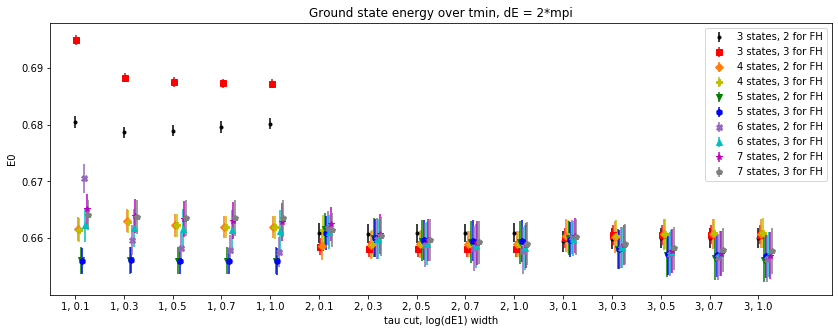

<Figure size 432x288 with 0 Axes>

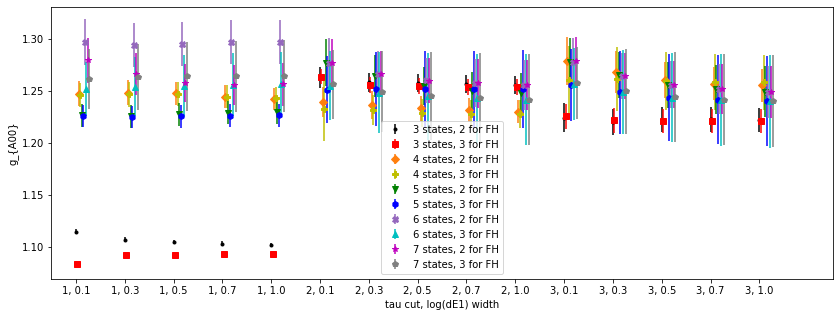

<Figure size 432x288 with 0 Axes>

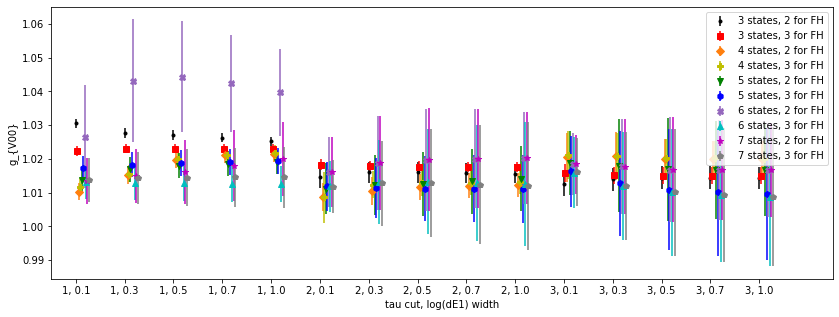

<Figure size 432x288 with 0 Axes>

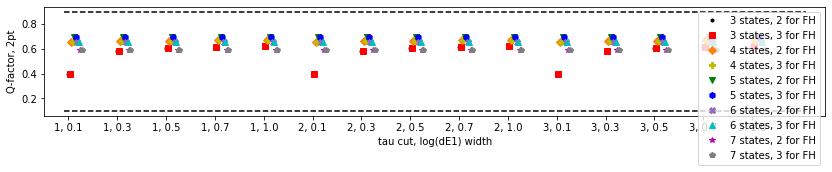

<Figure size 432x288 with 0 Axes>

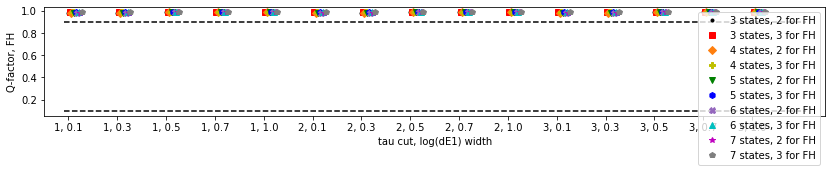

<Figure size 432x288 with 0 Axes>

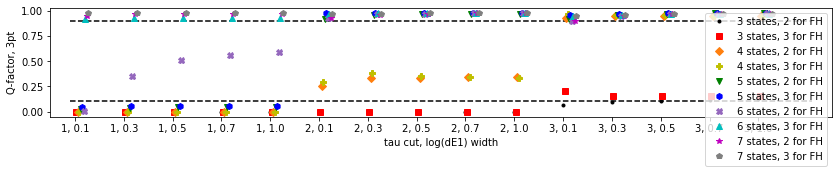

<Figure size 432x288 with 0 Axes>

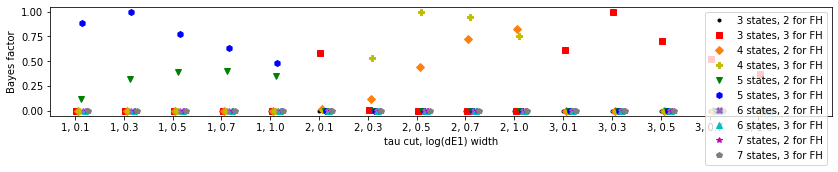

<Figure size 432x288 with 0 Axes>

In [124]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^', '*', 'p'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
ax_labels = np.array(["3 states, 2 for FH", "3 states, 3 for FH", "4 states, 2 for FH", "4 states, 3 for FH", \
                      "5 states, 2 for FH", "5 states, 3 for FH", "6 states, 2 for FH", "6 states, 3 for FH", \
                      "7 states, 2 for FH", "7 states, 3 for FH",])






# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

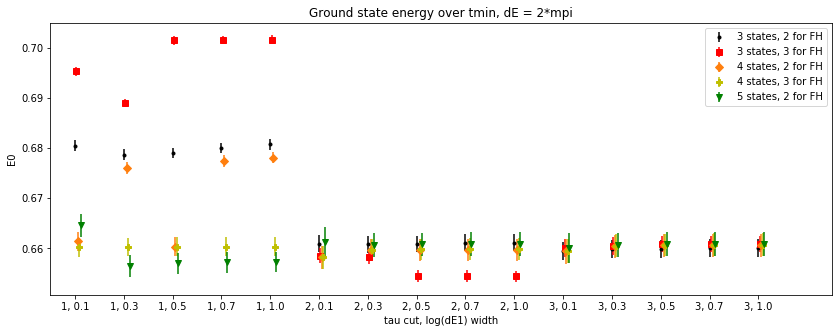

<Figure size 432x288 with 0 Axes>

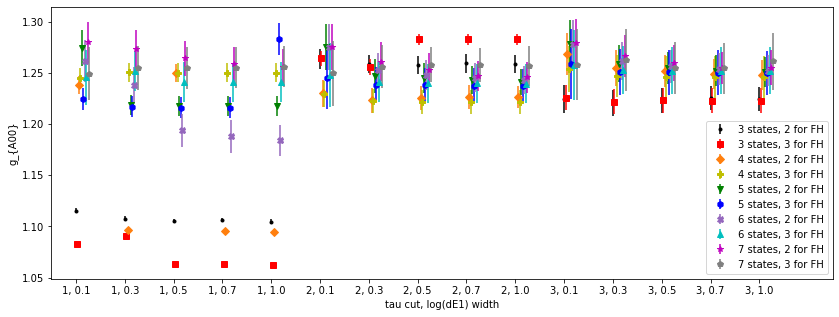

<Figure size 432x288 with 0 Axes>

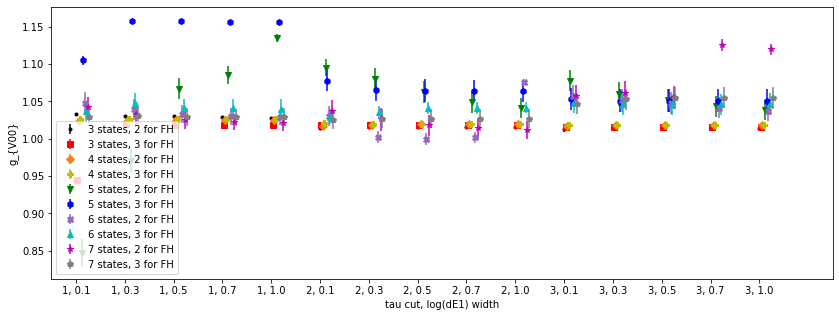

<Figure size 432x288 with 0 Axes>

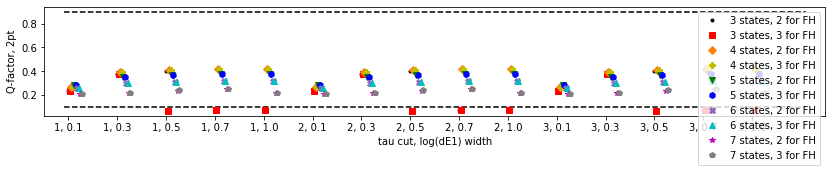

<Figure size 432x288 with 0 Axes>

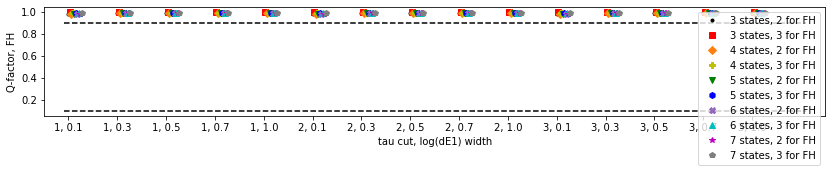

<Figure size 432x288 with 0 Axes>

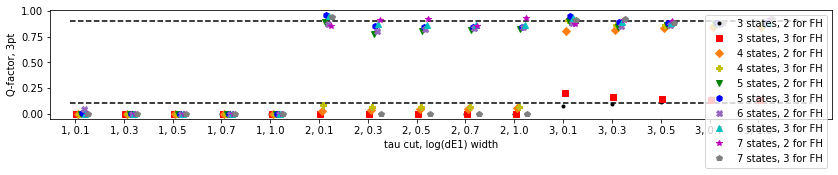

<Figure size 432x288 with 0 Axes>

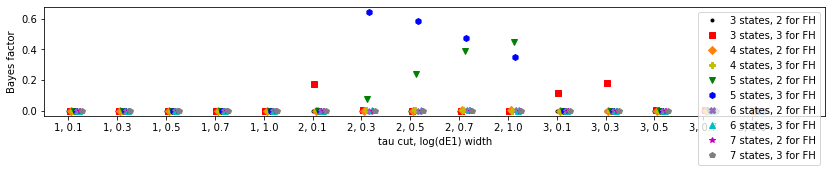

<Figure size 432x288 with 0 Axes>

In [125]:
# 1/n
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

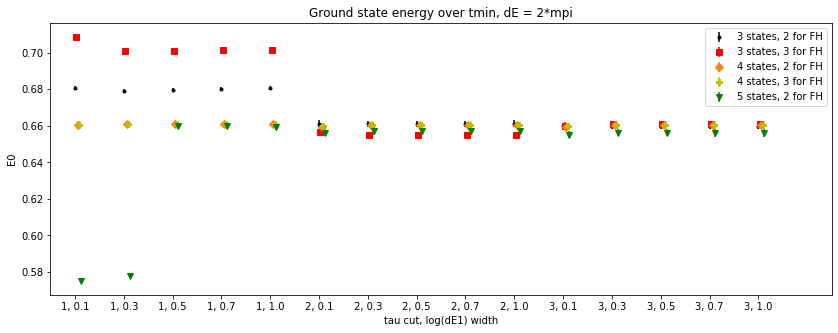

<Figure size 432x288 with 0 Axes>

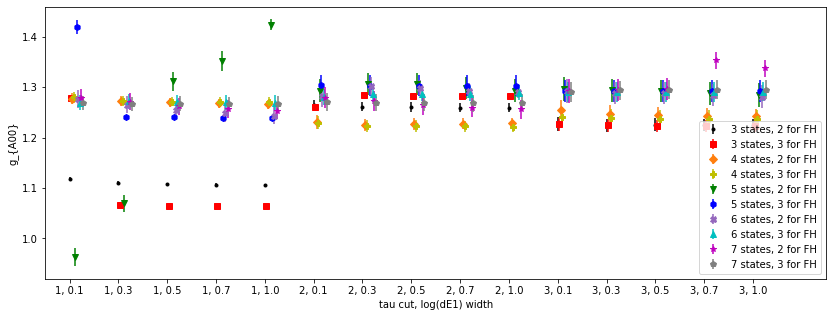

<Figure size 432x288 with 0 Axes>

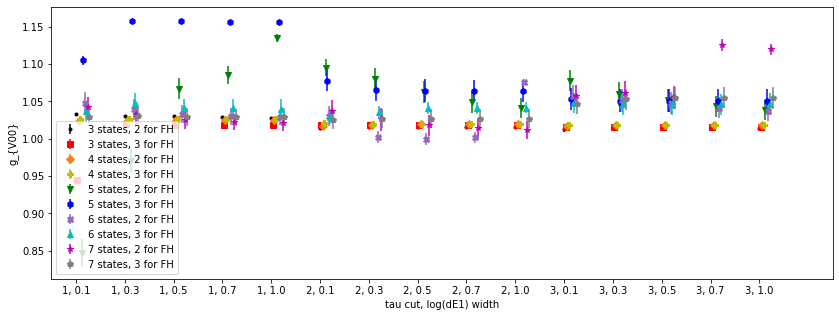

<Figure size 432x288 with 0 Axes>

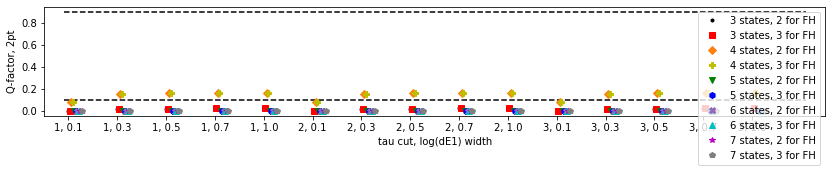

<Figure size 432x288 with 0 Axes>

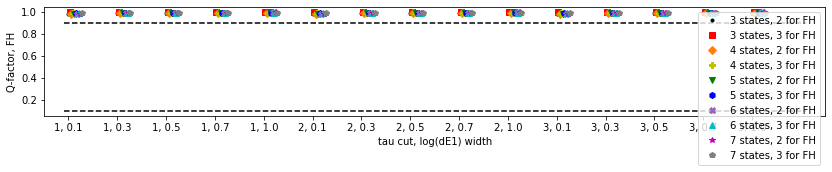

<Figure size 432x288 with 0 Axes>

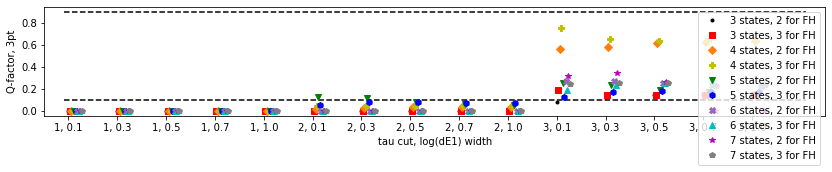

<Figure size 432x288 with 0 Axes>

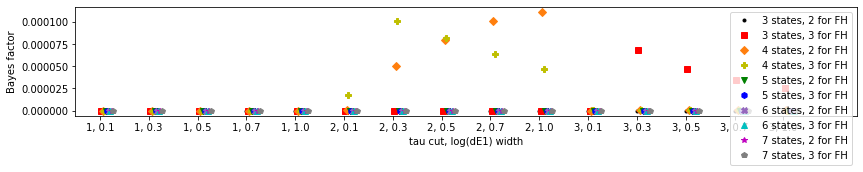

<Figure size 432x288 with 0 Axes>

In [126]:
# 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()